In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from collections import OrderedDict

import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score

In [2]:
config = OrderedDict([
    ('10/09/2012', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'MER', 'ICT', 'JFC', 'JGS', 'BEL', 'MBT', 'MEG', 'MWC', 'MPI',
        'PX', 'RLC', 'EDC', 'SCC', 'SMDC', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('11/03/2013', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'MER', 'ICT', 'JFC', 'JGS', 'BEL', 'MBT', 'MEG', 'MWC', 'MPI',
        'PX', 'RLC', 'EDC', 'SCC', 'BLOOM', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('09/16/2013', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MWC', 'MPI',
        'PX', 'RLC', 'EDC', 'SCC', 'BLOOM', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('03/17/2014', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'PX', 'RLC', 'EDC', 'SCC', 'BLOOM', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('09/15/2014', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'EMP', 'RLC', 'EDC', 'SCC', 'BLOOM', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('12/09/2015', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'EMP', 'RLC', 'EDC', 'SCC', 'SECB', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('03/13/2017', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'PGOLD', 'RLC', 'EDC', 'SCC', 'SECB', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('09/28/2017', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'PCOR', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'PGOLD', 'RLC', 'RRHI', 'SCC', 'SECB', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
    ('02/18/2019', [
        'AC', 'AEV', 'AGI', 'ALI', 'AP', 'BDO', 'BLOOM', 'BPI', 'DMC', 'FGEN',
        'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MEG', 'MER', 'MPI',
        'PGOLD', 'RLC', 'RRHI', 'SCC', 'SECB', 'SM', 'SMC', 'SMPH', 'TEL', 'URC', 'PSEI'
    ]),
])

In [3]:
main_df = pd.read_csv('consolidated_psei_quotes.csv', usecols=lambda x: 'Unnamed' not in x)[2:-11]
tweets_df = pd.read_csv('combined_tweets_with_sentiment_scores.csv', index_col=0)

c:\users\lex\docume~1\ftwsch~1\env\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# because the dates aren't zero padded :/
main_df['date'] = main_df['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%m/%d/%Y'))
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22
...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60


In [5]:
main_df['log_return'] = np.log(main_df['close'] / main_df['previous_close'])
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101
...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859


In [6]:
# because 1500 turns to 1.5K :/
tweets_df['favorite_count'] = tweets_df['favorite_count'].apply(
    lambda x: float(x) if 'K' not in str(x) else float(str(x).strip('K')) * 1000)
tweets_df.head()

,symbol,epoch_time,name,handle,url,tweet,reply_count,retweet_count,favorite_count,date,sentiment_score,label
0,AC,1192399907,D,davvyk,https://twitter.com/davvyk/status/335801692,hope england flatten the $ac)sts in RWC,0,0,0.0,10/15/2007,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...",1
1,AC,1218207877,JKIngram84,JKIngram154,https://twitter.com/JKIngram154/status/881583626,I´ve been fighting with banks for the last 12 ...,0,0,0.0,08/09/2008,"{'neg': 0.095, 'neu': 0.53, 'pos': 0.375, 'com...",1
2,AC,1261780693,"DIRECTED BY\r\nAC,🎥",mikemikefilms,https://twitter.com/mikemikefilms/status/70438...,& we STILL gotta hit up $ac!.. Hmm I wonder if...,0,0,0.0,12/26/2009,"{'neg': 0.136, 'neu': 0.767, 'pos': 0.098, 'co...",-1
3,AC,1261298199,BABY D,DEONNAROCKSTARR,https://twitter.com/DEONNAROCKSTARR/status/685...,OK GUY$ IM READY 2 LI$TEN 2 LITTLE BIT MORE MU...,0,0,0.0,12/20/2009,"{'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'comp...",1
4,AC,1261154012,CAC40,CAC40feed,https://twitter.com/CAC40feed/status/6800979366,"$$ #Accor Stock update: Accor, Host, Hyatt, La...",0,0,0.0,12/19/2009,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1


In [7]:
def get_previous_day(date):
    return datetime.strptime(date, '%m/%d/%Y') - timedelta(days=1)

def format_date(date, format='%m/%d/%Y'):
    return date.strftime(format)

def get_member_stocks(date):
    parsed_date = get_previous_day(date)
    for change_date, member_stocks in config.items():
        parsed_change_date = datetime.strptime(change_date, '%m/%d/%Y')
        if parsed_date >= parsed_change_date:
            return member_stocks

def get_relevant_tweets(date):
    return tweets_df[(tweets_df['date'] == format_date(get_previous_day(date))) & (tweets_df['symbol'].isin(get_member_stocks(date)))]

In [8]:
main_df['tweet_count'] = main_df['date'].apply(lambda date: len(get_relevant_tweets(date).index))

In [9]:
main_df.head()

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,16
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,11
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,24
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,23
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,14


In [10]:
# main_df['favorite_boost_score'] = main_df['date'].apply(lambda x: tweets_df[tweets_df['date'] == x])
# date = main_df.iloc[0].date
# tweet_subset = tweets_df[tweets_df['date'] == date]
# print(len(tweet_subset[tweet_subset['label'] == 1].index))
# print(tweet_subset['label']*(abs(tweet_subset['label']) + (0.5*tweet_subset['favorite_count'])))

In [11]:
main_df['positive_tweets_count'] = main_df['date'].apply(
    lambda date: len(tweets_df[(tweets_df['date'] == format_date(get_previous_day(date))) & (tweets_df['label'] == 1) & (tweets_df['symbol'].isin(get_member_stocks(date)))].index))
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,16,14
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,11,11
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,24,23
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,23,23
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363,274,244
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451,223,203
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717,82,80
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859,56,53


In [12]:
main_df['positive_tweets_ratio'] =  (main_df['positive_tweets_count'] / main_df['tweet_count']).fillna(0)
main_df
# main_df[main_df.isnull().any(axis=1)]

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,16,14,0.875000
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,11,11,1.000000
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,24,23,0.958333
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,23,23,1.000000
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,14,14,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363,274,244,0.890511
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451,223,203,0.910314
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717,82,80,0.975610
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859,56,53,0.946429


In [13]:
tweets_df['boosted_score'] = tweets_df.apply(
    lambda x: x['label'] * (abs(x['label']) + (0.5 * int(x['favorite_count']))), axis=1)
tweets_df

,symbol,epoch_time,name,handle,url,tweet,reply_count,retweet_count,favorite_count,date,sentiment_score,label,boosted_score
0,AC,1192399907,D,davvyk,https://twitter.com/davvyk/status/335801692,hope england flatten the $ac)sts in RWC,0,0,0.0,10/15/2007,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...",1,1.0
1,AC,1218207877,JKIngram84,JKIngram154,https://twitter.com/JKIngram154/status/881583626,I´ve been fighting with banks for the last 12 ...,0,0,0.0,08/09/2008,"{'neg': 0.095, 'neu': 0.53, 'pos': 0.375, 'com...",1,1.0
2,AC,1261780693,"DIRECTED BY\r\nAC,🎥",mikemikefilms,https://twitter.com/mikemikefilms/status/70438...,& we STILL gotta hit up $ac!.. Hmm I wonder if...,0,0,0.0,12/26/2009,"{'neg': 0.136, 'neu': 0.767, 'pos': 0.098, 'co...",-1,-1.0
3,AC,1261298199,BABY D,DEONNAROCKSTARR,https://twitter.com/DEONNAROCKSTARR/status/685...,OK GUY$ IM READY 2 LI$TEN 2 LITTLE BIT MORE MU...,0,0,0.0,12/20/2009,"{'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'comp...",1,1.0
4,AC,1261154012,CAC40,CAC40feed,https://twitter.com/CAC40feed/status/6800979366,"$$ #Accor Stock update: Accor, Host, Hyatt, La...",0,0,0.0,12/19/2009,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199471,URC,1505790466,MyTradePH-Abacus Sec,MyTradePH,https://twitter.com/MyTradePH/status/909977286...,"... $URC, $SMC, $BEL. Read the full report at ...",0,0,0.0,09/19/2017,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1,1.0
199472,URC,1505737174,kentir,ko_kom101,https://twitter.com/ko_kom101/status/909753762...,"coindera: Top 3\r\nURC,\r\nURC, $URC $BTC on Y...",0,0,1.0,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1,1.5
199473,URC,1505736062,Shitcoin Calls,ShitcoinCalls,https://twitter.com/ShitcoinCalls/status/90974...,"New post in Shitcoin Calls: Top 3\r\nURC, $URC...",0,0,2.0,09/18/2017,"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",1,2.0
199474,URC,1505736031,Coindera,coindera,https://twitter.com/coindera/status/9097489714...,"Top 3\r\nURC,\r\nURC, $URC $BTC on @YobitExcha...",0,0,2.0,09/18/2017,"{'neg': 0.0, 'neu': 0.913, 'pos': 0.087, 'comp...",1,2.0


In [14]:
main_df['favorite_boosted_score'] = main_df['date'].apply(lambda date: sum((get_relevant_tweets(date))['boosted_score']))
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,16,14,0.875000,12.5
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,11,11,1.000000,12.0
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,24,23,0.958333,24.5
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,23,23,1.000000,23.0
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,14,14,1.000000,14.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363,274,244,0.890511,456.5
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451,223,203,0.910314,594.0
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717,82,80,0.975610,378.0
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859,56,53,0.946429,74.0


In [15]:
main_df['hype_score'] = main_df['date'].apply(
    lambda date: sum(abs((get_relevant_tweets(date))['boosted_score'])))
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,16,14,0.875000,12.5,16.5
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,11,11,1.000000,12.0,12.0
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,24,23,0.958333,24.5,26.5
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,23,23,1.000000,23.0,23.0
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,14,14,1.000000,14.5,14.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363,274,244,0.890511,456.5,567.5
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451,223,203,0.910314,594.0,728.0
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717,82,80,0.975610,378.0,429.0
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859,56,53,0.946429,74.0,95.0


In [16]:
main_df['target'] = main_df.apply(lambda x: int(x['close'] > x['previous_close']), axis=1)
main_df

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score,target
2,^PSEi,10/10/2012,5394.09,5408.02,5365.17,5369.60,6908518,-518407,5394.90,-0.004701,16,14,0.875000,12.5,16.5,0
3,^PSEi,10/11/2012,5376.19,5384.83,5353.47,5353.47,5582156,-314692,5369.60,-0.003008,11,11,1.000000,12.0,12.0,0
4,^PSEi,10/12/2012,5353.71,5372.68,5353.71,5369.72,27489636,-12742649,5353.47,0.003031,24,23,0.958333,24.5,26.5,1
5,^PSEi,10/15/2012,5366.92,5383.22,5360.91,5383.22,9100097,-515539,5369.72,0.002511,23,23,1.000000,23.0,23.0,1
6,^PSEi,10/16/2012,5383.90,5406.02,5383.90,5399.94,7155385,-410688,5383.22,0.003101,14,14,1.000000,14.5,14.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363,274,244,0.890511,456.5,567.5,0
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451,223,203,0.910314,594.0,728.0,1
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717,82,80,0.975610,378.0,429.0,1
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859,56,53,0.946429,74.0,95.0,0


In [17]:
main_df.to_csv('out.csv')

In [130]:
# from sklearn.preprocessing import StandardScaler
from tpot import TPOTClassifier

features = ['volume', 'nfbs', 'tweet_count', 'positive_tweets_ratio', 'favorite_boosted_score', 'hype_score']
X = main_df[features][:-249]
# X = StandardScaler().fit_transform(X)
y = main_df['target'][:-249]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
# Initialize model
# model = LogisticRegression()
model = xgboost.XGBClassifier()
# model = TPOTClassifier(generations=10, verbosity=2)

# Fit model
model.fit(X_train, y_train)
# Predict prices for test data
y_predicted = model.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(y_test, y_predicted)))
print('Precision: {}'.format(precision_score(y_test, y_predicted)))
print('Recall: {}'.format(recall_score(y_test, y_predicted)))
print('ROC AUC: {}'.format(roc_auc_score(y_test, y_predicted)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test, y_predicted)))

scores = cross_val_score(model, X, y, cv=5)
# print(scores)
print('CV score: {}'.format(np.average(scores)))

Accuracy: 0.6180904522613065
Precision: 0.6404833836858006
Recall: 0.660436137071651
ROC AUC: 0.614638358390898
Confusion Matrix:
[[157 119]
 [109 212]]
CV score: 0.6011829139637719


In [131]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [132]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

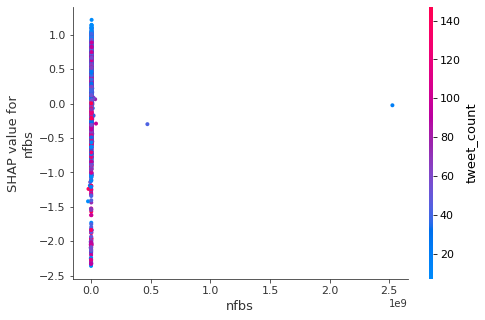

In [133]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("nfbs", shap_values, X)

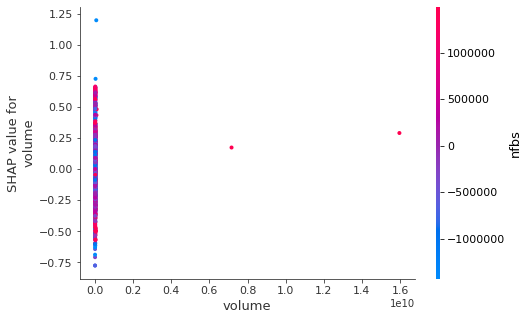

In [134]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("volume", shap_values, X)

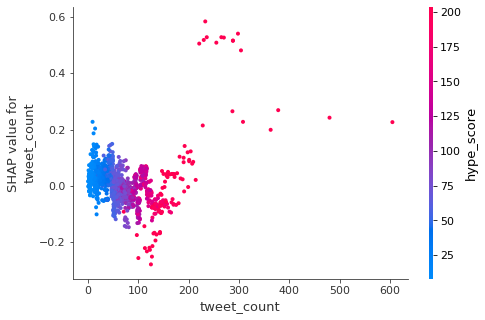

In [135]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("tweet_count", shap_values, X)

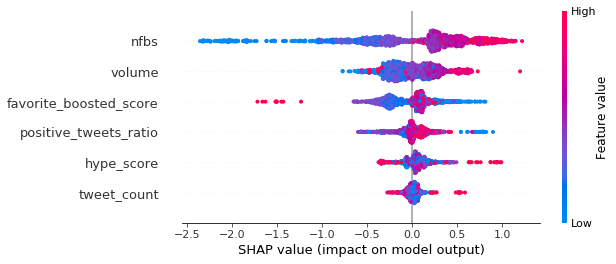

In [136]:
shap.summary_plot(shap_values, X)

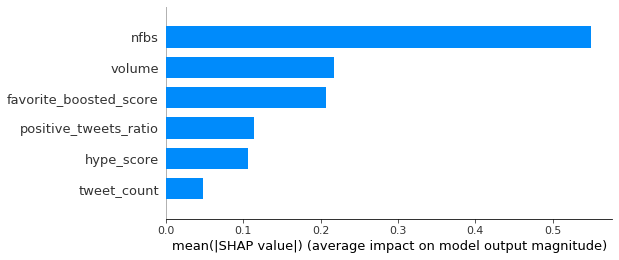

In [137]:
shap.summary_plot(shap_values, X, plot_type="bar")

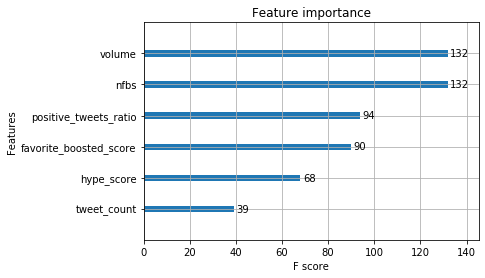

In [144]:
xgboost.plot_importance(model, importance_type='weight')

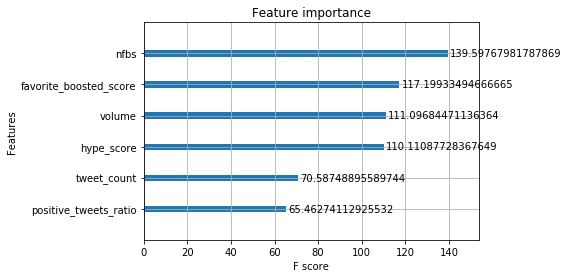

In [145]:
xgboost.plot_importance(model, importance_type='cover')

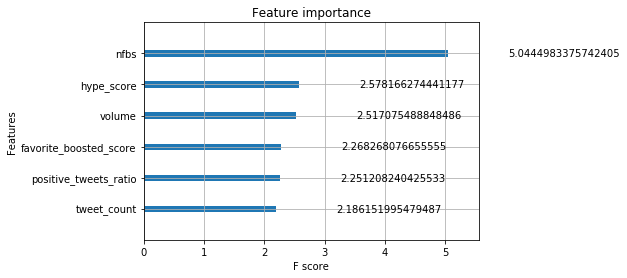

In [146]:
xgboost.plot_importance(model, importance_type='gain')

In [138]:
test_data = main_df.iloc[-249:]
test_data

,symbol,date,open,high,low,close,volume,nfbs,previous_close,log_return,tweet_count,positive_tweets_count,positive_tweets_ratio,favorite_boosted_score,hype_score,target
1494,^PSEi,12/12/2018,7455.98,7488.24,7425.66,7488.24,11904455,-984701,7451.08,0.004975,72,68,0.944444,75.5,88.5,1
1495,^PSEi,12/13/2018,7514.35,7556.24,7513.56,7522.92,6093320,324835,7488.24,0.004621,75,70,0.933333,116.0,126.0,1
1496,^PSEi,12/14/2018,7506.40,7559.27,7503.09,7524.37,6846972,-691234,7522.92,0.000193,68,65,0.955882,195.5,218.5,1
1497,^PSEi,12/17/2018,7501.27,7538.14,7490.56,7520.40,5935949,-822246,7524.37,-0.000528,44,41,0.931818,49.0,55.0,0
1498,^PSEi,12/18/2018,7478.36,7482.21,7397.23,7420.40,8497816,-652153,7520.40,-0.013386,108,102,0.944444,134.0,152.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,^PSEi,12/19/2019,7751.21,7751.21,7617.75,7653.94,12599420,-2048227,7733.67,-0.010363,274,244,0.890511,456.5,567.5,0
1739,^PSEi,12/20/2019,7643.99,7773.12,7469.41,7773.12,13153106,-1271056,7653.94,0.015451,223,203,0.910314,594.0,728.0,1
1740,^PSEi,12/23/2019,7745.96,7872.60,7745.26,7872.60,8296349,-1219944,7773.12,0.012717,82,80,0.975610,378.0,429.0,1
1741,^PSEi,12/26/2019,7794.53,7842.28,7772.97,7842.28,3602654,143382,7872.60,-0.003859,56,53,0.946429,74.0,95.0,0


In [139]:
X_test_data = test_data[features]
y_test_data = test_data['target']

y_test_data_predicted = model.predict(X_test_data)
print('Accuracy: {}'.format(accuracy_score(y_test_data, y_test_data_predicted)))
print('Precision: {}'.format(precision_score(y_test_data, y_test_data_predicted)))
print('Recall: {}'.format(recall_score(y_test_data, y_test_data_predicted)))
print('ROC AUC: {}'.format(roc_auc_score(y_test_data, y_test_data_predicted)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test_data, y_test_data_predicted)))

Accuracy: 0.6265060240963856
Precision: 0.6268656716417911
Recall: 0.6614173228346457
ROC AUC: 0.6257906286304377
Confusion Matrix:
[[72 50]
 [43 84]]


In [140]:
y_test_data

1494    1
1495    1
1496    1
1497    0
1498    0
       ..
1738    0
1739    1
1740    1
1741    0
1742    0
Name: target, Length: 249, dtype: int64

In [141]:
y_test_data_predicted

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [142]:
test = X_test_data.copy()
test['target'] = y_test_data
test['predicted'] = y_test_data_predicted
test['date'] = test_data['date']
test.to_csv('predicted.csv')

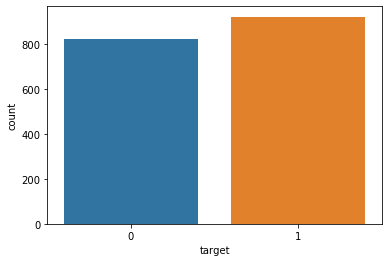

In [143]:
import seaborn as sns
main_df.describe()
sns.countplot(main_df['target'])
# sns.countplot(tweets_df['label'])

## Sentiment Analysis

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pattern.en import ngrams, sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Data Preprocessing and Feature Engineering
import re
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [27]:
train_tweets = tweets_df[['tweet', 'label']]
test_tweets = tweets_df[['tweet']]

In [28]:
def text_processing(tweet):
    
    #Generating the list of words in the tweet (hastags and other punctuations removed)
    def form_sentence(tweet):
        return TextBlob(str(tweet))
    new_tweet = form_sentence(tweet)
    print(tweet)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet_list):
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    print(no_punc_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word, 'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
    
    return normalization(no_punc_tweet)

In [29]:
d = train_tweets.copy()
d = d.iloc[:10]
d['tweet_list'] = d['tweet'].apply(text_processing)
d.head()

hope england flatten the $ac)sts in RWC
['h', 'p', 'e', 'e', 'n', 'g', 'l', 'n', 'f', 'l', 'e', 'n', 'h', 'e', 'c', 'n', 'R', 'W', 'C']
I´ve been fighting with banks for the last 12 hours. Fun, fun, fun. F ra U d Tr An $aC + ¡ 0nS
['v', 'e', 'b', 'e', 'e', 'n', 'f', 'g', 'h', 'n', 'g', 'w', 'h', 'b', 'n', 'k', 'f', 'r', 'h', 'e', 'l', 'h', 'u', 'r', 'F', 'u', 'n', 'f', 'u', 'n', 'f', 'u', 'n', 'F', 'r', 'U', 'r', 'n', 'C', 'n']
& we STILL gotta hit up $ac!.. Hmm I wonder if my aunt let me take my plate to go cuz I got shit to do lol
['w', 'e', 'L', 'L', 'g', 'h', 'u', 'p', 'c', 'H', 'w', 'n', 'e', 'r', 'f', 'u', 'n', 'l', 'e', 'e', 'k', 'e', 'p', 'l', 'e', 'g', 'c', 'u', 'z', 'g', 'h', 'l', 'l']
OK GUY$ IM READY 2 LI$TEN 2 LITTLE BIT MORE MU$IC THEN IMMA HIT THA $AC!!!
['K', 'G', 'U', 'R', 'E', 'L', 'E', 'N', 'L', 'L', 'E', 'B', 'R', 'E', 'U', 'C', 'H', 'E', 'N', 'H', 'H', 'C']
$$ #Accor Stock update: Accor, Host, Hyatt, LaSalle and Whitbread:
AC,
AC,Stock update: Accor, Host, Hy.. htt

,tweet,label,tweet_list
0,hope england flatten the $ac)sts in RWC,1,"[h, p, e, e, n, g, l, n, f, l, e, n, h, e, c, ..."
1,I´ve been fighting with banks for the last 12 ...,1,"[v, e, b, e, e, n, f, g, h, n, g, w, h, b, n, ..."
2,& we STILL gotta hit up $ac!.. Hmm I wonder if...,-1,"[w, e, L, L, g, h, u, p, c, H, w, n, e, r, f, ..."
3,OK GUY$ IM READY 2 LI$TEN 2 LITTLE BIT MORE MU...,1,"[K, G, U, R, E, L, E, N, L, L, E, B, R, E, U, ..."
4,"$$ #Accor Stock update: Accor, Host, Hyatt, La...",1,"[c, c, r, c, k, u, p, e, c, c, r, H, H, L, l, ..."


In [30]:
# train_tweets['tweet_list'] = train_tweets['tweet'].apply(text_processing)
# test_tweets['tweet_list'] = test_tweets['tweet'].apply(text_processing)

X = train_tweets['tweet']
y = train_tweets['label']

In [31]:
from sklearn.model_selection import train_test_split
msg_train, msg_test, label_train, label_test = train_test_split(train_tweets['tweet'], train_tweets['label'], test_size=0.2)
msg_test
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
msg_train.fillna('', inplace=True)
msg_test.fillna('', inplace=True)
# msg_train.to_csv('C:/Users/Lex/Desktop/test.csv')

pipeline.fit(msg_train, label_train)

predictions = pipeline.predict(msg_test)

print(classification_report(predictions, label_test))
print ('\n')
print(confusion_matrix(predictions, label_test))
print(accuracy_score(predictions, label_test))

$IAG $AGI:
AGI,
AGI,Aurico Gold Is A Sell Due To High Cash Costs, Debt Load:
AGI,
AGI,http://www.stocknewswires.com/2015/02/iag-agi-aurico-gold-is-a-sell-due-to-high-cash-costs-debt-load.html …
['G', 'G', 'G', 'G', 'u', 'r', 'c', 'G', 'l', 'e', 'l', 'l', 'u', 'e', 'H', 'g', 'h', 'C', 'h', 'C', 'e', 'b', 'L', 'G', 'G', 'h', 'p', 'w', 'w', 'w', 'c', 'k', 'n', 'e', 'w', 'w', 'r', 'e', 'c', 'g', 'g', 'u', 'r', 'c', 'g', 'l', 'e', 'l', 'l', 'u', 'e', 'h', 'g', 'h', 'c', 'h', 'c', 'e', 'b', 'l', 'h', 'l']
RT @_kmontealegre: $RLC capital expenditure budget at P15-17 billion for fiscal year 2015 vs approved P16 billion budget for FY 2014
['R', '_', 'k', 'n', 'e', 'l', 'e', 'g', 'r', 'e', 'R', 'L', 'C', 'c', 'p', 'l', 'e', 'x', 'p', 'e', 'n', 'u', 'r', 'e', 'b', 'u', 'g', 'e', 'P', 'b', 'l', 'l', 'n', 'f', 'r', 'f', 'c', 'l', 'e', 'r', 'v', 'p', 'p', 'r', 'v', 'e', 'P', 'b', 'l', 'l', 'n', 'b', 'u', 'g', 'e', 'f', 'r', 'F']
MS ahora pateando $AC #TRMX :)
['h', 'r', 'p', 'e', 'n', 'C', 'R', 'X']

['b', 'l', 'e', 'e', 'l', 'e', 'e', 'B', 'k', 'e', 'n', 'n', 'e', 'b', 'C', 'n', 'P', 'e', 'n', 'n', 'P', 'l', 'n', 'n', 'v', 'e', 'e', 'n', 'B', 'r', 'h', 'p', 'f', 'f', 'N', 'U']
Today's Short Takes, In Focus: $JFC, $URC, $DNL, $RRHI, $PGOLD, #PSEi, $MWC, $MPI. Read the full report at http://mytrade.com.ph .  #ShortTakes #SwitchToMyTrade
['h', 'r', 'k', 'e', 'n', 'F', 'c', 'u', 'J', 'F', 'C', 'U', 'R', 'C', 'N', 'L', 'R', 'R', 'H', 'P', 'G', 'L', 'P', 'E', 'W', 'C', 'P', 'R', 'e', 'h', 'e', 'f', 'u', 'l', 'l', 'r', 'e', 'p', 'r', 'h', 'p', 'r', 'e', 'c', 'p', 'h', 'h', 'r', 'k', 'e', 'w', 'c', 'h', 'r', 'e']
FibroGen $FGEN Rating Lowered to Hold at Zacks Investment Research http://tickerreport.com/?p=3945695 
['F', 'b', 'r', 'G', 'e', 'n', 'F', 'G', 'E', 'N', 'R', 'n', 'g', 'L', 'w', 'e', 'r', 'e', 'H', 'l', 'Z', 'c', 'k', 'n', 'v', 'e', 'e', 'n', 'R', 'e', 'e', 'r', 'c', 'h', 'h', 'p', 'c', 'k', 'e', 'r', 'r', 'e', 'p', 'r', 'c', 'p']
Robinsons Retail $RRHI acquires assets of the co

['G', 'P', 'n', 'e', 'r', 'g', 'P', 'h', 'r', 'c', 'e', 'u', 'c', 'l', 'n', 'c', 'E', 'x', 'c', 'h', 'n', 'g', 'e', 'E', 'C', 'h', 'p', 'l', 'v', 'r', 'B', 'Q', 'W', 'C', 'E', 'C', 'E', 'C', 'G', 'P', 'G', 'X', 'E', 'C', 'K', 'L', 'C', 'G', 'P', 'c', 'k', 'n', 'q']
$MPI: Sub Metropac Water Investments entered into an agreement to operate & maintain the 100mld bulk water facility of Rio Verde Water Corp
['P', 'u', 'b', 'e', 'r', 'p', 'c', 'W', 'e', 'r', 'n', 'v', 'e', 'e', 'n', 'e', 'n', 'e', 'r', 'e', 'n', 'n', 'g', 'r', 'e', 'e', 'e', 'n', 'p', 'e', 'r', 'e', 'n', 'n', 'h', 'e', 'l', 'b', 'u', 'l', 'k', 'w', 'e', 'r', 'f', 'c', 'l', 'f', 'R', 'V', 'e', 'r', 'e', 'W', 'e', 'r', 'C', 'r', 'p']
RT @AnalystWire Jacob Securities Starts Alamos $GLD $AGI at Buy http://streetinsider.com/r/8719254 
['R', 'n', 'l', 'W', 'r', 'e', 'J', 'c', 'b', 'e', 'c', 'u', 'r', 'e', 'r', 'l', 'G', 'L', 'G', 'B', 'u', 'h', 'p', 'r', 'e', 'e', 'n', 'e', 'r', 'c', 'r']
Drawdown kind of day. $psei #trading
['r',

['N', 'R', 'c', 'k', 'h', 'p', 'w', 'w', 'w', 'l', 'c', 'k', 'p', 'l', 'c', 'N', 'R', 'c', 'k', 'h', 'l', 'H', 'E', 'Z', 'U', 'F', 'R', 'E', 'W', 'K', 'C', 'F', 'X', 'E', 'W', 'F', 'R', 'E', 'W', 'E', 'E', 'N', 'F', 'B', 'N', 'E', 'C', 'G', 'X', 'F', 'U', 'F', 'U', 'N', 'E', 'F']
Facebook user reported Cebu Pacific staff disallows passenger to fly; citing passport problem   https://www.facebook.com/photo.php?fbid=10203473386497882&set=a.2649961570846.151137.1309943651&type=1 … $CEB $JGS #cebupac
['F', 'c', 'e', 'b', 'k', 'u', 'e', 'r', 'r', 'e', 'p', 'r', 'e', 'C', 'e', 'b', 'u', 'P', 'c', 'f', 'c', 'f', 'f', 'l', 'l', 'w', 'p', 'e', 'n', 'g', 'e', 'r', 'f', 'l', 'c', 'n', 'g', 'p', 'p', 'r', 'p', 'r', 'b', 'l', 'e', 'h', 'p', 'w', 'w', 'w', 'f', 'c', 'e', 'b', 'k', 'c', 'p', 'h', 'p', 'h', 'p', 'f', 'b', 'e', 'p', 'e', 'C', 'E', 'B', 'J', 'G', 'c', 'e', 'b', 'u', 'p', 'c']
$AC - Accor: cassure de la MM100 vers 25,3E ? http://fr.advfn.com/actualites/Accor-cassure-de-la-MM100-vers-25-3E

['G', 'C', 'P', 'e', 'n', 'e', 'c', 'l', 'r', 'n', 'f', 'C', 'h', 'v', 'e', 'n', 'P', 'e', 'c', 'l', 'u', 'r', 'e', 'h', 'p', 'w', 'w', 'w', 'p', 'e', 'b', 'l', 'c', 'c', 'l', 'u', 'r', 'e', 'f', 'c', 'b', 'b', 'e', 'c']
https://www.tradingview.com/x/3VBpVxWy/
RLC,
RLC,$rlc hey $chico freak out!
RLC,
RLC,$rekt incoming suckers
['h', 'p', 'w', 'w', 'w', 'r', 'n', 'g', 'v', 'e', 'w', 'c', 'x', 'V', 'B', 'p', 'V', 'x', 'W', 'R', 'L', 'C', 'R', 'L', 'C', 'r', 'l', 'c', 'h', 'e', 'c', 'h', 'c', 'f', 'r', 'e', 'k', 'u', 'R', 'L', 'C', 'R', 'L', 'C', 'r', 'e', 'k', 'n', 'c', 'n', 'g', 'u', 'c', 'k', 'e', 'r']
$RRHI Boosted by New Oil Production Plans in Mozambique http://dtg.fm/a2Pc  ~ http://disclaim.it/f/27-w 
['R', 'R', 'H', 'B', 'e', 'b', 'N', 'e', 'w', 'l', 'P', 'r', 'u', 'c', 'n', 'P', 'l', 'n', 'n', 'z', 'b', 'q', 'u', 'e', 'h', 'p', 'g', 'f', 'P', 'c', 'h', 'p', 'c', 'l', 'f', 'w']
$MBT:ASX ! 06:58 PM Appendix 4C - quarterly http://bit.ly/cdXHym
['B', 'X', 'P', 'p', 'p', 'e', 'n', 'x'

['b', 'l', 'e', 'e', 'l', 'e', 'e', 'B', 'B', 'n', 'n', 'u', 'n', 'c', 'e', 'e', 'c', 'n', 'f', 'B', 'r', 'f', 'r', 'e', 'c', 'r', 'P', 'R', 'N', 'e', 'w', 'w', 'r', 'e', 'E', 'u', 'r', 'p', 'e', 'n', 'h', 'p', 'n', 'v', 'e', 'r', 'h', 'n', 'g', 'u', 'c', 'p', 'v', 'e', 'w']
$NOAH News Updated Sunday, February 8, 2015 10:59:24 PM $XLK $QLD $UPRO $PX http://bit.ly/1xTSaWa 
['N', 'H', 'N', 'e', 'w', 'U', 'p', 'e', 'u', 'n', 'F', 'e', 'b', 'r', 'u', 'r', 'P', 'X', 'L', 'K', 'Q', 'L', 'U', 'P', 'R', 'P', 'X', 'h', 'p', 'b', 'l', 'x', 'W']
$AC in Uptrend: RSI indicator exits oversold zone. View odds for this and other indicators: https://tickeron.com/go/938051  #AssociatedCapitalGroup #stockmarket #stock #technicalanalysis #money #trading #investing #daytrading #news #today
['C', 'n', 'U', 'p', 'r', 'e', 'n', 'R', 'n', 'c', 'r', 'e', 'x', 'v', 'e', 'r', 'l', 'z', 'n', 'e', 'V', 'e', 'w', 'f', 'r', 'h', 'n', 'h', 'e', 'r', 'n', 'c', 'r', 'h', 'p', 'c', 'k', 'e', 'r', 'n', 'c', 'g', 'c', 'e',

['c', 'h', 'e', 'l', 'P', 'g', 'e', 'n', 'e', 'r', 'n', 'n', 'l', 'p', 'l', 'c', 'P', 'R', 'e', 'G', 'B', 'X', 'P', 'h', 'p', 'f', 'J', 'l', 'R', 'f']
$ICT: ICTSI says Ecuador port cleared to handle mega vessels
['C', 'C', 'E', 'c', 'u', 'r', 'p', 'r', 'c', 'l', 'e', 'r', 'e', 'h', 'n', 'l', 'e', 'e', 'g', 'v', 'e', 'e', 'l']
Michael Page International plc Rating Lowered to Hold at Jefferies Group $MPI http://ift.tt/1iWnLnf 
['c', 'h', 'e', 'l', 'P', 'g', 'e', 'n', 'e', 'r', 'n', 'n', 'l', 'p', 'l', 'c', 'R', 'n', 'g', 'L', 'w', 'e', 'r', 'e', 'H', 'l', 'J', 'e', 'f', 'f', 'e', 'r', 'e', 'G', 'r', 'u', 'p', 'P', 'h', 'p', 'f', 'W', 'n', 'L', 'n', 'f']
#MEGEnergy #Energy Corp Given New C$8.00 Price Target at CIBC. Read more: http://owler.us/abJKUY  $MEG
['E', 'G', 'E', 'n', 'e', 'r', 'g', 'E', 'n', 'e', 'r', 'g', 'C', 'r', 'p', 'G', 'v', 'e', 'n', 'N', 'e', 'w', 'C', 'P', 'r', 'c', 'e', 'r', 'g', 'e', 'C', 'B', 'C', 'R', 'e', 'r', 'e', 'h', 'p', 'w', 'l', 'e', 'r', 'u', 'b', 'J', 'K', '

['C', 'p', 'p']
$SMPH new blahblah blah
['P', 'H', 'n', 'e', 'w', 'b', 'l', 'h', 'b', 'l', 'h', 'b', 'l', 'h']
$PSEi falters, tumbling 3.5% on broader Asian sell-off. Investors indifferent to 1Q13 GDP growth, at 7.8% YoY
['P', 'E', 'f', 'l', 'e', 'r', 'u', 'b', 'l', 'n', 'g', 'n', 'b', 'r', 'e', 'r', 'n', 'e', 'l', 'l', 'f', 'f', 'n', 'v', 'e', 'r', 'n', 'f', 'f', 'e', 'r', 'e', 'n', 'Q', 'G', 'P', 'g', 'r', 'w', 'h']
Get your say in on $MBT at SpeculatingStocks, the discovery engine. No login required! #stocks http://speculatingstocks.com/pulse/stock/MBT 
['G', 'e', 'u', 'r', 'n', 'n', 'B', 'p', 'e', 'c', 'u', 'l', 'n', 'g', 'c', 'k', 'h', 'e', 'c', 'v', 'e', 'r', 'e', 'n', 'g', 'n', 'e', 'N', 'l', 'g', 'n', 'r', 'e', 'q', 'u', 'r', 'e', 'c', 'k', 'h', 'p', 'p', 'e', 'c', 'u', 'l', 'n', 'g', 'c', 'k', 'c', 'p', 'u', 'l', 'e', 'c', 'k', 'B']
Analysts’ Weekly Ratings Updates for Praxair $PX http://stocknewstimes.com/?p=2894864  #stocks
['n', 'l', 'W', 'e', 'e', 'k', 'l', 'R', 'n', 'g', 

['C', 'l', 'F', 'R', 'E', 'E', 'g', 'B', 'e', 'f', 'r', 'w', 'c', 'h', 'n', 'g', 'v', 'e', 'c', 'u', 'r', 'r', 'e', 'n', 'r', 'e', 'u', 'r', 'n', 'G', 'B', 'l', 'C', 'C', 'h', 'p', 'w', 'w', 'w', 'e', 'r', 'n', 'c', 'r', 'p', 'c', 'e', 'r', 'n', 'f', 'r', 'e', 'e', 'g', 'b', 'e', 'r', 'U', 'Z', 'G', 'C', 'C', 'C', 'C', 'B', 'L', 'Z', 'L', 'N', 'K', 'E', 'X', 'C', 'N', 'E', 'V', 'B', 'B', 'L', 'U', 'N', 'R', 'C', 'P', 'C', 'F', 'U', 'H', 'U', 'C', 'B', 'Z', 'Z', 'R', 'C', 'N', 'X', 'P', 'H', 'P', 'G', 'G', 'B', 'X']
Claim FREE AdEx for watching videos – current returns: 0.9148 $ADX daily
AC,
AC,https://www.earncrypto.com/earn-free-adex/?r=91976&RQZ …
AC,
AC,$QTL $SCS $PAK $FCT $BT2 $NTRN $PONZI $LINX $DGD $SYNX $MLN $ALL $ATB $BBC $SUMO $AC $MAD $HALLO $HBN $TODAY $XZC $ZENGOLD $CMPCO $LIR
['C', 'l', 'F', 'R', 'E', 'E', 'E', 'x', 'f', 'r', 'w', 'c', 'h', 'n', 'g', 'v', 'e', 'c', 'u', 'r', 'r', 'e', 'n', 'r', 'e', 'u', 'r', 'n', 'X', 'l', 'C', 'C', 'h', 'p', 'w', 'w', 'w', 'e', 'r', 'n',

['E', 'n', 'e', 'r', 'g', 'R', 'e', 'c', 'e', 'v', 'e', 'C', 'n', 'e', 'n', 'u', 'r', 'g', 'e', 'P', 'r', 'c', 'e', 'f', 'r', 'B', 'r', 'k', 'e', 'r', 'g', 'e', 'h', 'p', 'z', 'p', 'r', 'n', 'F', 'V', 'x']
$PX ER on 1/26 Before Open. SP were DOWN 17 times out of last 28 qtrs (60%) in ER. http://ow.ly/bS6X308lcV6 
['P', 'X', 'E', 'R', 'n', 'B', 'e', 'f', 'r', 'e', 'p', 'e', 'n', 'P', 'w', 'e', 'r', 'e', 'W', 'N', 'e', 'u', 'f', 'l', 'q', 'r', 'n', 'E', 'R', 'h', 'p', 'w', 'l', 'b', 'X', 'l', 'c', 'V']
$V $AC Loblaw Grocery Chain Beats Canadian Banks in Credit-Card Survey via 
['V', 'C', 'L', 'b', 'l', 'w', 'G', 'r', 'c', 'e', 'r', 'C', 'h', 'n', 'B', 'e', 'C', 'n', 'n', 'B', 'n', 'k', 'n', 'C', 'r', 'e', 'C', 'r', 'u', 'r', 'v', 'e', 'v']
Mizuho Initiates Coverage on FibroGen, Inc $FGEN http://ift.tt/2xYAVfE 
['z', 'u', 'h', 'n', 'e', 'C', 'v', 'e', 'r', 'g', 'e', 'n', 'F', 'b', 'r', 'G', 'e', 'n', 'n', 'c', 'F', 'G', 'E', 'N', 'h', 'p', 'f', 'x', 'V', 'f', 'E']
$TSLA $GLD $SLV $GG $NUG

['e', 'e', 'n', 'g', 'g', 'r', 'n', 'h', 'l', 'e', 'b', 'c', 'k', 'C', 'n', 'n', 'n', 'g', 'g', 'h', 'l', 'e', 'b', 'c', 'k', 'G', 'u', 'c', 'c', 'n', 'e', 'g', 'e', 'u', 'p', 'w', 'l', 'k', 'r', 'u', 'n', 'g', 'e', 'e', 'c']
$MEG: Expects to generate P8B frm sale of RFOs by yrend amid strong demand. The sale of RFOs will add P15B to its revenues in next 3 years.
['E', 'G', 'E', 'x', 'p', 'e', 'c', 'g', 'e', 'n', 'e', 'r', 'e', 'P', 'B', 'f', 'r', 'l', 'e', 'f', 'R', 'F', 'b', 'r', 'e', 'n', 'r', 'n', 'g', 'e', 'n', 'h', 'e', 'l', 'e', 'f', 'R', 'F', 'w', 'l', 'l', 'P', 'B', 'r', 'e', 'v', 'e', 'n', 'u', 'e', 'n', 'n', 'e', 'x', 'e', 'r']
$MBT - Mobile TeleSystems Stock Analysis scott trade - http://www.dojispace.com/stock-picks/mobile-telesystems-stock-price-MBT.aspx
['B', 'b', 'l', 'e', 'e', 'l', 'e', 'e', 'c', 'k', 'n', 'l', 'c', 'r', 'e', 'h', 'p', 'w', 'w', 'w', 'j', 'p', 'c', 'e', 'c', 'c', 'k', 'p', 'c', 'k', 'b', 'l', 'e', 'e', 'l', 'e', 'e', 'c', 'k', 'p', 'r', 'c', 'e', 'B', 

['h', 'B', 'N', 'e', 'f', 'f', 'e', 'l', 'l', 'h', 'r', 'e', 'f', 'F', 'b', 'r', 'G', 'e', 'n', 'n', 'c', 'F', 'G', 'E', 'N', 'c', 'k', 'h', 'p', 'z', 'p', 'r', 'P', 'b', 'Z', 'P']
Our Penny Stock Picks Have Gained 3,600% In 9 Months! Subscribe To Get Our Future Picks: http://tinyurl.com/ohqu6ql  $RRHI $JOB $MDGN
['u', 'r', 'P', 'e', 'n', 'n', 'c', 'k', 'P', 'c', 'k', 'H', 'v', 'e', 'G', 'n', 'e', 'n', 'n', 'h', 'u', 'b', 'c', 'r', 'b', 'e', 'G', 'e', 'u', 'r', 'F', 'u', 'u', 'r', 'e', 'P', 'c', 'k', 'h', 'p', 'n', 'u', 'r', 'l', 'c', 'h', 'q', 'u', 'q', 'l', 'R', 'R', 'H', 'J', 'B', 'G', 'N']
Praxair (PX) 110.29 $PX Praxair Releases 2020 Sustainable Development Targets BusinessWire - Thu Jun 23, 9:30A http://investorshangout.com/post/view?id=3855514 …
['P', 'r', 'x', 'r', 'P', 'X', 'P', 'X', 'P', 'r', 'x', 'r', 'R', 'e', 'l', 'e', 'e', 'u', 'n', 'b', 'l', 'e', 'e', 'v', 'e', 'l', 'p', 'e', 'n', 'r', 'g', 'e', 'B', 'u', 'n', 'e', 'W', 'r', 'e', 'h', 'u', 'J', 'u', 'n', 'h', 'p', 'n', '

['B', 'e', 'g', 'h', 'e', 'Q', 'u', 'e', 'n', '_', 'u', 'c', 'h', 'r', 'e', 'C', 'C', 'E', 'C', 'n', 'f', 'r', 'n', 'g', 'n', 'g', 'e', 'c', 'r', 'e', 'c', 'q', 'u', 'n', 'l', 'k', 'H', 'p', 'p', 'e', 'n', 'n', 'g', 'N', 'w', 'n', 'L', 'n', 'g', 'e', 'l', 'e', 'G', 'L', 'h', 'p', 'r', 'u', 'r', 'u', 'r', 'u', 'r', 'b', 'u', 'z', 'z', 'b', 'l', 'g', 'p', 'c', 'w', 'r', 'r', 'e', 'n', 'b', 'u', 'f', 'f', 'e', 'b', 'e', 'h', 'l', 'G', 'L', 'G', 'L', 'C', 'G', 'P', 'C', 'R', 'N', 'C', 'R', 'H', 'U', 'R', 'F', 'H', 'U', 'H', 'U', 'B', 'G', 'H', 'U', 'B', 'B', 'H', 'H', 'H', 'G', 'C', 'H', 'B', 'X', 'H', 'H', 'F', 'H', 'H', 'G', 'X', 'H', 'E', 'H', 'R', 'L', 'F', 'H', 'R', 'C', 'G', 'L', 'R', 'E', 'G', 'L', 'P', 'G', 'L', 'G', 'L', 'N', 'C', 'G', 'L', 'B', 'G', 'L', 'F', 'H', 'G', 'L', 'F', 'F']
Do you know that #Book Value for $SM is $24.44 https://unicornbay.com/t/SM.US?utm_medium=tweet&utm_campaign=bookvalue&utm_source=twitter …
['u', 'k', 'n', 'w', 'h', 'B', 'k', 'V', 'l', 'u', 'e', 'f',

['B', 'C', 'B', 'C', 'W', 'e', 'n', 'e', 'e', 'J', 'u', 'W', 'e', 'e', 'k', 'E', 'R', 'E', 'R', 'J', 'n', 'h', 'p', 'e', 'n', 'e', 'r', 'p', 'u', 'p', 'e', 'r', 'E', 'R', 'E', 'R', 'B', 'C', 'E', 'H', 'N', 'E', 'X', 'L', 'X', 'R', 'P', 'E', 'C', 'G', 'B', 'C', 'C', 'V', 'C', 'E', 'N', 'Z', 'E', 'C', 'G', 'L', 'E', 'N', 'R', 'G', 'U', 'N', 'B', 'L', 'R', 'P', 'W', 'R', 'E', 'R', 'V', 'B', 'R', 'C', 'N', 'X', 'L', 'N', 'N', 'B', 'C', 'C', 'Q', 'U', 'C', 'X', 'B', 'L', 'Z', 'R', 'X', 'V', 'E', 'N', 'B', 'N', 'B', 'N', 'N', 'H', 'R', 'G', 'C', 'R', 'E', 'L', 'P', 'P']
http://goo.gl/BxbMCJ  <- Signup for @Timothysykes silver plan to get access to 3000 video lessons! $UTHR $SM $CHU $CXDC
['h', 'p', 'g', 'g', 'l', 'B', 'x', 'b', 'C', 'J', 'g', 'n', 'u', 'p', 'f', 'r', 'h', 'k', 'e', 'l', 'v', 'e', 'r', 'p', 'l', 'n', 'g', 'e', 'c', 'c', 'e', 'v', 'e', 'l', 'e', 'n', 'U', 'H', 'R', 'C', 'H', 'U', 'C', 'X', 'C']
short % to float of $CECO is 7.73 at 2018-10-15 http://sunshineavenue.com/stock/CEC

['b', 'e', 'u', 'r', 'e', 'g', 'r', 'r', 'e', 'e', 'v', 'e', 'n', 'c', 'e', 'w', 'h', 'R', 'P', 'F', 'G', 'E', 'N', 'n', 'e', 'e', 'c', 'b', 'h', 'p', 'w', 'e', 'r', 'c', 'l', 'n', 'r', 'u']
$FXI $YINN $YANG $MCHI $GXC $FXP $PGJ $CN $TDF $CHN $CXSE $XPP $FCA $YAO $YXI $GCH $JFC $KGRN $WCHN
['F', 'X', 'N', 'N', 'N', 'G', 'C', 'H', 'G', 'X', 'C', 'F', 'X', 'P', 'P', 'G', 'J', 'C', 'N', 'F', 'C', 'H', 'N', 'C', 'X', 'E', 'X', 'P', 'P', 'F', 'C', 'X', 'G', 'C', 'H', 'J', 'F', 'C', 'K', 'G', 'R', 'N', 'W', 'C', 'H', 'N']
"“The company is just getting ready if ever there are good opportunities, for example acquisitions in the future,” Puregold Vice-President for Investors Relations John Marson T. Hao said in a text message." $PGOLD
PGOLD,
PGOLD,Read more: https://www.bworldonline.com/puregold-to-hike-capital-to-p5b/ …
['h', 'e', 'c', 'p', 'n', 'j', 'u', 'g', 'e', 'n', 'g', 'r', 'e', 'f', 'e', 'v', 'e', 'r', 'h', 'e', 'r', 'e', 'r', 'e', 'g', 'p', 'p', 'r', 'u', 'n', 'e', 'f', 'r', 'e', 'x', 

['E', 'n', 'e', 'r', 'g', 'P', 'r', 'e', 'e', 'n', 'B', 'r', 'G', 'l', 'b', 'l', 'n', 'u', 'r', 'l', 'C', 'n', 'f', 'e', 'r', 'e', 'n', 'c', 'e', 'l', 'e', 'h', 'w', 'C', 'n', 'n', 'u', 'e', 'r', 'e', 'n', 'g', 'h', 'p', 'e', 'e', 'k', 'n', 'g', 'l', 'p', 'h', 'c', 'r', 'c', 'l', 'e', 'e', 'n', 'e', 'r', 'g', 'p', 'r', 'e', 'e', 'n', 'b', 'r', 'g', 'l', 'b', 'l', 'n', 'u', 'r', 'l', 'c', 'n', 'f', 'e', 'r', 'e', 'n', 'c', 'e', 'l', 'e', 'h', 'w', 'u', 'r', 'c', 'e', 'f', 'e', 'e', '_', 'f', 'u', '_', 'c', 'p', 'g', 'n', 'w', 'e', 'r', '_', 'u', 'e', 'u', '_', 'c', 'n', 'e', 'n', 'r', 'c', 'l', 'e', 'u', '_', 'e', 'u', 'c', 'l', 'u', '_', 'u', 'r', 'c', 'e', 'w', 'e', 'r', 'c', 'k', 'r', 'k', 'e', 'n', 'v', 'e', 'n', 'g', 'f', 'n', 'n', 'c', 'e']
Short sale volume (not short interest) for $MBB at 2019-02-15 is 33%. http://shortvolumes.com/?t=MBB  $CNX 65% $MBT 49% $HBI 59% $MCD 34%
['h', 'r', 'l', 'e', 'v', 'l', 'u', 'e', 'n', 'h', 'r', 'n', 'e', 'r', 'e', 'f', 'r', 'B', 'B', 'h', 'p', 

['C', 'c', 'c', 'r', 'H', 'e', 'l', 'n', 'e', 'u', 'n', 'r', 'e', 'c', 'e', 'u', 'r', 'g', 'é', 'n', 'é', 'r', 'l', 'g', 'r', 'u', 'p', 'e', 'F', 'B', 'h', 'p', 'f', 'r', 'v', 'f', 'n', 'c', 'c', 'u', 'l', 'e', 'c', 'c', 'r', 'H', 'e', 'l', 'n', 'e', 'u', 'n', 'r', 'e', 'c', 'e', 'u', 'r', 'g', 'e', 'n', 'e', 'r', 'l', 'g', 'r', 'u', 'p', 'e', 'F', 'B', '_', 'h', 'l', 'x', 'r', 'e', 'f', 'n', 'e', 'w', 'l', 'e', 'r', 'w', 'e', 'e', 'w']
Today's Short Takes, In Focus: #MSCI, $SM, $SMPH, $JFC, $MBT, $AGI, $SECB, $SMC, $FB, $GTCAP, Rate Hike, $MRP. Read the full report at http://mytrade.com.ph .  #ShortTakes #SwitchToMyTrade
['h', 'r', 'k', 'e', 'n', 'F', 'c', 'u', 'C', 'P', 'H', 'J', 'F', 'C', 'B', 'G', 'E', 'C', 'B', 'C', 'F', 'B', 'G', 'C', 'P', 'R', 'e', 'H', 'k', 'e', 'R', 'P', 'R', 'e', 'h', 'e', 'f', 'u', 'l', 'l', 'r', 'e', 'p', 'r', 'h', 'p', 'r', 'e', 'c', 'p', 'h', 'h', 'r', 'k', 'e', 'w', 'c', 'h', 'r', 'e']
PSEI closes at 6,932.81 up 1.57% or 107pts.  Index Gainers $JGS, $BPI

['v', 'e', 'n', 'C', 'l', 'e', 'n', 'r', 'c', 'n', 'P', 'G', 'L', 'P', 'R', 'E', 'F', 'E', 'R', 'R', 'E', 'B', 'E', 'R', 'E', 'H', 'R', 'E', 'C', 'P', 'B', 'E', 'X', 'C', 'H', 'P', 'G', 'L', 'P', 'G', 'L', 'E', 'X', 'C', 'H', 'P', 'G', 'L', 'C', 'C', 'E', 'X', 'C', 'H']
Air Canada's PT raised by Scotiabank to C$16.25. sector perform rating. http://ift.tt/2qiytiX  $AC #AC
['r', 'C', 'n', 'P', 'r', 'e', 'b', 'c', 'b', 'n', 'k', 'C', 'e', 'c', 'r', 'p', 'e', 'r', 'f', 'r', 'r', 'n', 'g', 'h', 'p', 'f', 'q', 'X', 'C', 'C']
As Time Warner $Call $TWX Share Value Rose, Shareholder Newtyn Management Has Lifted Its Position; Jensen Investment Management Position in Praxair $PX Raised by $2.34 Million https://bzweekly.com/2018/05/08/as-time-warner-call-twx-share-value-rose-shareholder-newtyn-management-has-lifted-its-position-jensen-investment-management-position-in-praxair-px-raised-by-2-34-million/ …
['e', 'W', 'r', 'n', 'e', 'r', 'C', 'l', 'l', 'W', 'X', 'h', 'r', 'e', 'V', 'l', 'u', 'e', 'R'

['g', 'g', 'n', 'g', 'p', 'l', 'n', 'u', 'R', 'n', 'r', 'c', 'k', 'P', 'C', 'P', 'C', 'h', 'e', 'r', 'p', 'e', 'u', 'c', 'n', 'c', 'B', 'E', 'C', 'h', 'p', 'l', 'v', 'r', 'B', 'J', 'P', 'Q', 'C', 'r', 'E', 'C', 'E', 'C', 'P', 'C', 'E', 'C', 'P', 'L', 'U', 'G', 'B', 'B', 'P', 'h', 'p', 'f', 'g', 'b', 'u', 'w']
VLTC Vanguard Total Stock Market ETF Prev Close
FGEN,http://dlvr.it/CGqW0g
FGEN,
FGEN,$VLTC $CCL/B.TO $FGEN $MU #VLTC #stocks #stocks
['V', 'L', 'C', 'V', 'n', 'g', 'u', 'r', 'l', 'c', 'k', 'r', 'k', 'e', 'E', 'F', 'P', 'r', 'e', 'v', 'C', 'l', 'e', 'F', 'G', 'E', 'N', 'h', 'p', 'l', 'v', 'r', 'C', 'G', 'q', 'W', 'g', 'F', 'G', 'E', 'N', 'F', 'G', 'E', 'N', 'V', 'L', 'C', 'C', 'C', 'L', 'B', 'F', 'G', 'E', 'N', 'U', 'V', 'L', 'C', 'c', 'k', 'c', 'k']
$FGEN:
FGEN,
FGEN,Fibrogen Inc (FGEN) Files Form 4 Insider Selling : Frank H Md …:
FGEN,
FGEN,http://StockNewsHour.com/fgen-fibrogen-inc-fgen-files-form-4-insider-selling-frank-h-md/ …
['F', 'G', 'E', 'N', 'F', 'G', 'E', 'N', 'F', 'G'

['E', 'L', 'G', 'L', 'N', 'C', 'r', 'e', 'r', 'e', 'h', 'e', 'w', 'e', 'l', 'c', 'g', 'n', 'c', 'u', 'h', 'e', 'n', 'e', 'r', 'c', 'n', 'n', 'e', 'c', 'n', 'r', 'e', 'f', 'r', 'v', 'c', 'e', 'c', 'l', 'l', 'n', 'e', 'x', 'e', 'g', 'n', 'g', 'w', 'h', 'n', 'n', 'h', 'l', 'w', 'e', 'r', 'h', 'e', 'c', 'f', 'e', 'r', 'v', 'c', 'e']
$JFC $PGOLD $FB $PIZZA
PGOLD,Make daddy fly.
['J', 'F', 'C', 'P', 'G', 'L', 'F', 'B', 'P', 'Z', 'Z', 'P', 'G', 'L', 'k', 'e', 'f', 'l']
Capital Research Gors' Top Holdings in the Basic Materials Sector http://bit.ly/vmbaro  $APA $APD $CNQ $COP $CVX $DOW $DVN $EOG $PX $SLB
['C', 'p', 'l', 'R', 'e', 'e', 'r', 'c', 'h', 'G', 'r', 'p', 'H', 'l', 'n', 'g', 'n', 'h', 'e', 'B', 'c', 'e', 'r', 'l', 'e', 'c', 'r', 'h', 'p', 'b', 'l', 'v', 'b', 'r', 'P', 'P', 'C', 'N', 'Q', 'C', 'P', 'C', 'V', 'X', 'W', 'V', 'N', 'E', 'G', 'P', 'X', 'L', 'B']
BMV más perdedoras: $URBI (-2.43%), $BMV (-1.02%), $GRUMA (-0.95%), $AC (-0.94%),
['B', 'V', 'á', 'p', 'e', 'r', 'e', 'r', 'U', 'R

['B', 'b', 'l', 'e', 'e', 'l', 'e', 'e', 'c', 'k', 'n', 'l', 'c', 'e', 'x', 'c', 'h', 'n', 'g', 'e', 'h', 'p', 'w', 'w', 'w', 'j', 'p', 'c', 'e', 'c', 'c', 'k', 'p', 'c', 'k', 'b', 'l', 'e', 'e', 'l', 'e', 'e', 'c', 'k', 'p', 'r', 'c', 'e', 'B', 'p', 'x']
MTS $MBT Lifted to Buy at HSBC  http://theenterpriseleader.com/?p=514280 
['B', 'L', 'f', 'e', 'B', 'u', 'H', 'B', 'C', 'h', 'p', 'h', 'e', 'e', 'n', 'e', 'r', 'p', 'r', 'e', 'l', 'e', 'e', 'r', 'c', 'p']
UNG United States Natural Gas Fund P/E Ratio
EDC,http://dlvr.it/ByWzl8
EDC,
EDC,$UNG $RAX $EDC $OWOO #UNG #tradeideas #pennystocks
['U', 'N', 'G', 'U', 'n', 'e', 'e', 'N', 'u', 'r', 'l', 'G', 'F', 'u', 'n', 'P', 'E', 'R', 'E', 'C', 'h', 'p', 'l', 'v', 'r', 'B', 'W', 'z', 'l', 'E', 'C', 'E', 'C', 'U', 'N', 'G', 'R', 'X', 'E', 'C', 'W', 'U', 'N', 'G', 'r', 'e', 'e', 'p', 'e', 'n', 'n', 'c', 'k']
Jollibee COO Ernesto Tan Mantiong (right) to become $JFC CEO starting July 1 @PhilippineStar
['J', 'l', 'l', 'b', 'e', 'e', 'C', 'E', 'r', 'n'

['e', 'e', 'r', 'W', 'e', 'e', 'n', 'J', 'u', 'n', 'e', 'r', 'e', 'r', 'e', 'n', 'f', 'H', 'e', 'r', 'e', 'h', 'p', 'w', 'l', 'V', 'X', 'p', 'R', 'R', 'H', 'J', 'B', 'G', 'N']
$ICT:ASX 08:27 AM Final Director's Interest Notice x 3 http://bit.ly/1kyMehC 
['C', 'X', 'F', 'n', 'l', 'r', 'e', 'c', 'r', 'n', 'e', 'r', 'e', 'N', 'c', 'e', 'x', 'h', 'p', 'b', 'l', 'k', 'e', 'h', 'C']
$BEL:ASX 06:35 PM CBG Fund Details as at 30 April 2014 http://bit.ly/1mQSOV9 
['B', 'E', 'L', 'X', 'P', 'C', 'B', 'G', 'F', 'u', 'n', 'e', 'l', 'p', 'r', 'l', 'h', 'p', 'b', 'l', 'Q', 'V']
$AGI bumaba ka naman
['G', 'b', 'u', 'b', 'k', 'n', 'n']
Retail takes another dive, but these 2 sectors outperform: http://ow.ly/tHgu30bG48V  $XRT $JWN $JCP $DIA $AAPL $GDX $EDC
['R', 'e', 'l', 'k', 'e', 'n', 'h', 'e', 'r', 'v', 'e', 'b', 'u', 'h', 'e', 'e', 'e', 'c', 'r', 'u', 'p', 'e', 'r', 'f', 'r', 'h', 'p', 'w', 'l', 'H', 'g', 'u', 'b', 'G', 'V', 'X', 'R', 'J', 'W', 'N', 'J', 'C', 'P', 'P', 'L', 'G', 'X', 'E', 'C']
Off 2 d

['h', 'e', 'g', 'r', 'e', 'p', 'r', 'f', 'e', 'r', 'E', 'R', 'E', 'R', 'p', 'e', 'n', 'n', 'h', 'n', 'h', 'e', 'n', 'r', 'E', 'R', 'E', 'R', 'E', 'R', 'b', 'n', 'k', 'n', 'g', 'p', 'r', 'g', 'r']
MARKET IS CLOSED
BLOOM,TOP GAINERS
BLOOM,$ECP    17.65%
BLOOM,$PLC    13.40%
BLOOM,$PXP    8.64%
BLOOM,$CYBR   7.55%
BLOOM,$BLOOM  7.32% 
['R', 'K', 'E', 'C', 'L', 'E', 'B', 'L', 'P', 'G', 'N', 'E', 'R', 'B', 'L', 'E', 'C', 'P', 'B', 'L', 'P', 'L', 'C', 'B', 'L', 'P', 'X', 'P', 'B', 'L', 'C', 'B', 'R', 'B', 'L', 'B', 'L']
#MTS AND NOKIA REACH RECORD-BREAKING INTERNET SPEEDS IN RUSSIA USING 5G. Read Blog: http://owler.us/abAL92  $MBT
['N', 'N', 'K', 'R', 'E', 'C', 'H', 'R', 'E', 'C', 'R', 'B', 'R', 'E', 'K', 'N', 'G', 'N', 'E', 'R', 'N', 'E', 'P', 'E', 'E', 'N', 'R', 'U', 'U', 'N', 'G', 'G', 'R', 'e', 'B', 'l', 'g', 'h', 'p', 'w', 'l', 'e', 'r', 'u', 'b', 'L', 'B']
MHK Mohawk Inds, Inc. Bid
EDC,http://dlvr.it/C5j3W0
EDC,
EDC,$MHK $EDC $GMCR $RIC #MHK #investing #investing
['H', 'K', 'h', 'w', '

['W', 'e', 'b', 'n', 'r', 'f', 'r', 'P', 'r', 'e', 'r', 'k', 'e', 'N', 'e', 'f', 'r', 'F', 'G', 'E', 'N', 'R', 'C', 'L', 'N', 'G', 'F', 'G', 'E', 'N', 'L', 'R', 'L', 'N', 'G', 'F', 'G', 'E', 'N', 'N', 'V', 'H', 'R', 'F', 'G', 'E', 'N', 'R', 'C', 'L', 'H', 'R', 'F', 'G', 'E', 'N', 'F', 'G', 'E', 'N', 'H', 'R', 'F', 'G', 'E', 'N', 'B', 'E', 'L', 'N', 'G', 'F', 'G', 'E', 'N', 'B', 'L', 'N', 'G', 'F', 'G', 'E', 'N', 'L', 'L', 'N', 'G']
clayton: BEL 11.51 Belmond Ltd $BEL added to my watch http://dlvr.it/M67jQP 
['c', 'l', 'n', 'B', 'E', 'L', 'B', 'e', 'l', 'n', 'L', 'B', 'E', 'L', 'e', 'w', 'c', 'h', 'h', 'p', 'l', 'v', 'r', 'j', 'Q', 'P']
$GLO Globe Telecom Inc. New 52-Week Low
['G', 'L', 'G', 'l', 'b', 'e', 'e', 'l', 'e', 'c', 'n', 'c', 'N', 'e', 'w', 'W', 'e', 'e', 'k', 'L', 'w']
PSEI closes at 8,071.47 up 25pts or 0.32%
JGS,Index Gainers: $GLO, $JGS, $ICT, $BDO (PSEI up 1.02% week on week) | via @wddeguzman
['P', 'E', 'c', 'l', 'e', 'u', 'p', 'p', 'r', 'J', 'G', 'n', 'e', 'x', 'G', 'n'

['p', 'n', 'e', 'f', 'l', 'w', 'F', 'r', 'e', 'e', 'c', 'k', 'p', 'p', 'h', 'p', 'w', 'w', 'w', 'c', 'k', 'n', 'c', 'C', 'Z', 'N', 'W', 'P', 'R', 'C', 'E', 'Q', 'Q', 'Q', 'V', 'V', 'E', 'E', 'R', 'E', 'G', 'N', 'L', 'B', 'C', 'C']
$MEG: is set to open the PHP350M Iloilo Business Park Transport Hubs this year to serve the requirements of the region’s first premium P2P service.
['E', 'G', 'e', 'p', 'e', 'n', 'h', 'e', 'P', 'H', 'P', 'l', 'l', 'B', 'u', 'n', 'e', 'P', 'r', 'k', 'r', 'n', 'p', 'r', 'H', 'u', 'b', 'h', 'e', 'r', 'e', 'r', 'v', 'e', 'h', 'e', 'r', 'e', 'q', 'u', 'r', 'e', 'e', 'n', 'f', 'h', 'e', 'r', 'e', 'g', 'n', 'f', 'r', 'p', 'r', 'e', 'u', 'P', 'P', 'e', 'r', 'v', 'c', 'e']
Financial Sector is getting a strong support coming in from foreign buying, $BDO, $MBT, $SECB, $BPI
SECB,==
SECB,What a contrarian-primary play!
['F', 'n', 'n', 'c', 'l', 'e', 'c', 'r', 'g', 'e', 'n', 'g', 'r', 'n', 'g', 'u', 'p', 'p', 'r', 'c', 'n', 'g', 'n', 'f', 'r', 'f', 'r', 'e', 'g', 'n', 'b',

['w', 'e', 'g', 'u', 'z', 'n', 'P', 'C', 'R', 'j', 'r', 'h', 'r', 'e', 'h', 'l', 'e', 'r', 'P', 'e', 'r', 'n', 'C', 'r', 'p', 'E', 'p', 'l', 'e', 'e', 'R', 'e', 'r', 'e', 'e', 'n', 'P', 'l', 'n', 'e', 'l', 'l', 'h', 'r', 'e', 'P', 'e', 'c', 'h', 'h', 'p', 'e', 'g', 'e', 'p', 'e', 'c', 'p', 'h', 'p', 'e', 'n', 'c', 'V', 'e', 'w', 'e', 'r', 'e', 'g', 'e', '_', 'n', 'b', 'c', 'e', 'b', 'e', 'e', 'e', 'f', 'b']
$GLO: Globe to launch 5G network in June
['G', 'L', 'G', 'l', 'b', 'e', 'l', 'u', 'n', 'c', 'h', 'G', 'n', 'e', 'w', 'r', 'k', 'n', 'J', 'u', 'n', 'e']
$FGEN inside trading? price rose just before the meralco news #psei #fgen
['F', 'G', 'E', 'N', 'n', 'e', 'r', 'n', 'g', 'p', 'r', 'c', 'e', 'r', 'e', 'j', 'u', 'b', 'e', 'f', 'r', 'e', 'h', 'e', 'e', 'r', 'l', 'c', 'n', 'e', 'w', 'p', 'e', 'f', 'g', 'e', 'n']
There's still time to make your Portfolio $SPRKLE! Airdrop, Bounty contest open for 4 days! @Sparkletoken
AC,$cfi $ecc $rby $rblx $ecob $lft $avinoc $grid $csno $dov $ac $xes $a

['B', 'N', 'u', 'r', 'L', 'u', 'n', 'c', 'h', 'e', 'n', 'l', 'n', 'e', 'r', 'n', 'g', 'p', 'l', 'f', 'r', 'l', 'n', 'k', 'e', 'B', 'e', 'p', 'c', 'c', 'u', 'n', 'n', 'B', 'r', 'e', 'w', 'r', 'p', 'n', 'e', 'v', 'w', 'e', 'g', 'u', 'z', 'n']
$edc:pm sold
['e', 'c', 'p', 'l']
col #selling $SECB
['c', 'l', 'e', 'l', 'l', 'n', 'g', 'E', 'C', 'B']
$ICT 2016 Net Income surged 207% to US$180.0M http://edge.pse.com.ph/openDiscViewer.do?edge_no=b8b910a07373e57e3318251c9257320d#sthash.augFr938.dpbs …
['C', 'N', 'e', 'n', 'c', 'e', 'u', 'r', 'g', 'e', 'U', 'h', 'p', 'e', 'g', 'e', 'p', 'e', 'c', 'p', 'h', 'p', 'e', 'n', 'c', 'V', 'e', 'w', 'e', 'r', 'e', 'g', 'e', '_', 'n', 'b', 'b', 'e', 'e', 'c', 'h', 'h', 'u', 'g', 'F', 'r', 'p', 'b']
Get the latest ratings for $MBT $TFX $GSHD $SBLK $ISCA in your inbox with MarketBeat Daily http://bit.ly/arndailyw 
['G', 'e', 'h', 'e', 'l', 'e', 'r', 'n', 'g', 'f', 'r', 'B', 'F', 'X', 'G', 'H', 'B', 'L', 'K', 'C', 'n', 'u', 'r', 'n', 'b', 'x', 'w', 'h', 'r', '

['f', 'r', 'c', 'n', 'n', 'c', 'e', 'r', 'w', 'h', 'h', 'e', 'k', 'n', 'g', 'h', 'e', 'r', 'k', 'n', 'w', 'h', 'e', 'l', 'w', 'h', 'e', 'n', 'e', 'e', 'g', 'e', 'f', 'n', 'r', 'e', 'f', 'g', 'h', 'n', 'g', 'l', 'n', 'g', 'b', 'l', 'e', 'b', 'e', 'c', 'u', 'e', 'K', 'e', 'g', 'n', 'g', 'b', 'e', 'h', 'e', 'K', 'n', 'g', 'Q', 'u', 'e', 'e', 'n', 'C', 'n', 'r', 'n', 'e', 'v', 'e', 'r', 'n', 'e', 'w', 'l', 'l', 'h', 'v', 'e', 'c', 'u', 'r', 'h', 'e', 'r', 'n', 'c', 'l', 'u', 'n', 'g', 'p', 'e', 'n', 'h', 'r', 'f', 'e', 'g', 'n', 'h', 'u', 'b', 'b']
$XLB Reviews Updated Tuesday, February 9, 2016 12:59:24 PM $CAT $DBA $XOM $EDC http://dlvr.it/KSYK9l 
['X', 'L', 'B', 'R', 'e', 'v', 'e', 'w', 'U', 'p', 'e', 'u', 'e', 'F', 'e', 'b', 'r', 'u', 'r', 'P', 'C', 'B', 'X', 'E', 'C', 'h', 'p', 'l', 'v', 'r', 'K', 'K', 'l']
$PSEI EW COUNT....STILL IN CYCLE WAVE IV OF SUPERCYCLE III. ASCENDING TRIANGLE A-B-C-D. WAVE E MAY UNFOLD NEXT WITH SUPPORT AT 7000. 
['P', 'E', 'E', 'W', 'C', 'U', 'N', 'L', 'L', '

['c', 'c', 'r', 'H', 'e', 'l', 'c', 'p', 'n', 'e', 'f', 'n', 'h', 'r', 'c', 'u', 'h', 'r', 'u', 'g', 'h', 'n', 'r', 'e', 'p', 'e', 'C', 'H', 'e', 'l', 'c', 'p', 'n', 'e', 'f', 'n', 'h', 'r', 'c', 'u', 'h', 'r', 'h', 'p', 'b', 'l', 'W', 'V', 'K', 'X', 'C']
$PCOR 1Q16 consolidated net income up 10x at P2.8B vs. P257M due to higher sales in the Philippines & Malaysia amid weak oil prices
['P', 'C', 'R', 'Q', 'c', 'n', 'l', 'e', 'n', 'e', 'n', 'c', 'e', 'u', 'p', 'x', 'P', 'B', 'v', 'P', 'u', 'e', 'h', 'g', 'h', 'e', 'r', 'l', 'e', 'n', 'h', 'e', 'P', 'h', 'l', 'p', 'p', 'n', 'e', 'l', 'w', 'e', 'k', 'l', 'p', 'r', 'c', 'e']
SUNE SunEdison, Inc. Exchange
EDC,http://dlvr.it/CG10km
EDC,
EDC,$SUNE $ONCS $BTU $EDC #SUNE #investing #pennystocks
['U', 'N', 'E', 'u', 'n', 'E', 'n', 'n', 'c', 'E', 'x', 'c', 'h', 'n', 'g', 'e', 'E', 'C', 'h', 'p', 'l', 'v', 'r', 'C', 'G', 'k', 'E', 'C', 'E', 'C', 'U', 'N', 'E', 'N', 'C', 'B', 'U', 'E', 'C', 'U', 'N', 'E', 'n', 'v', 'e', 'n', 'g', 'p', 'e', 'n', 'n'

['G', 'b', 'e', 'l', 'l', 'p', 'C', 'w', 'n', 'g', 'r', 'e', 'E', 'G', 'f', 'r', 'B', 'u', 'H', 'l', 'h', 'p', 'w', 'l', 'l', 'r', 'e', 'e', 'c', 'n', 'e', 'w', 'r', 'n', 'g', 'c', 'k', 'E', 'G']
$RRHI Continues Initial Mabwe Dodge Mine Production
RRHI,http://dtg.fm/o1Aw  ~ http://disclaim.it/f/ovs5 
['R', 'R', 'H', 'C', 'n', 'n', 'u', 'e', 'n', 'l', 'b', 'w', 'e', 'g', 'e', 'n', 'e', 'P', 'r', 'u', 'c', 'n', 'R', 'R', 'H', 'h', 'p', 'g', 'f', 'w', 'h', 'p', 'c', 'l', 'f', 'v']
$JFC - JF China Stock Analysis - japanese stocks to buy - http://www.dojispace.com/stock-picks/jf-china-stock-price-JFC.aspx …
['J', 'F', 'C', 'J', 'F', 'C', 'h', 'n', 'c', 'k', 'n', 'l', 'j', 'p', 'n', 'e', 'e', 'c', 'k', 'b', 'u', 'h', 'p', 'w', 'w', 'w', 'j', 'p', 'c', 'e', 'c', 'c', 'k', 'p', 'c', 'k', 'j', 'f', 'c', 'h', 'n', 'c', 'k', 'p', 'r', 'c', 'e', 'J', 'F', 'C', 'p', 'x']
MO Altria Group Inc. Day Low
AGI,http://dlvr.it/Cp45Sp
AGI,
AGI,$MO $IYT $VG $AGI #MO #stocks #tradeideas
['l', 'r', 'G', 'r', 'u

['W', 'C', 'H', 'R', 'e', 'v', 'e', 'n', 'u', 'e', 'P', 'h', 'p', 'B', 'U', 'p', 'F', 'r']
$MEG - Megaworld is set to launch six more townships this year until 2020. This will bring the company’s township portfolio to 30 by next year. http://edge.pse.com.ph/openDiscViewer.do?edge_no=6e91eb6eb3be6da9efdfc15ec263a54d#sthash.tGbdUilu.dpbs …
['E', 'G', 'e', 'g', 'w', 'r', 'l', 'e', 'l', 'u', 'n', 'c', 'h', 'x', 'r', 'e', 'w', 'n', 'h', 'p', 'h', 'e', 'r', 'u', 'n', 'l', 'h', 'w', 'l', 'l', 'b', 'r', 'n', 'g', 'h', 'e', 'c', 'p', 'n', 'w', 'n', 'h', 'p', 'p', 'r', 'f', 'l', 'b', 'n', 'e', 'x', 'e', 'r', 'h', 'p', 'e', 'g', 'e', 'p', 'e', 'c', 'p', 'h', 'p', 'e', 'n', 'c', 'V', 'e', 'w', 'e', 'r', 'e', 'g', 'e', '_', 'n', 'e', 'e', 'b', 'e', 'b', 'b', 'e', 'e', 'f', 'f', 'c', 'e', 'c', 'h', 'h', 'G', 'b', 'U', 'l', 'u', 'p', 'b']
MNKD MannKind Corp. Yield
AGI,http://dlvr.it/CFrg99
AGI,
AGI,$MNKD $BABA $CEU.TO $AGI #MNKD #investing #tradeideas
['N', 'K', 'n', 'n', 'K', 'n', 'C', 'r', 'p', 'e'

['N', 'E', 'W', 'U', 'E', 'R', 'N', 'G', 'U', 'B', 'u', 'e', 'l', 'l', 'r', 'H', 'l', 'R', 'n', 'g', 'u', 'e', 'F', 'r', 'E', 'F', 'F', 'G', 'p', 'C', 'E', 'E', 'C', 'L', 'N', 'p', 'E', 'E', 'P', 'C', 'E', 'R', 'N', 'F', 'F', 'C', 'K', 'C', 'R', 'N', 'P', 'R', 'C', 'B', 'K', 'N', 'C', 'N', 'P', 'P', 'X', 'F', 'L', 'E', 'V', 'K', 'N', 'V', 'P', 'C', 'R', 'L', 'F', 'F', 'U', 'F', 'G', 'W', 'R', 'P', 'R', 'P', 'C', 'F', 'G', 'N', 'C', 'B', 'C', 'C', 'V', 'N', 'W', 'E', 'P', 'h', 'p', 'r', 'h', 'r', 'e', 'r', 'h', 'q', 'b', 'l', 'g', 'p', 'c', 'n', 'e', 'w', 'u', 'e', 'r', 'n', 'g', 'u', 'b', 'u', 'e', 'l', 'l', 'r', '_', 'h', 'l']
Nope. Cerrado $EDC. No confirma rompimiento en la de 60 $EEM, y rompe lo que ahora aparenta ser banderín bearish.
['N', 'p', 'e', 'C', 'e', 'r', 'r', 'E', 'C', 'N', 'c', 'n', 'f', 'r', 'r', 'p', 'e', 'n', 'e', 'n', 'l', 'e', 'E', 'E', 'r', 'p', 'e', 'l', 'q', 'u', 'e', 'h', 'r', 'p', 'r', 'e', 'n', 'e', 'r', 'b', 'n', 'e', 'r', 'í', 'n', 'b', 'e', 'r', 'h']
Prax

['P', 'F', 'J', 'F', 'C', 'C', 'J', 'F', 'C', 'B', 'J', 'F', 'C', 'J', 'F', 'C', 'B', 'J', 'F', 'C', 'e', 'h', 'e', 'r', 'w', 'r', 'h', 'l', 'k', 'n', 'g', 'J', 'F', 'C', 'C', 'C', 'J', 'F', 'C', 'J', 'C', 'J', 'F', 'C', 'W', 'C', 'J', 'F', 'C', 'X', 'J', 'F', 'C', 'C', 'H', 'P', 'J', 'F', 'C', 'J', 'F', 'C', 'W', 'P', 'J', 'F', 'C', 'J', 'F', 'C']
Jericho Go moves from $MEG to $RLC. He takes the position SVP and business unit general manager after heading MEG's leasing operations.
['J', 'e', 'r', 'c', 'h', 'G', 'v', 'e', 'f', 'r', 'E', 'G', 'R', 'L', 'C', 'H', 'e', 'k', 'e', 'h', 'e', 'p', 'n', 'V', 'P', 'n', 'b', 'u', 'n', 'e', 'u', 'n', 'g', 'e', 'n', 'e', 'r', 'l', 'n', 'g', 'e', 'r', 'f', 'e', 'r', 'h', 'e', 'n', 'g', 'E', 'G', 'l', 'e', 'n', 'g', 'p', 'e', 'r', 'n']
http://www.chartmill.com/stockscreener.php?filters=ti_105%2Cp_pg5%2Cv1_50b500%2Cp1_ta2%2Cv2_20&tab=5&p=0&v=9&s=0&ticker=&nt=&timeframe=DAILY&type=CANDLES&o1=3&op1=200&i1=&ip1=&cl=F&months=0&o2=3&op2=50&i2=&ip2=&width=

['C', 'X', 'F', 'u', 'n', 'r', 'n', 'g', 'C', 'n', 'v', 'e', 'r', 'n', 'p', 'n', 'e', 'n', 'e', 'n', 'h', 'p', 'b', 'l', 'n', 'e']
Even in a bear market these guys are making insane profits! Copy their trades automatically!!
AC,
AC,--> http://copybtctraders.com
AC,
AC,$ETH 206.855945716$ $AVT $LRC $DGB $BSD $SYS $ENJ $VTC $DOVU $RMC $ABY $LEND $SPHR $BCH $PIVX $LTC $NMR $ETHOS $MDA $AC $WINGS
['E', 'v', 'e', 'n', 'n', 'b', 'e', 'r', 'r', 'k', 'e', 'h', 'e', 'e', 'g', 'u', 'r', 'e', 'k', 'n', 'g', 'n', 'n', 'e', 'p', 'r', 'f', 'C', 'p', 'h', 'e', 'r', 'r', 'e', 'u', 'c', 'l', 'l', 'C', 'C', 'h', 'p', 'c', 'p', 'b', 'c', 'r', 'e', 'r', 'c', 'C', 'C', 'E', 'H', 'V', 'L', 'R', 'C', 'G', 'B', 'B', 'E', 'N', 'J', 'V', 'C', 'V', 'U', 'R', 'C', 'B', 'L', 'E', 'N', 'P', 'H', 'R', 'B', 'C', 'H', 'P', 'V', 'X', 'L', 'C', 'N', 'R', 'E', 'H', 'C', 'W', 'N', 'G']
ayer compramos $EDC, como que so... como que no... como que quien sabe... esperamos con SL muy bien definido
['e', 'r', 'c', 'p', 'r', 'E'

['E', 'C', 'r', 'e', 'x', 'n', 'l', 'c', 'k', 'n', 'l', 'f', 'u', 'u', 'r', 'e', 'r', 'k', 'e', 'h', 'p', 'w', 'w', 'w', 'j', 'p', 'c', 'e', 'c', 'c', 'k', 'p', 'c', 'k', 'r', 'e', 'x', 'n', 'l', 'c', 'k', 'p', 'r', 'c', 'e', 'E', 'C', 'p', 'x']
$NXST $MEG:
MEG,
MEG,Nexstar Broadcasting Comments on Media General’s …:
MEG,
MEG,http://StockNewsHour.com/nxst-meg-nexstar-broadcasting-comments-on-media-generals/ …
['N', 'X', 'E', 'G', 'E', 'G', 'E', 'G', 'N', 'e', 'x', 'r', 'B', 'r', 'c', 'n', 'g', 'C', 'e', 'n', 'n', 'e', 'G', 'e', 'n', 'e', 'r', 'l', 'E', 'G', 'E', 'G', 'h', 'p', 'c', 'k', 'N', 'e', 'w', 'H', 'u', 'r', 'c', 'n', 'x', 'e', 'g', 'n', 'e', 'x', 'r', 'b', 'r', 'c', 'n', 'g', 'c', 'e', 'n', 'n', 'e', 'g', 'e', 'n', 'e', 'r', 'l']
SM Energy $SM Shares Down 5.1% on Analyst Downgrade 
['E', 'n', 'e', 'r', 'g', 'h', 'r', 'e', 'w', 'n', 'n', 'n', 'l', 'w', 'n', 'g', 'r', 'e']
Bridgepoint Education $BPI Stock Rating Upgraded by Zacks Investment Research http://zolmax.com/?p=1889328 

['P', 'H', 'w', 'w', 'g', 'c', 'l', 'l', 'n']
MU Micron Technology, Inc. Dividend
EDC,http://dlvr.it/BF6Gp0
EDC,
EDC,$MU $SDRL $EDC $FREE #MU #share #pennystocks
['U', 'c', 'r', 'n', 'e', 'c', 'h', 'n', 'l', 'g', 'n', 'c', 'v', 'e', 'n', 'E', 'C', 'h', 'p', 'l', 'v', 'r', 'B', 'F', 'G', 'p', 'E', 'C', 'E', 'C', 'U', 'R', 'L', 'E', 'C', 'F', 'R', 'E', 'E', 'U', 'h', 'r', 'e', 'p', 'e', 'n', 'n', 'c', 'k']
http://smq.tc/1Gyw96G  <-- quick $18,705 profit on $FGEN by the superman of the #stock market! $TRIL @rjb_trading
['h', 'p', 'q', 'c', 'G', 'w', 'G', 'q', 'u', 'c', 'k', 'p', 'r', 'f', 'n', 'F', 'G', 'E', 'N', 'b', 'h', 'e', 'u', 'p', 'e', 'r', 'n', 'f', 'h', 'e', 'c', 'k', 'r', 'k', 'e', 'R', 'L', 'r', 'j', 'b', '_', 'r', 'n', 'g']
If you follow $BEL Share your opinions here ----> http://dlvr.it/MZ04Kk
BEL,
BEL,$T $HON $ORI $DNB
['f', 'u', 'f', 'l', 'l', 'w', 'B', 'E', 'L', 'h', 'r', 'e', 'u', 'r', 'p', 'n', 'n', 'h', 'e', 'r', 'e', 'h', 'p', 'l', 'v', 'r', 'Z', 'K', 'k', 'B', 'E', 'L

['W', 'e', 'n', 'e', 'w', 'p', 'e', 'n', 'W', 'e', 'w', 'h', 'U', 'G', 'Z', 'G', 'B']
Leerink $FGEN   Pamrevlumab Profile Compelling in IPF but Execution Is Key; PT to $82
['L', 'e', 'e', 'r', 'n', 'k', 'F', 'G', 'E', 'N', 'P', 'r', 'e', 'v', 'l', 'u', 'b', 'P', 'r', 'f', 'l', 'e', 'C', 'p', 'e', 'l', 'l', 'n', 'g', 'n', 'P', 'F', 'b', 'u', 'E', 'x', 'e', 'c', 'u', 'n', 'K', 'e', 'P']
#MostActiveAlert $BPI BRIDGEPOINT EDUCATION #TradeIdeas via  http://AlertTrade.us  to #FreeTradingRoom
['c', 'v', 'e', 'l', 'e', 'r', 'B', 'P', 'B', 'R', 'G', 'E', 'P', 'N', 'E', 'U', 'C', 'N', 'r', 'e', 'e', 'v', 'h', 'p', 'l', 'e', 'r', 'r', 'e', 'u', 'F', 'r', 'e', 'e', 'r', 'n', 'g', 'R']
Although the technical rating is bad, $FGEN does present a nice setup opportunity. https://www.chartmill.com/analyze.php?utm_source=twitter&utm_medium=TA&utm_content=SETUP&utm_campaign=social_tracking#/FGEN?key=29b7aed3-ca7c-482f-a456-bac80b14d3c2 …
['l', 'h', 'u', 'g', 'h', 'h', 'e', 'e', 'c', 'h', 'n', 'c', 'l', 'r

['P', 'C', 'R', 'P', 'e', 'r', 'n', 'e', 'r', 'n', 'n', 'g', 'p', 'l', 'u', 'n', 'g', 'e', 'n', 'h', 'l', 'f', 'B', 'u', 'n', 'e', 'W', 'r', 'l', 'h', 'p', 'w', 'w', 'w', 'b', 'w', 'r', 'l', 'n', 'l', 'n', 'e', 'c', 'p', 'e', 'r', 'n', 'e', 'r', 'n', 'n', 'g', 'p', 'l', 'u', 'n', 'g', 'e', 'n', 'h', 'l', 'f']
$URC $JFC $EMP $PGOLD $RRHI $CNPF $PF $CIC $RFM
RRHI,
RRHI,BusinessWorld | Maybank ATR bullish on consumer stks  https://shar.es/1lpQjq  via @bworldph
['U', 'R', 'C', 'J', 'F', 'C', 'E', 'P', 'P', 'G', 'L', 'R', 'R', 'H', 'C', 'N', 'P', 'F', 'P', 'F', 'C', 'C', 'R', 'F', 'R', 'R', 'H', 'R', 'R', 'H', 'B', 'u', 'n', 'e', 'W', 'r', 'l', 'b', 'n', 'k', 'R', 'b', 'u', 'l', 'l', 'h', 'n', 'c', 'n', 'u', 'e', 'r', 'k', 'h', 'p', 'h', 'r', 'e', 'l', 'p', 'Q', 'j', 'q', 'v', 'b', 'w', 'r', 'l', 'p', 'h']
$FGEN:
FGEN,
FGEN,FibroGen Presents Results from Two Phase 3 Studies of Roxadustat …:
FGEN,
FGEN,https://www.StockNewsWires.com/fgen-fibrogen-presents-results-from-two-phase-3-studies-of-

['E', 'C', 'r', 'e', 'x', 'n', 'l', 'E', 'e', 'r', 'g', 'n', 'g', 'r', 'k', 'e', 'B', 'u', 'l', 'l', 'x', 'h', 'r', 'e', 'h', 'r', 'l', 'e', 'E', 'C', 'h', 'p', 'l', 'v', 'r', 'B', 'P', 'j', 'r', 'W', 'E', 'C', 'E', 'C', 'E', 'C', 'V', 'R', 'X', 'P', 'L', 'B', 'E', 'C', 'c', 'k', 'n', 'v', 'e']
$BEL: Acquisition or Disposition of Shares of Another Corporation #PseDisclosure http://www.pesobility.com/disclosures/eb4eceab087840c41db82e377ee70f3b …
['B', 'E', 'L', 'c', 'q', 'u', 'n', 'r', 'p', 'n', 'f', 'h', 'r', 'e', 'f', 'n', 'h', 'e', 'r', 'C', 'r', 'p', 'r', 'n', 'P', 'e', 'c', 'l', 'u', 'r', 'e', 'h', 'p', 'w', 'w', 'w', 'p', 'e', 'b', 'l', 'c', 'c', 'l', 'u', 'r', 'e', 'e', 'b', 'e', 'c', 'e', 'b', 'c', 'b', 'e', 'e', 'e', 'f', 'b']
Belmond $BEL Scheduled to Post Earnings on Tuesday http://zpr.io/6LYuU 
['B', 'e', 'l', 'n', 'B', 'E', 'L', 'c', 'h', 'e', 'u', 'l', 'e', 'P', 'E', 'r', 'n', 'n', 'g', 'n', 'u', 'e', 'h', 'p', 'z', 'p', 'r', 'L', 'u', 'U']
Analysts Expect Bridgepoint Edu

['v', 'e', 'n', 'C', 'l', 'e', 'n', 'r', 'P', 'G', 'L', 'P', 'G', 'L', 'E', 'X', 'C', 'H', 'R', 'E', 'G', 'U', 'L', 'R', 'P', 'G', 'L', 'P', 'G', 'L', 'E', 'X', 'C', 'H', 'P', 'E', 'C', 'L', 'P', 'G', 'L', 'C', 'P', 'E', 'X', 'C', 'H']
$JFC - Above the Cloud. Above the EMA200. Bullish Oscil... https://www.investagrams.com/Post/Filtrade/95835/-1 … via #investagrams
['J', 'F', 'C', 'b', 'v', 'e', 'h', 'e', 'C', 'l', 'u', 'b', 'v', 'e', 'h', 'e', 'E', 'B', 'u', 'l', 'l', 'h', 'c', 'l', 'h', 'p', 'w', 'w', 'w', 'n', 'v', 'e', 'g', 'r', 'c', 'P', 'F', 'l', 'r', 'e', 'v', 'n', 'v', 'e', 'g', 'r']
$MPI & $DMC: Maynilad Water is set to complete by Apr 5 new reservoirs worth P2B as part of efforts to improve water supply & pressure
['P', 'C', 'n', 'l', 'W', 'e', 'r', 'e', 'c', 'p', 'l', 'e', 'e', 'b', 'p', 'r', 'n', 'e', 'w', 'r', 'e', 'e', 'r', 'v', 'r', 'w', 'r', 'h', 'P', 'B', 'p', 'r', 'f', 'e', 'f', 'f', 'r', 'p', 'r', 'v', 'e', 'w', 'e', 'r', 'u', 'p', 'p', 'l', 'p', 'r', 'e', 'u', 'r', '

['b', 'l', 'n', 'e', 'e', 'l', 'e', 'e', 'P', 'B', 'L', 'w', 'e', 'r', 'e', 'H', 'l', 'n', 'p', 'n', 'R', 'e', 'e', 'r', 'c', 'h', 'h', 'p', 'z', 'p', 'r', 'P', 'f', 'n']
PSEI closes at new record, 8,367.38 up 56pts or 0.68%. Index Gainers: $JGS, $AC, $AEV, $LTG
['P', 'E', 'c', 'l', 'e', 'n', 'e', 'w', 'r', 'e', 'c', 'r', 'u', 'p', 'p', 'r', 'n', 'e', 'x', 'G', 'n', 'e', 'r', 'J', 'G', 'C', 'E', 'V', 'L', 'G']
Oversold tickers $TROV $AINC $LPL $SLS $XPER $NEXA $MBT $VII $CPA $ENIC
['v', 'e', 'r', 'l', 'c', 'k', 'e', 'r', 'R', 'V', 'N', 'C', 'L', 'P', 'L', 'L', 'X', 'P', 'E', 'R', 'N', 'E', 'X', 'B', 'V', 'C', 'P', 'E', 'N', 'C']
$AC - Accor prévoit une émission benchmark d'obligations à six ans http://fr.advfn.com/actualites/Accor-prevoit-une-emission-benchmark-dobligations_56745081.html?xref=newsalerttweet …
['C', 'c', 'c', 'r', 'p', 'r', 'é', 'v', 'u', 'n', 'e', 'é', 'n', 'b', 'e', 'n', 'c', 'h', 'r', 'k', 'b', 'l', 'g', 'n', 'à', 'x', 'n', 'h', 'p', 'f', 'r', 'v', 'f', 'n', 'c', 'c'

['C', 'l', 'F', 'R', 'E', 'E', 'N', 'E', 'f', 'r', 'w', 'c', 'h', 'n', 'g', 'v', 'e', 'c', 'u', 'r', 'r', 'e', 'n', 'r', 'e', 'u', 'r', 'n', 'N', 'E', 'l', 'C', 'C', 'h', 'p', 'w', 'w', 'w', 'e', 'r', 'n', 'c', 'r', 'p', 'c', 'e', 'r', 'n', 'f', 'r', 'e', 'e', 'n', 'e', 'r', 'W', 'K', 'C', 'C', 'F', 'C', 'C', 'G', 'P', 'N', 'G', 'E', 'X', 'N', 'N', 'C', 'N', 'N', 'V', 'C', 'K', 'N', 'H', 'V', 'C', 'K', 'R', 'G', 'R', 'E', 'B', 'C', 'N', 'G', 'R', 'P', 'W', 'R', 'P', 'H', 'B', 'X', 'C', 'B', 'R', 'W', 'B', 'B', 'P', 'R', 'C', 'R', 'B', 'B', 'P', 'L', 'E', 'B', 'C', 'H', 'G']
$MEG: The target price for MEG Energy Corp has increased to $11.75 from $11.16 in the last week. (https://stockflare.com/stock/MEG.TO )
['E', 'G', 'h', 'e', 'r', 'g', 'e', 'p', 'r', 'c', 'e', 'f', 'r', 'E', 'G', 'E', 'n', 'e', 'r', 'g', 'C', 'r', 'p', 'h', 'n', 'c', 'r', 'e', 'e', 'f', 'r', 'n', 'h', 'e', 'l', 'w', 'e', 'e', 'k', 'h', 'p', 'c', 'k', 'f', 'l', 'r', 'e', 'c', 'c', 'k', 'E', 'G']
$AEV posts P11.9 billi

['F', 'G', 'E', 'N', 'B', 'e', 'n', 'p', 'r', 'c', 'n', 'g', 'r', 'Z', 'e', 'n', 'e', 'c', 'b', 'u', 'n', 'g', 'h', 'r', 'e', 'p', 'r', 'v', 'e', 'l', 'c', 'n', 'c', 'u', 'r', 'r', 'e', 'n', 'w', 'h', 'h', 'e', 'p', 'u', 'b', 'l', 'c', 'f', 'f', 'e', 'r', 'n', 'g']
Dividend Calendar
BDO,$SPC EX-CASH 2017-06-08;
BDO,$HLCM EX-CASH 2017-06-09;
BDO,$BDO EX-CASH 2017-06-09;
BDO,$LRP EX-CASH 2017-06-13;
['v', 'e', 'n', 'C', 'l', 'e', 'n', 'r', 'B', 'P', 'C', 'E', 'X', 'C', 'H', 'B', 'H', 'L', 'C', 'E', 'X', 'C', 'H', 'B', 'B', 'E', 'X', 'C', 'H', 'B', 'L', 'R', 'P', 'E', 'X', 'C', 'H']
$ABS $AC $ATI $GLO $GMA7 $GTCAP $MBT $MER $MPI $MWC $SECB $SMC $TEL $WEB
SECB,http://peedzhay.blogspot.com/2016/10/news-news-galore-6-october-2016.html …
['B', 'C', 'G', 'L', 'G', 'G', 'C', 'P', 'B', 'E', 'R', 'P', 'W', 'C', 'E', 'C', 'B', 'C', 'E', 'L', 'W', 'E', 'B', 'E', 'C', 'B', 'h', 'p', 'p', 'e', 'e', 'z', 'h', 'b', 'l', 'g', 'p', 'c', 'n', 'e', 'w', 'n', 'e', 'w', 'g', 'l', 'r', 'e', 'c', 'b', 'e', 'r'

['K', 'p', 'h', 'r', 'P', 'h', 'r', 'c', 'e', 'u', 'c', 'l', 'n', 'c', 'c', 'k', 'e', 'g', 'e', 'B', 'r', 'E', 'C', 'R', 'e', 'r', 'e', 'h', 'p', 'l', 'v', 'r', 'J', 'E', 'C', 'E', 'C', 'K', 'E', 'C', 'R', 'P', 'p', 'e', 'n', 'n', 'c', 'k']
JinJiang relance la spéculation sur AccorHotels #bourse #finance $AC http://goo.gl/kZmoIe 
['J', 'n', 'J', 'n', 'g', 'r', 'e', 'l', 'n', 'c', 'e', 'l', 'p', 'é', 'c', 'u', 'l', 'n', 'u', 'r', 'c', 'c', 'r', 'H', 'e', 'l', 'b', 'u', 'r', 'e', 'f', 'n', 'n', 'c', 'e', 'C', 'h', 'p', 'g', 'g', 'l', 'k', 'Z', 'e']
GPRO GoPro, Inc. Yield
EDC,http://dlvr.it/BTc0jc
EDC,
EDC,$GPRO $EDC $HZNP $UUP #GPRO #share #stocks
['G', 'P', 'R', 'G', 'P', 'r', 'n', 'c', 'e', 'l', 'E', 'C', 'h', 'p', 'l', 'v', 'r', 'B', 'c', 'j', 'c', 'E', 'C', 'E', 'C', 'G', 'P', 'R', 'E', 'C', 'H', 'Z', 'N', 'P', 'U', 'U', 'P', 'G', 'P', 'R', 'h', 'r', 'e', 'c', 'k']
$AC #Accor S.A. ... ODDO BHF SECURITIES MORNING NEWS – DETAILED COMMENTS 08/05/2019: After a remarkable performance (+42

['c', 'U', 'p', 'r', 'e', 'n', 'c', 'k', 'n', 'e', 'n', 'h', 'g', 'h', 'e', 'r', 'h', 'g', 'h', 'C', 'C', 'C', 'W', 'L', 'C', 'F', 'P', 'F', 'C', 'H', 'B', 'V', 'E', 'B', 'R', 'C', 'N', 'R', 'C', 'C', 'c', 'n', 'u', 'p', 'e', 'e', 'v', 'e', 'r', 'e', 'c', 'C', 'h', 'p', 'c', 'k', 'b', 'e', 'e', 'p', 'c', 'c', 'u', 'p', 'c', 'C', 'C', 'x', 'x', 'v']
For the merger of its property businesses, SM Group $SMIC to pay about P6.5B in taxes, said $SMPH Pres. Jeffrey Lim. | via @jeromecmorales
['F', 'r', 'h', 'e', 'e', 'r', 'g', 'e', 'r', 'f', 'p', 'r', 'p', 'e', 'r', 'b', 'u', 'n', 'e', 'e', 'G', 'r', 'u', 'p', 'C', 'p', 'b', 'u', 'P', 'B', 'n', 'x', 'e', 'P', 'H', 'P', 'r', 'e', 'J', 'e', 'f', 'f', 'r', 'e', 'L', 'v', 'j', 'e', 'r', 'e', 'c', 'r', 'l', 'e']
#PseDisclosure $SMDC: Statement of Changes in Beneficial Ownership of Securities http://www.pesobility.com/disclosures#ID_4044-2013 …
['P', 'e', 'c', 'l', 'u', 'r', 'e', 'C', 'e', 'e', 'n', 'f', 'C', 'h', 'n', 'g', 'e', 'n', 'B', 'e', 'n',

['F', 'b', 'r', 'G', 'e', 'n', 'F', 'G', 'E', 'N', 'n', 'n', 'u', 'n', 'c', 'e', 'Q', 'u', 'r', 'e', 'r', 'l', 'E', 'r', 'n', 'n', 'g', 'R', 'e', 'u', 'l', 'h', 'p', 'f', 'P', 'B', 'G']
$JGS: Clarification of News Reports #PseDisclosure http://www.pesobility.com/disclosures/b3fbe77fff9e5adc1db82e377ee70f3b …
['J', 'G', 'C', 'l', 'r', 'f', 'c', 'n', 'f', 'N', 'e', 'w', 'R', 'e', 'p', 'r', 'P', 'e', 'c', 'l', 'u', 'r', 'e', 'h', 'p', 'w', 'w', 'w', 'p', 'e', 'b', 'l', 'c', 'c', 'l', 'u', 'r', 'e', 'b', 'f', 'b', 'e', 'f', 'f', 'f', 'e', 'c', 'b', 'e', 'e', 'e', 'f', 'b']
$VIP, $MBT, $MIIC.F, $USM, $TDS Revenue Trend Comparison  #CML http://lite.capitalmarketlabs.com/cmld3b/mc.php?company_id_list=VIP,MBT,MIIC.F,USM,TDS&financial_ratio=Revenue%20(TTM%20US$%20Millions)&start_date=01/01/2000&end_date=03/06/2015&sk=3b70546d16e0f148a1d0cc4d6b3d8ff1 …
['V', 'P', 'B', 'C', 'F', 'U', 'R', 'e', 'v', 'e', 'n', 'u', 'e', 'r', 'e', 'n', 'C', 'p', 'r', 'n', 'C', 'L', 'h', 'p', 'l', 'e', 'c', 'p', 'l',

['b', 'l', 'e', 'e', 'l', 'e', 'e', 'J', 'C', 'h', 'q', 'u', 'r', 'e', 'r', 'l', 'w', 'h', 'p', 'n', 'u', 'r', 'l', 'c', 'j', 'r', 'b', 'v', 'r', 'B', 'b', 'l', 'e', 'e', 'l', 'e', 'e', 'J', 'C']
Air Canada's PT raised by Canaccord Genuity to C$20.00. buy rating. http://ift.tt/1dMtH3c  $AC #AC
['r', 'C', 'n', 'P', 'r', 'e', 'b', 'C', 'n', 'c', 'c', 'r', 'G', 'e', 'n', 'u', 'C', 'b', 'u', 'r', 'n', 'g', 'h', 'p', 'f', 'H', 'c', 'C', 'C']
$PSEi 6,706.05, +58.40, +0.88%, P3.5B
['P', 'E', 'P', 'B']
Comparing Bridgepoint Education $BPI and New Oriental Education & Tech Grp $EDU  http://baseballnewssource.com/?p=2638498 
['C', 'p', 'r', 'n', 'g', 'B', 'r', 'g', 'e', 'p', 'n', 'E', 'u', 'c', 'n', 'B', 'P', 'n', 'N', 'e', 'w', 'r', 'e', 'n', 'l', 'E', 'u', 'c', 'n', 'e', 'c', 'h', 'G', 'r', 'p', 'E', 'U', 'h', 'p', 'b', 'e', 'b', 'l', 'l', 'n', 'e', 'w', 'u', 'r', 'c', 'e', 'c', 'p']
Dividend Calendar (cont..)
SMPH,$ATI EX-CASH 2014-05-08;
SMPH,$BEL EX-CASH 2014-05-08;
SMPH,$SMPH EX-CASH 2014-

['h', 'j', 'u', 'h', 'e', 'b', 'e', 'g', 'n', 'n', 'n', 'g', 'h', 'u', 'l', 'b', 'e', 'u', 'c', 'h', 'h', 'g', 'h', 'e', 'r', 'n', 'e', 'r', 'f', 'r', 'n', 'w', 'n', 'e', 'R', 'x', 'p', 'p', 'r', 'v', 'e', 'n', 'C', 'h', 'n', 'n', 'n', 'e', 'w', 'f', 'r', 'P', 'r', 'e', 'v', 'r', 'e', 'n', 'G', 'f', 'g', 'e', 'n']
$FGEN 23.40
['F', 'G', 'E', 'N']
ACCOR : Une valeur survalorisée http://www.zonebourse.com/ACCOR-4602/analyses-bourse/Une-valeur-survalorisee-39122/ … $AC
['C', 'C', 'R', 'U', 'n', 'e', 'v', 'l', 'e', 'u', 'r', 'u', 'r', 'v', 'l', 'r', 'é', 'e', 'h', 'p', 'w', 'w', 'w', 'z', 'n', 'e', 'b', 'u', 'r', 'e', 'c', 'C', 'C', 'R', 'n', 'l', 'e', 'b', 'u', 'r', 'e', 'U', 'n', 'e', 'v', 'l', 'e', 'u', 'r', 'u', 'r', 'v', 'l', 'r', 'e', 'e', 'C']
#Praxair Why Airgas Was Finally Sold, for $10 Billion Instead of $5 Billion. Read more: http://owler.us/abyjtJ  $PX
['P', 'r', 'x', 'r', 'W', 'h', 'r', 'g', 'W', 'F', 'n', 'l', 'l', 'l', 'f', 'r', 'B', 'l', 'l', 'n', 'n', 'e', 'f', 'B', 'l', '

['P', 'r', 'P', 'H', 'P', 'H', 'J', 'F', 'C', 'P', 'H', 'C', 'H', 'P', 'P', 'H', 'P', 'H', 'P', 'H', 'P', 'P', 'H', 'C', 'C', 'P', 'H', 'B', 'P', 'P', 'H', 'P', 'H', 'P', 'E', 'P', 'E', 'u', 'l', 'n', 'g', 'P', 'n', 'P', 'H', 'P', 'H', 'L', 'e', 'e', 'e', 'w', 'h', 'e', 'r', 'e', 'w', 'e', 'g']
Suntrust Banks Inc. Has $17,874,000 Stake in Praxair, Inc. $PX http://ift.tt/1VqlWmb 
['u', 'n', 'r', 'u', 'B', 'n', 'k', 'n', 'c', 'H', 'k', 'e', 'n', 'P', 'r', 'x', 'r', 'n', 'c', 'P', 'X', 'h', 'p', 'f', 'V', 'q', 'l', 'W', 'b']
Even in a bear market these guys are making insane profits! Copy their trades automatically!!
AC,
AC,--> http://copybtctraders.com
AC,
AC,$AION 0.6050371146$ $AC $DCN $SBD $ASTRO $ATB $NYC $TIPS $VERI $OCL $DLT $NAV $POWR $BTX $DRT $SXC $DBET $SALT $CDT $UBQ $SAFEX
['E', 'v', 'e', 'n', 'n', 'b', 'e', 'r', 'r', 'k', 'e', 'h', 'e', 'e', 'g', 'u', 'r', 'e', 'k', 'n', 'g', 'n', 'n', 'e', 'p', 'r', 'f', 'C', 'p', 'h', 'e', 'r', 'r', 'e', 'u', 'c', 'l', 'l', 'C', 'C', 'h', 

['h', 'p', 'q', 'c', 'f', 'f', 'W', 'g', 'P', 'r', 'f', 'l', 'g', 'u', 'r', 'u', 'r', 'e', 'h', 'n', 'e', 'n', 'r', 'n', 'p', 'r', 'e', 'n', 'r', 'e', 'r', 'N', 'E', 'C', 'R', 'W', 'W', 'C', 'B']
EDC Insider Transactions $EDC $F $FXE $RDX.V $AMAT Buy?,Chart,Low,Headlines,any other opinions on this? Stock  http://investorshangout.com/post/view?id=2181427 …
['E', 'C', 'n', 'e', 'r', 'r', 'n', 'c', 'n', 'E', 'C', 'F', 'F', 'X', 'E', 'R', 'X', 'V', 'B', 'u', 'C', 'h', 'r', 'L', 'w', 'H', 'e', 'l', 'n', 'e', 'n', 'h', 'e', 'r', 'p', 'n', 'n', 'n', 'h', 'c', 'k', 'h', 'p', 'n', 'v', 'e', 'r', 'h', 'n', 'g', 'u', 'c', 'p', 'v', 'e', 'w']
Claim FREE Storj for watching videos – current returns: 1.3481 $STORJ daily
URC,
URC,https://www.earncrypto.com/earn-free-storj/?r=91976&QMD …
URC,
URC,$REQ $HBC $ARC2 $ZMC $BSD $QVT $DTF $DGCS $CMT $ALL $PHO $HODL $MTNC $SNGLS $EFYT $URC $AU $OPT $NEO $ZSC $TEK $DAR $HPC $ARCO
['C', 'l', 'F', 'R', 'E', 'E', 'r', 'j', 'f', 'r', 'w', 'c', 'h', 'n', 'g', 'v', '

['E', 'C', 'B', 'e', 'n', 'e', 'n', 'B', 'L', 'w', 'P', 'e', 'c', 'l', 'u', 'r', 'e', 'h', 'p', 'w', 'w', 'w', 'p', 'e', 'b', 'l', 'c', 'c', 'l', 'u', 'r', 'e', 'c', 'f', 'c']
FRC.TO Canyon Services Group, Inc. News
AGI,http://dlvr.it/C76WHp
AGI,
AGI,$FRC.TO $AGI $MDXG $GOOGL #FRC.TO #share #nasdaq
['F', 'R', 'C', 'C', 'n', 'n', 'e', 'r', 'v', 'c', 'e', 'G', 'r', 'u', 'p', 'n', 'c', 'N', 'e', 'w', 'G', 'h', 'p', 'l', 'v', 'r', 'C', 'W', 'H', 'p', 'G', 'G', 'F', 'R', 'C', 'G', 'X', 'G', 'G', 'G', 'L', 'F', 'R', 'C', 'h', 'r', 'e', 'n', 'q']
$RLC reversal? @moolaland @DrSeussTrader
['R', 'L', 'C', 'r', 'e', 'v', 'e', 'r', 'l', 'l', 'l', 'n', 'r', 'e', 'u', 'r', 'e', 'r']
$RRHI - Mabwe Minerals is majority-owned by parent holding company, Raptor Resources Holdings Inc. (RRHI), and... http://fb.me/6mJITdvS7 
['R', 'R', 'H', 'b', 'w', 'e', 'n', 'e', 'r', 'l', 'j', 'r', 'w', 'n', 'e', 'b', 'p', 'r', 'e', 'n', 'h', 'l', 'n', 'g', 'c', 'p', 'n', 'R', 'p', 'r', 'R', 'e', 'u', 'r', 'c', 'e', 'H'

['E', 'n', 'e', 'r', 'g', 'e', 'v', 'e', 'l', 'p', 'e', 'n', 'C', 'r', 'p', 'E', 'C', 'n', 'G', 'C', 'G', 'p', 'r', 'j', 'e', 'c', 'g', 'e', 'E', 'N', 'R', 'e', 'l', 'f', 'p', 'p', 'r', 'v', 'l', 'h', 'p', 'w', 'w', 'w', 'r', 'e', 'r', 'c', 'E', 'N', 'E', 'R', 'G', 'E', 'V', 'E', 'L', 'P', 'E', 'N', 'C', 'R', 'P', 'n', 'e', 'w', 'E', 'n', 'e', 'r', 'g', 'e', 'v', 'e', 'l', 'p', 'e', 'n', 'C', 'r', 'p', 'E', 'C', 'n', 'G', 'C', 'G', 'p', 'r', 'j', 'e', 'c', 'g', 'e', 'E', 'N', 'R', 'e', 'l', 'f', 'p', 'p', 'r', 'v', 'l', 'E', 'C']
$SM
SM,PR: SM Investments (SM) 28 Sep 2016
SM,http://peedzhay.blogspot.com/2016/09/pr-sm-investments-sm-28-sep-2016.html …
['P', 'R', 'n', 'v', 'e', 'e', 'n', 'e', 'p', 'h', 'p', 'p', 'e', 'e', 'z', 'h', 'b', 'l', 'g', 'p', 'c', 'p', 'r', 'n', 'v', 'e', 'e', 'n', 'e', 'p', 'h', 'l']
Top 5
RLC,
RLC,$BTC $IOC on @BittrexExchange +6%
RLC,$BTC $GAME on @BittrexExchange +6%
RLC,$VEE $BTC on @bitfinex +7%
RLC,$RLC $USD on @bitfinex +10%
RLC,$BFT $BTC on @bitfinex +1

['C', 'l', 'F', 'R', 'E', 'E', 'L', 'k', 'f', 'r', 'w', 'c', 'h', 'n', 'g', 'v', 'e', 'c', 'u', 'r', 'r', 'e', 'n', 'r', 'e', 'u', 'r', 'n', 'L', 'K', 'l', 'U', 'R', 'C', 'U', 'R', 'C', 'h', 'p', 'w', 'w', 'w', 'e', 'r', 'n', 'c', 'r', 'p', 'c', 'e', 'r', 'n', 'f', 'r', 'e', 'e', 'l', 'k', 'r', 'W', 'C', 'U', 'R', 'C', 'U', 'R', 'C', 'L', 'B', 'C', 'U', 'C', 'N', 'E', 'N', 'E', 'F', 'C', 'N', 'P', 'N', 'K', 'C', 'P', 'F', 'U', 'N', 'K', 'P', 'E', 'H', 'U', 'R', 'C', 'F', 'R', 'G', 'C', 'E', 'C', 'R', 'U', 'N', 'C', 'X', 'R', 'N', 'G', 'H', 'E', 'L', 'L', 'N', 'C', 'E', 'Q', 'P', 'C', 'F']
Q3 2017 EPS Estimates for Bridgepoint Education, Inc. Decreased by Analyst $BPI http://ift.tt/2w65HRs 
['Q', 'E', 'P', 'E', 'e', 'f', 'r', 'B', 'r', 'g', 'e', 'p', 'n', 'E', 'u', 'c', 'n', 'n', 'c', 'e', 'c', 'r', 'e', 'e', 'b', 'n', 'l', 'B', 'P', 'h', 'p', 'f', 'w', 'H', 'R']
AGI Alamos Gold Inc. Short Sales
AGI,http://dlvr.it/B90CJr
AGI,
AGI,$AGI $VTG $BAC $SWKS #AGI #share #pennystocks
['G', 'l', 

['V', 'e', 'F', 'r', 'E', 'F', 'v', 'e', 'r', 'G', 'X', 'X', 'P', 'B', 'G', 'L', 'G', 'C', 'L', 'N', 'E', 'G', 'c', 'k', 'h', 'p', 'b', 'l', 'j', 'F', 'Z']
SM Energy $SM Announces Earnings Results http://dispatchtribunal.com/?p=1179677 
['E', 'n', 'e', 'r', 'g', 'n', 'n', 'u', 'n', 'c', 'e', 'E', 'r', 'n', 'n', 'g', 'R', 'e', 'u', 'l', 'h', 'p', 'p', 'c', 'h', 'r', 'b', 'u', 'n', 'l', 'c', 'p']
$BPI grabe talaga pag may hiwalayan  
['B', 'P', 'g', 'r', 'b', 'e', 'l', 'g', 'p', 'g', 'h', 'w', 'l', 'n']

[]
Watchlist for the WEEK
BLOOM,$IMI
BLOOM,$MRC
BLOOM,$WLCON
BLOOM,$BLOOM
BLOOM,$MAC
BLOOM,$HVN
BLOOM,$TBGI
BLOOM,lets make some 
['W', 'c', 'h', 'l', 'f', 'r', 'h', 'e', 'W', 'E', 'E', 'K', 'B', 'L', 'B', 'L', 'R', 'C', 'B', 'L', 'W', 'L', 'C', 'N', 'B', 'L', 'B', 'L', 'B', 'L', 'C', 'B', 'L', 'H', 'V', 'N', 'B', 'L', 'B', 'G', 'B', 'L', 'l', 'e', 'k', 'e', 'e']
$PSEi 6,400.49, -24.50, -0.3813%, P2.69B
['P', 'E', 'P', 'B']
#SMEnergy #Energy Co. Given New $40.00 Price Target at Barclays 

['W', 'n', 'e', 'r', 'n', 'g', 'b', 'u', 'r', 'k', 'f', 'F', 'G', 'E', 'N', 'h', 'e', 'v', 'l', 'l', 'h', 'p', 'u', 'n', 'c', 'r', 'n', 'b', 'c', 'F', 'G', 'E', 'N', 'U', 'u', '_', 'e', 'u', 'w', 'e', 'e', 'u', '_', 'c', 'p', 'g', 'n', 'v', 'l', 'l', 'u', '_', 'u', 'r', 'c', 'e', 'w', 'e', 'r']
$ICT kinang ina .. bat anlokoshhhhhhhhhhhhhhhhhhhhh RICKY BOMBAAAAAAAAAAA
['C', 'k', 'n', 'n', 'g', 'n', 'b', 'n', 'l', 'k', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'R', 'C', 'K', 'B', 'B']
Bulls for Tuesday $FB $FLS $MEG $MGM $QIWI $RBA $RKT $UNG  https://www.federateddiscovery.com/TopScore.aspx 
['B', 'u', 'l', 'l', 'f', 'r', 'u', 'e', 'F', 'B', 'F', 'L', 'E', 'G', 'G', 'Q', 'W', 'R', 'B', 'R', 'K', 'U', 'N', 'G', 'h', 'p', 'w', 'w', 'w', 'f', 'e', 'e', 'r', 'e', 'c', 'v', 'e', 'r', 'c', 'p', 'c', 'r', 'e', 'p', 'x']
$PX,Lst:SPBUY,Qte:107.59,Chg:0.14,Tgt:150.1
['P', 'X', 'L', 'P', 'B', 'U', 'Q', 'e', 'C', 'h', 'g', 'g']
$EDC: EDC

['P', 'r', 'r', 'R', 'e', 'e', 'r', 'c', 'h', 'n', 'h', 'e', 'E', 'e', 'r', 'g', 'n', 'g', 'r', 'k', 'e', 'h', 'p', 'e', 'e', 'k', 'n', 'g', 'l', 'p', 'h', 'c', 'r', 'c', 'l', 'e', 'p', 'r', 'r', 'r', 'e', 'e', 'r', 'c', 'h', 'e', 'e', 'r', 'g', 'n', 'g', 'r', 'k', 'e', 'u', 'r', 'c', 'e', 'f', 'e', 'e', '_', 'f', 'E', 'E', 'V', 'W', 'U', 'U', 'P', 'F', 'X', 'E', 'E', 'U', 'E', 'C', 'E', 'G', 'U', 'N', 'C', 'H', 'E', 'E', 'Z', 'E', 'R', 'E', 'F', 'U', 'U', 'F']
$FGEN: The short term trend is positive, while the long term trend is neutral. So this is evolving in the right ... https://www.chartmill.com/analyze.php?utm_source=twitter&utm_medium=TA&utm_content=TA&utm_campaign=social_tracking#/FGEN?key=29b7aed3-ca7c-482f-a456-bac80b14d3c2 …
['F', 'G', 'E', 'N', 'h', 'e', 'h', 'r', 'e', 'r', 'r', 'e', 'n', 'p', 'v', 'e', 'w', 'h', 'l', 'e', 'h', 'e', 'l', 'n', 'g', 'e', 'r', 'r', 'e', 'n', 'n', 'e', 'u', 'r', 'l', 'h', 'e', 'v', 'l', 'v', 'n', 'g', 'n', 'h', 'e', 'r', 'g', 'h', 'h', 'p', 'w'

['l', 'e', 'g', 'g', 'P', 'H', 'b', 'l', 'k', 'k', 'n']
$AGI go for the break!
['G', 'g', 'f', 'r', 'h', 'e', 'b', 'r', 'e', 'k']
FibroGen SVP Pat Cotroneo Sells $824,884.48 in $FGEN https://ift.tt/2J2ZK1O 
['F', 'b', 'r', 'G', 'e', 'n', 'V', 'P', 'P', 'C', 'r', 'n', 'e', 'e', 'l', 'l', 'n', 'F', 'G', 'E', 'N', 'h', 'p', 'f', 'J', 'Z', 'K']
$ac no mms!!!! que paso!!!!!
['c', 'n', 'q', 'u', 'e', 'p']
KeyCorp Raises SM Energy Q1 2018 Earnings Estimates to $0.04 EPS (Previously $0.03). http://zpr.io/nycb4  $SM #SM
['K', 'e', 'C', 'r', 'p', 'R', 'e', 'E', 'n', 'e', 'r', 'g', 'Q', 'E', 'r', 'n', 'n', 'g', 'E', 'e', 'E', 'P', 'P', 'r', 'e', 'v', 'u', 'l', 'h', 'p', 'z', 'p', 'r', 'n', 'c', 'b']
Claim FREE Metal for watching videos – current returns: 0.2230 $MTL daily
AC,
AC,https://www.earncrypto.com/earn-free-metal/?r=91976&OBS …
AC,
AC,$MCRN $WBC $SLG $B3 $BTG2 $GLT $IFC $NAMO $PIE $CDT $BUZZ $BCU $CV2 $CAB $ANC $AC $NETKO $SGR $BAT $LAZ $ASC $FRN $COB $COAL
['C', 'l', 'F', 'R', 'E', 'E', 

['N', 'e', 'w', 'w', 'k', 'L', 'w', 'R', 'B', 'E', 'L']
AccorHotels étend sa présence au Nigeria https://goo.gl/uox4pQ  #bourse #finance $AC
['c', 'c', 'r', 'H', 'e', 'l', 'é', 'e', 'n', 'p', 'r', 'é', 'e', 'n', 'c', 'e', 'u', 'N', 'g', 'e', 'r', 'h', 'p', 'g', 'g', 'l', 'u', 'x', 'p', 'Q', 'b', 'u', 'r', 'e', 'f', 'n', 'n', 'c', 'e', 'C']
MonetizeCoin just changed the game.. Check it out if you haven't already!!
AC,
AC,--> http://bit.ly/Monetize-Crypto
AC,
AC,$USDT 0.9997$ $GRS $REP $DGB $BCPT $GAM $SLS $BRX $AMB $XRB $ENJ $LRC $BTX $DICE $ADA $GNO $ARDR $ECN $UBQ $VERI $VRC $QRL $HST $GVT $STORJ $AC 
['n', 'e', 'z', 'e', 'C', 'n', 'j', 'u', 'c', 'h', 'n', 'g', 'e', 'h', 'e', 'g', 'e', 'C', 'h', 'e', 'c', 'k', 'u', 'f', 'u', 'h', 'v', 'e', 'n', 'l', 'r', 'e', 'C', 'C', 'h', 'p', 'b', 'l', 'n', 'e', 'z', 'e', 'C', 'r', 'p', 'C', 'C', 'U', 'G', 'R', 'R', 'E', 'P', 'G', 'B', 'B', 'C', 'P', 'G', 'L', 'B', 'R', 'X', 'B', 'X', 'R', 'B', 'E', 'N', 'J', 'L', 'R', 'C', 'B', 'X', 'C', 'E', 'G',

$JFC - JF China Stock Analysis - penny stock picker - http://www.dojispace.com/stock-picks/jf-china-stock-price-JFC.aspx …
['J', 'F', 'C', 'J', 'F', 'C', 'h', 'n', 'c', 'k', 'n', 'l', 'p', 'e', 'n', 'n', 'c', 'k', 'p', 'c', 'k', 'e', 'r', 'h', 'p', 'w', 'w', 'w', 'j', 'p', 'c', 'e', 'c', 'c', 'k', 'p', 'c', 'k', 'j', 'f', 'c', 'h', 'n', 'c', 'k', 'p', 'r', 'c', 'e', 'J', 'F', 'C', 'p', 'x']
2 Major Players Graduate From MSCI FM 100: Is It Still Worth Tuning Into? http://seekingalpha.com/article/2145733-2-major-players-graduate-from-msci-fm-100-is-it-still-worth-tuning-into?source=feed_f … $EEM $VWO $EDC $FM $EDZ $SCHE $IEMG $FRN
['j', 'r', 'P', 'l', 'e', 'r', 'G', 'r', 'u', 'e', 'F', 'r', 'C', 'F', 'l', 'l', 'W', 'r', 'h', 'u', 'n', 'n', 'g', 'n', 'h', 'p', 'e', 'e', 'k', 'n', 'g', 'l', 'p', 'h', 'c', 'r', 'c', 'l', 'e', 'j', 'r', 'p', 'l', 'e', 'r', 'g', 'r', 'u', 'e', 'f', 'r', 'c', 'f', 'l', 'l', 'w', 'r', 'h', 'u', 'n', 'n', 'g', 'n', 'u', 'r', 'c', 'e', 'f', 'e', 'e', '_', 'f', 'E

['G', 'f', 'r', 'N', 'L', 'E', 'G']
$PPCH Gained As Much As 1005% Within 3 Days! Market News: http://tinyurl.com/l8sbdhk  $RRHI $JOB $MDGN
['P', 'P', 'C', 'H', 'G', 'n', 'e', 'u', 'c', 'h', 'W', 'h', 'n', 'r', 'k', 'e', 'N', 'e', 'w', 'h', 'p', 'n', 'u', 'r', 'l', 'c', 'l', 'b', 'h', 'k', 'R', 'R', 'H', 'J', 'B', 'G', 'N']
What do you think about http://goo.gl/fXLYB8 ? #budgettwit #investing #moneymanagement $AAN $ATEN $PX $VNET
['W', 'h', 'u', 'h', 'n', 'k', 'b', 'u', 'h', 'p', 'g', 'g', 'l', 'f', 'X', 'L', 'B', 'b', 'u', 'g', 'e', 'w', 'n', 'v', 'e', 'n', 'g', 'n', 'e', 'n', 'g', 'e', 'e', 'n', 'N', 'E', 'N', 'P', 'X', 'V', 'N', 'E']
RT ANCALERTS "PSEI at 8,549.82 up 101pts or 1.21% as of 12nn. Index Gainers: $SM, $SMPH, $BDO, $TEL | wddeguzman"
['R', 'N', 'C', 'L', 'E', 'R', 'P', 'E', 'u', 'p', 'p', 'r', 'f', 'n', 'n', 'n', 'e', 'x', 'G', 'n', 'e', 'r', 'P', 'H', 'B', 'E', 'L', 'w', 'e', 'g', 'u', 'z', 'n']
$MPI - Michael Page International PLC Director/PDMR Shareholding http://uk.a

['e', 'G', 'e', 'n', 'e', 'r', 'l', 'n', 'c', 'L', 'w', 'e', 'r', 'P', 'r', 'c', 'e', 'r', 'g', 'e', 'b', 'F', 'r', 'E', 'n', 'e', 'r', 'g', 'C', 'p', 'l', 'R', 'n', 'k', 'e', 'r', 'w', 'h', 'P', 'E', 'G', 'E', 'G', 'h', 'p', 'w', 'w', 'w', 'f', 'r', 'r', 'k', 'e', 'c', 'n', 'l', 'c', 'c', 'k', 'c', 'k', 'b', 'r', 'e', 'e', 'r', 'e']
I still think $AGI falls to 10.30 #hihi
['l', 'l', 'h', 'n', 'k', 'G', 'f', 'l', 'l', 'h', 'h']
Price and Moving Average Crossover: investor pick - $MBT - http://www.dojispace.com/stock-picks/mobile-telesystems-stock-price-MBT.aspx
['P', 'r', 'c', 'e', 'n', 'v', 'n', 'g', 'v', 'e', 'r', 'g', 'e', 'C', 'r', 'v', 'e', 'r', 'n', 'v', 'e', 'r', 'p', 'c', 'k', 'B', 'h', 'p', 'w', 'w', 'w', 'j', 'p', 'c', 'e', 'c', 'c', 'k', 'p', 'c', 'k', 'b', 'l', 'e', 'e', 'l', 'e', 'e', 'c', 'k', 'p', 'r', 'c', 'e', 'B', 'p', 'x']
$PX Comment on Biz Buss Column re: Discussions with MA http://www.noodls.com/view/AE86D0C87E3E62D944B32DEA84A70AD8C97DD272
['P', 'X', 'C', 'e', 'n

['n', 'l', 'e', 'e', 'E', 'P', 'f', 'r', 'E', 'n', 'e', 'r', 'g', 'C', 'p', 'n', 'h', 'p', 'c', 'r', 'n', 'l', 'w', 'e', 'e', 'k', 'l', 'c', 'n', 'l', 'e', 'e', 'e', 'p', 'f', 'r', 'e', 'n', 'e', 'r', 'g', 'c', 'p', 'n']
$JFC: Overseas stores drive Jollibee Q2 earnings higher
['J', 'F', 'C', 'v', 'e', 'r', 'e', 'r', 'e', 'r', 'v', 'e', 'J', 'l', 'l', 'b', 'e', 'e', 'Q', 'e', 'r', 'n', 'n', 'g', 'h', 'g', 'h', 'e', 'r']
$MBT - Mobile TeleSystems Stock Analysis - bullish macd crossover - http://www.traderscreener.com/stocks/nyse-MBT.aspx …
['B', 'b', 'l', 'e', 'e', 'l', 'e', 'e', 'c', 'k', 'n', 'l', 'b', 'u', 'l', 'l', 'h', 'c', 'c', 'r', 'v', 'e', 'r', 'h', 'p', 'w', 'w', 'w', 'r', 'e', 'r', 'c', 'r', 'e', 'e', 'n', 'e', 'r', 'c', 'c', 'k', 'n', 'e', 'B', 'p', 'x']
$BDO: Change in Shareholdings of Directors and Principal Officers #PseDisclosure http://www.pesobility.com/disclosures/37959b0fdd5e8c19b15effbf9088d1ab …
['B', 'C', 'h', 'n', 'g', 'e', 'n', 'h', 'r', 'e', 'h', 'l', 'n', 'g', 

['n', 'h', 'e', 'r', 'w', 'e', 'k', 'f', 'r', 'n', 'g', 'B', 'g', 'k', 'e', 'w', 'n', 'e', 'n', 'g', 'h', 'r', 'p', 'n', 'e', 'e', 'f', 'l', 'n', 'g', 'c', 'u', 'r', 'r', 'e', 'n', 'l', 'n', 'l', 'h', 'p', 'e', 'f', 'L', 'W', 'g', 'e', 'n', 'v', 'p', 'x', 'b', 'h', 'c', 'f', 'l', 'r', 'r', 'n', 'l', 'h', 'u', 'l', 'h', 'v', 'e', 'j', 'u', 'f', 'c', 'u', 'e', 'n', 'b', 'u', 'n', 'g', 'g', 'e', 'n', 'w', 'h', 'u', 'f', 'e', 'r', 'b', 'r', 'e', 'k']
Associated Capital Group Inc $AC Plans Dividend of $0.10 http://ift.tt/25EWtYH 
['c', 'e', 'C', 'p', 'l', 'G', 'r', 'u', 'p', 'n', 'c', 'C', 'P', 'l', 'n', 'v', 'e', 'n', 'f', 'h', 'p', 'f', 'E', 'W', 'H']
$BPI Bridgepoint - 10-Q (Quarterly Report) SEC Filing
BPI,From our Stock News Alerts App
['B', 'P', 'B', 'r', 'g', 'e', 'p', 'n', 'Q', 'Q', 'u', 'r', 'e', 'r', 'l', 'R', 'e', 'p', 'r', 'E', 'C', 'F', 'l', 'n', 'g', 'B', 'P', 'F', 'r', 'u', 'r', 'c', 'k', 'N', 'e', 'w', 'l', 'e', 'r', 'p', 'p']
Lo malo de comprar $EDC vs $EDZ es el tipo de ca

['E', 'E', 'u', 'c', 'e', 'r', 'c', 'e', 'l', 'g', 'l', 'e', 'n', 'c', 'r', 'E', 'C', 'E', 'Z']
@Govinda123 $BEL should push to 16.50+ in my opinion
['G', 'v', 'n', 'B', 'E', 'L', 'h', 'u', 'l', 'p', 'u', 'h', 'n', 'p', 'n', 'n']
#SMEnergy #Energy makes another $1-billion deal for Midland basin acreage. Read more: http://owler.us/abJv4D  $SM
['E', 'n', 'e', 'r', 'g', 'E', 'n', 'e', 'r', 'g', 'k', 'e', 'n', 'h', 'e', 'r', 'b', 'l', 'l', 'n', 'e', 'l', 'f', 'r', 'l', 'n', 'b', 'n', 'c', 'r', 'e', 'g', 'e', 'R', 'e', 'r', 'e', 'h', 'p', 'w', 'l', 'e', 'r', 'u', 'b', 'J', 'v']
$AC - Accor: renforce sa présence en Russie. http://fr.advfn.com/actualites/Accor-renforce-sa-presence-en-Russie_59083814.html?xref=newsalerttweet …
['C', 'c', 'c', 'r', 'r', 'e', 'n', 'f', 'r', 'c', 'e', 'p', 'r', 'é', 'e', 'n', 'c', 'e', 'e', 'n', 'R', 'u', 'e', 'h', 'p', 'f', 'r', 'v', 'f', 'n', 'c', 'c', 'u', 'l', 'e', 'c', 'c', 'r', 'r', 'e', 'n', 'f', 'r', 'c', 'e', 'p', 'r', 'e', 'e', 'n', 'c', 'e', 'e', 'n', 

['R', 'R', 'H', 'u', 'p', 'l', 'u', 'L', 'L']
$MEG DIVERGENCE: #mychartsworksforme
['E', 'G', 'V', 'E', 'R', 'G', 'E', 'N', 'C', 'E', 'c', 'h', 'r', 'w', 'r', 'k', 'f', 'r', 'e']
Is Selling Public Joint-Stock Company Mobile TeleSystems $MBT Here a Winning Strategy? The Stock Formed Head & Shoulders Pattern ...
['e', 'l', 'l', 'n', 'g', 'P', 'u', 'b', 'l', 'c', 'J', 'n', 'c', 'k', 'C', 'p', 'n', 'b', 'l', 'e', 'e', 'l', 'e', 'e', 'B', 'H', 'e', 'r', 'e', 'W', 'n', 'n', 'n', 'g', 'r', 'e', 'g', 'h', 'e', 'c', 'k', 'F', 'r', 'e', 'H', 'e', 'h', 'u', 'l', 'e', 'r', 'P', 'e', 'r', 'n']
MLHR Herman Miller, Inc. Open
EDC,http://dlvr.it/BVbr6T
EDC,
EDC,$MLHR $PGI $EDC $UGPIX #MLHR #finance #pennystocks
['L', 'H', 'R', 'H', 'e', 'r', 'n', 'l', 'l', 'e', 'r', 'n', 'c', 'p', 'e', 'n', 'E', 'C', 'h', 'p', 'l', 'v', 'r', 'B', 'V', 'b', 'r', 'E', 'C', 'E', 'C', 'L', 'H', 'R', 'P', 'G', 'E', 'C', 'U', 'G', 'P', 'X', 'L', 'H', 'R', 'f', 'n', 'n', 'c', 'e', 'p', 'e', 'n', 'n', 'c', 'k']
LULU lululemon 

['R', 'c', 'k', 'W', 'r', 'r', 'e', 'n', 'U', 'N', 'G', 'N', 'E', 'F', 'E', 'L', 'E', 'r', 'L', 'e', 'n', 'c', 'F', 'f', 'h', 'X', 'C', 'e', 'F', 'r', 'b', 'c', 'F', 'f', 'h', 'n', 'p', 'n', 'u', 'n', 'C', 'l', 'u', 'C', 'h', 'p', 'u', 'n', 'c', 'l', 'u', 'c', 'c', '_', 'f', 'f', 'h', 'c', 'f', 'f', 'h', 'x', 'c', 'e', 'f', 'r']
$MPI hospital unit’s Makati Medical Centre, will open a women’s center beside the hospital at Ayala North Exchange.  Also, plans are in place for a children’s hospital with 300-500 beds.
['P', 'h', 'p', 'l', 'u', 'n', 'k', 'e', 'c', 'l', 'C', 'e', 'n', 'r', 'e', 'w', 'l', 'l', 'p', 'e', 'n', 'w', 'e', 'n', 'c', 'e', 'n', 'e', 'r', 'b', 'e', 'e', 'h', 'e', 'h', 'p', 'l', 'l', 'N', 'r', 'h', 'E', 'x', 'c', 'h', 'n', 'g', 'e', 'l', 'p', 'l', 'n', 'r', 'e', 'n', 'p', 'l', 'c', 'e', 'f', 'r', 'c', 'h', 'l', 'r', 'e', 'n', 'h', 'p', 'l', 'w', 'h', 'b', 'e']
PSEI closes at 7,756.58 dn 32pts or 0.42% as investors await Fed policy decision. Index Losers: $BLOOM P10.14 d

['P', 'X', 'E', 'n', 'e', 'h', 'e', 'p', 'n', 'e', 'x', 'l', 'e', 'r', 'f', 'e', 'r', 'h', 'e', 'P', 'E', 'c', 'l', 'e', 'h', 'E', 'P', 'w', 'l', 'l', 'r', 'e', 'p', 'l', 'c', 'e', 'P', 'X', 'n', 'h', 'e', 'P', 'E', 'e', 'f', 'f', 'e', 'c', 'v', 'e', 'e', 'p']
As of May, 2 SM Energy Company $SM EPS Estimated At $-0.02 https://kreviewer.com/2019/04/14/as-of-may-2-sm-energy-company-sm-eps-estimated-at-0-02-2/ …
['f', 'E', 'n', 'e', 'r', 'g', 'C', 'p', 'n', 'E', 'P', 'E', 'e', 'h', 'p', 'k', 'r', 'e', 'v', 'e', 'w', 'e', 'r', 'c', 'f', 'e', 'n', 'e', 'r', 'g', 'c', 'p', 'n', 'e', 'p', 'e', 'e']
Alamos Gold upgraded by Royal Bank Of Canada to outperform. C$11.00 PT. http://ift.tt/2hm2BCi  $AGI #AGI
['l', 'G', 'l', 'u', 'p', 'g', 'r', 'e', 'b', 'R', 'l', 'B', 'n', 'k', 'f', 'C', 'n', 'u', 'p', 'e', 'r', 'f', 'r', 'C', 'P', 'h', 'p', 'f', 'h', 'B', 'C', 'G', 'G']
$SMPH: Press Release #PseDisclosure http://www.pesobility.com/disclosures/737751cd9e71263a43ca035510b6ec2b …
['P', 'H', 'P', 'r', 

['L', 'B', 'E', 'W', 'n', 'e', 'f', 'h', 'e', 'p', 'P', 'e', 'n', 'n', 'c', 'k', 'W', 'h', 'G', 'n', 'n', 'L', 'e', 'h', 'n', 'W', 'e', 'e', 'k', 'B', 'g', 'N', 'e', 'w', 'h', 'p', 'b', 'l', 'X', 'E', 'P', 'R', 'R', 'H', 'J', 'B', 'G', 'N']
F Ford Motor Co. Market Cap
EDC,http://dlvr.it/BkZsbM
EDC,
EDC,$F $SDRL $HYG $EDC #F #stocks #nasdaq
['F', 'F', 'r', 'r', 'C', 'r', 'k', 'e', 'C', 'p', 'E', 'C', 'h', 'p', 'l', 'v', 'r', 'B', 'k', 'Z', 'b', 'E', 'C', 'E', 'C', 'F', 'R', 'L', 'H', 'G', 'E', 'C', 'F', 'c', 'k', 'n', 'q']
Arbitrator allows Global Gaming to sell Bloomberry $BLOOM stake - @TheManilaTimes http://www.manilatimes.net/arbitrator-allows-global-gaming-sell-bloomberry-stake/148107/ …
['r', 'b', 'r', 'r', 'l', 'l', 'w', 'G', 'l', 'b', 'l', 'G', 'n', 'g', 'e', 'l', 'l', 'B', 'l', 'b', 'e', 'r', 'r', 'B', 'L', 'k', 'e', 'h', 'e', 'n', 'l', 'e', 'h', 'p', 'w', 'w', 'w', 'n', 'l', 'e', 'n', 'e', 'r', 'b', 'r', 'r', 'l', 'l', 'w', 'g', 'l', 'b', 'l', 'g', 'n', 'g', 'e', 'l', 'l', 'b'

['E', 'V', 'E', 'G', 'N', 'N', 'c', 'k', 'n', 'l', 'w', 'c', 'h', 'h', 'e', 'c', 'k', 'r', 'k', 'e', 'l', 'v', 'e', 'h', 'p', 'w', 'w', 'w', 'j', 'p', 'c', 'e', 'c', 'c', 'k', 'p', 'c', 'k', 'e', 'g', 'n', 'n', 'c', 'k', 'p', 'r', 'c', 'e', 'E', 'V', 'p', 'x']
09:38 New 52wk Lows: $BEL $BLCM $MDVN $MUR $SEMG $SNP $SWN $WMGI
['N', 'e', 'w', 'w', 'k', 'L', 'w', 'B', 'E', 'L', 'B', 'L', 'C', 'V', 'N', 'U', 'R', 'E', 'G', 'N', 'P', 'W', 'N', 'W', 'G']
Sige lang $BEL. Para makaibili ako this week haha ;D
['g', 'e', 'l', 'n', 'g', 'B', 'E', 'L', 'P', 'r', 'k', 'b', 'l', 'k', 'h', 'w', 'e', 'e', 'k', 'h', 'h']
Busy buying conglomerates the past two days... $AGI $GTCAP
['B', 'u', 'b', 'u', 'n', 'g', 'c', 'n', 'g', 'l', 'e', 'r', 'e', 'h', 'e', 'p', 'w', 'G', 'G', 'C', 'P']
$MWC: Laguna AAA Water Corp. (a unit of MWC) has obtained a Php2.5B loan to fund capex.
['W', 'C', 'L', 'g', 'u', 'n', 'W', 'e', 'r', 'C', 'r', 'p', 'u', 'n', 'f', 'W', 'C', 'h', 'b', 'n', 'e', 'P', 'h', 'p', 'B', 'l', 'n', 

['P', 'e', 'p', 'l', 'e', 'h', 'v', 'e', 'b', 'e', 'e', 'n', 'e', 'r', 'n', 'n', 'g', 'e', 'c', 'h', 'n', 'h', 'n', 'c', 'e', 'h', 'p', 'l', 'f', 'r', 'l', 'u', 'n', 'c', 'h', 'e', 'C', 'h', 'u', 'n', 'e', 'C', 'C', 'h', 'p', 'b', 'l', 'n', 'e', 'z', 'e', 'C', 'r', 'p', 'C', 'C', 'G', 'J', 'N', 'N', 'B', 'C', 'W', 'G', 'R', 'P', 'B', 'L', 'U', 'R', 'L', 'C', 'R', 'U', 'V', 'R', 'C', 'P', 'P', 'P', 'V', 'X', 'V', 'X', 'C', 'C', 'P', 'C', 'K', 'N', 'N', 'X', 'N', 'R', 'N', 'R', 'R', 'B', 'C']
Alamos Gold Stock Rating Upgraded by Zacks $AGI http://ift.tt/1GZYNkS 
['l', 'G', 'l', 'c', 'k', 'R', 'n', 'g', 'U', 'p', 'g', 'r', 'e', 'b', 'Z', 'c', 'k', 'G', 'h', 'p', 'f', 'G', 'Z', 'N', 'k']
Today's Short Takes, In Focus: #Fed Rates, $MPI, $DMC, $MWC, $ALI, $JFC. Read the full report at http://mytrade.com.ph .  #ShortTakes
['h', 'r', 'k', 'e', 'n', 'F', 'c', 'u', 'F', 'e', 'R', 'e', 'P', 'C', 'W', 'C', 'L', 'J', 'F', 'C', 'R', 'e', 'h', 'e', 'f', 'u', 'l', 'l', 'r', 'e', 'p', 'r', 'h', 'p', 'r

['P', 'B', 'n', 'e', 'l', 'G', 'C', 'P', 'B', 'G', 'C', 'P', 'f', 'P', 'G', 'C', 'P', 'B', 'B', 'e', 'c', 'n', 'b', 'u', 'f', 'G', 'B', 'P', 'G', 'C', 'P', 'B', 'P', 'b', 'u', 'f', 'B', 'e', 'c', 'n', 'G', 'C', 'P', 'B', 'C', 'e', 'l', 'l', 'e', 'l', 'c', 'e']
$PSEi
PSEI,
PSEI,Triple top chuva chuchu :))
PSEI,
PSEI,#sidewaysgaming
['P', 'E', 'P', 'E', 'P', 'E', 'r', 'p', 'l', 'e', 'p', 'c', 'h', 'u', 'v', 'c', 'h', 'u', 'c', 'h', 'u', 'P', 'E', 'P', 'E', 'e', 'w', 'g', 'n', 'g']
#Praxair Morgan Lewis & Bockius LLP : Sep 06, 2017 Morgan Lewis Secures Trial Victory on Beha... Read more: http://owler.us/adgagd  $PX
['P', 'r', 'x', 'r', 'r', 'g', 'n', 'L', 'e', 'w', 'B', 'c', 'k', 'u', 'L', 'L', 'P', 'e', 'p', 'r', 'g', 'n', 'L', 'e', 'w', 'e', 'c', 'u', 'r', 'e', 'r', 'l', 'V', 'c', 'r', 'n', 'B', 'e', 'h', 'R', 'e', 'r', 'e', 'h', 'p', 'w', 'l', 'e', 'r', 'u', 'g', 'g', 'P', 'X']
Bridgepoint Education Inc $BPI Expected to Post Quarterly Sales of $114.30 Million http://zpr.io/6G6g3 
['B',

['r', 'n', 'e', 'e', 'l', 'v', 'e', 'r', 'C', 'n', 'F', 'L', 'C', 'K', 'F', 'n', 'r', 'C', 'n', 'C', 'k', 'c', 'k', 'f', 'f', 'n', 'n', 'e', 'r', 'h', 'e', 'e', 'w', 'c', 'p', 'n', 'e', 'r', 'e', 'r', 'n', 'f', 'r', 'n', 'g', 'g', 'l', 'b', 'l', 'l', 'g', 'c', 'C', 'n', 'n', 'p', 'w', 'e', 'r', 'h', 'u', 'e']
#Praxair ( $PX) Acquires NOxBOX Ltd a Leading Developer of Inhaled Nitric Oxide Delivery and Mon... Read more: https://www.owler.com/iaApp/article/56d73654e4b025f16cd92979.htm?utm_source=twitter&utm_medium=social&utm_campaign=sectorNews_GeneralMining …
['P', 'r', 'x', 'r', 'P', 'X', 'c', 'q', 'u', 'r', 'e', 'N', 'x', 'B', 'X', 'L', 'L', 'e', 'n', 'g', 'e', 'v', 'e', 'l', 'p', 'e', 'r', 'f', 'n', 'h', 'l', 'e', 'N', 'r', 'c', 'x', 'e', 'e', 'l', 'v', 'e', 'r', 'n', 'n', 'R', 'e', 'r', 'e', 'h', 'p', 'w', 'w', 'w', 'w', 'l', 'e', 'r', 'c', 'p', 'p', 'r', 'c', 'l', 'e', 'e', 'b', 'f', 'c', 'h', 'u', '_', 'u', 'r', 'c', 'e', 'w', 'e', 'r', 'u', '_', 'e', 'u', 'c', 'l', 'u', '_', 'c', 

['E', 'r', 'n', 'n', 'g', 'P', 'e', 'r', 'h', 'r', 'e', 'E', 'x', 'p', 'e', 'c', 'e', 'f', 'r', 'E', 'n', 'e', 'r', 'g', 'C', 'h', 'Q', 'u', 'r', 'e', 'r', 'h', 'p', 'e', 'r', 'c', 'n', 'b', 'n', 'k', 'n', 'g', 'n', 'e', 'w', 'c', 'p', 'c', 'k']
iGot Dat $ac..
['G', 'c']
$MPI chart https://www.tradingview.com/x/lXyZq7XF  via http://www.tradingview.com 
['P', 'c', 'h', 'r', 'h', 'p', 'w', 'w', 'w', 'r', 'n', 'g', 'v', 'e', 'w', 'c', 'x', 'l', 'X', 'Z', 'q', 'X', 'F', 'v', 'h', 'p', 'w', 'w', 'w', 'r', 'n', 'g', 'v', 'e', 'w', 'c']
Spread Tracker - The Largest Cash #Mergerarb Deal Spread Listings - April 8th
BEL,https://mergerarbitragelimited.com/spreads
BEL,$PACB $BXG $MLNX $RHT $WBC $TRCO $AMID $HIFR $QTNA $ONCE $NAVG $NITE $LXFT $USG $ARRS $LABL $ULTI $ELLI $BEL $ATTU
BEL,#riskarbitrage #mergersandacquisitions #mergers #arbitrage
['p', 'r', 'e', 'r', 'c', 'k', 'e', 'r', 'h', 'e', 'L', 'r', 'g', 'e', 'C', 'h', 'e', 'r', 'g', 'e', 'r', 'r', 'b', 'e', 'l', 'p', 'r', 'e', 'L', 'n', 'g', '

['P', 'C', 'R', 'C', 'h', 'n', 'g', 'e', 'n', 'r', 'e', 'c', 'r', 'n', 'r', 'f', 'f', 'c', 'e', 'r', 'R', 'e', 'g', 'n', 'n', 'R', 'e', 'v', 'l', 'r', 'p', 'p', 'n', 'e', 'n', 'E', 'l', 'e', 'c', 'n', 'P', 'e', 'c', 'l', 'u', 'r', 'e', 'h', 'p', 'w', 'w', 'w', 'p', 'e', 'b', 'l', 'c', 'c', 'l', 'u', 'r', 'e', 'c', 'f', 'e', 'b', 'e', 'b', 'c', 'f', 'c']
BidaskClub top 50 #OntheirOwn $FB $XPER $FANG $FSTR $CY $VICI $ABCB $SAFM $CSU $GTES $CCOI $HFFG $FSV $NFLX $CYH $MDLZ $EL $LOB $CAJ $WLTW $FTNT $MIDD $PI $AES $DVN $AGYS $AIN $PBR $MBT $RUHN $ATHM $ISBC $JD $CONN $AXP $LBC $VIV $CNTY $ERJ $CSFL $FMC https://bidaskclub.com/news/company-news/on-their-own/2019/12/the-on-their-own-companies-in-the-us-equity-market-39/ …
['B', 'k', 'C', 'l', 'u', 'b', 'p', 'n', 'h', 'e', 'r', 'w', 'n', 'F', 'B', 'X', 'P', 'E', 'R', 'F', 'N', 'G', 'F', 'R', 'C', 'V', 'C', 'B', 'C', 'B', 'F', 'C', 'U', 'G', 'E', 'C', 'C', 'H', 'F', 'F', 'G', 'F', 'V', 'N', 'F', 'L', 'X', 'C', 'H', 'L', 'Z', 'E', 'L', 'L', 'B'

['E', 'E', 'c', 'e', 'r', 'r', 'p', 'r', 'e', 'n', 'c', 'e', 'l', 'í', 'n', 'e', 'e', 'e', 'n', 'e', 'n', 'c', 'g', 'u', 'e', 'n', 'e', 'r', 'e', 'e', 'r', 'á', 'l', 'E', 'C', 'r', 'e', 'p', 'c', 'ó', 'n', 'e', 'n', 'E', 'C']
$AGI: The forecast EPS for Alamos Gold Inc has decreased to $0.01 from $0.02 in the last week. (https://stockflare.com/stocks/AGI.TO )
['G', 'h', 'e', 'f', 'r', 'e', 'c', 'E', 'P', 'f', 'r', 'l', 'G', 'l', 'n', 'c', 'h', 'e', 'c', 'r', 'e', 'e', 'f', 'r', 'n', 'h', 'e', 'l', 'w', 'e', 'e', 'k', 'h', 'p', 'c', 'k', 'f', 'l', 'r', 'e', 'c', 'c', 'k', 'G']
$BDO les go madafucka
['B', 'l', 'e', 'g', 'f', 'u', 'c', 'k']
$JFC $MEG $MPI $ALI 
['J', 'F', 'C', 'E', 'G', 'P', 'L']
Just wanted to share this website with y'all. Made some nice profits just by copying traders!
AC,
AC,--> http://copybtctraders.com
AC,
AC,$ZEC 148.975664422$ $AC $AEON $SYNX $ERC $DLT $HEAT $BCH $POWR $KMD $XVC $UBQ $BCC $EDO $ZSC $MUE $GAM $CSNO $EDR $XRB $POE $EOS
['J', 'u', 'w', 'n', 'e', 'h', 

['l', 'e', 'r', 'P', 'v', 'e', 'n', 'v', 'e', 'e', 'n', 'F', 'u', 'n', 'e', 'n', 'l', 'g', 'n', 'l', 'B', 'e', 'l', 'n', 'L', 'N', 'E', 'B', 'E', 'L', 'c', 'k', 'l', 'e', 'r', 'B', 'e', 'l', 'n', 'B', 'E', 'L', 'P', 'r', 'c', 'e', 'r', 'g', 'e', 'P', 'v', 'e', 'n', 'v', 'e', 'e', 'n', 'F', 'u', 'n', 'e', 'n', 'l', 'g', 'n', 'l', 'h', 'p', 'p', 'r', 'c', 'e', 'r', 'g', 'e', 'r', 'e', 'e', 'r', 'c', 'h', 'c', 'l', 'e', 'r', 'p', 'v', 'e', 'n', 'v', 'e', 'e', 'n', 'f', 'u', 'n', 'e', 'n', 'l', 'g', 'n', 'l', 'b', 'e', 'l', 'n', 'l', 'n', 'e', 'b', 'e', 'l']
· $AC Ayala-Metro Pacific consortium eyes October takeover of #LRT1 operations @didoymd @didoymd @oagervacio
['C', 'l', 'e', 'r', 'P', 'c', 'f', 'c', 'c', 'n', 'r', 'u', 'e', 'e', 'c', 'b', 'e', 'r', 'k', 'e', 'v', 'e', 'r', 'f', 'L', 'R', 'p', 'e', 'r', 'n', 'g', 'e', 'r', 'v', 'c']
$meg #oilandgas #oott Meg 2nd Q highlights - https://www.megenergy.com/news-room/article/meg-energy-announces-record-195-million-free-cash-flow-285-millio

['h', 'e', 'P', 'r', 'e', 'u', 'r', 'e', 'U', 'N', 'G', 'N', 'E', 'F', 'E', 'L', 'E', 'r', 'L', 'e', 'n', 'c', 'F', 'f', 'h', 'X', 'C', 'e', 'F', 'r', 'b', 'c', 'F', 'f', 'h', 'n', 'p', 'n', 'u', 'n', 'C', 'l', 'u', 'C', 'h', 'p', 'u', 'n', 'c', 'l', 'u', 'c', 'c', '_', 'f', 'f', 'h', 'c', 'f', 'f', 'h', 'x', 'c', 'e', 'f', 'r']
pls let me know when $FGEN balloons 
['p', 'l', 'l', 'e', 'e', 'k', 'n', 'w', 'w', 'h', 'e', 'n', 'F', 'G', 'E', 'N', 'b', 'l', 'l', 'n']
@SyAriDaKid Listen to Transition - Sacs Fifth x Young $kullie by $ac$ Fifth #np on #SoundCloud
['r', 'K', 'L', 'e', 'n', 'r', 'n', 'n', 'c', 'F', 'f', 'h', 'x', 'u', 'n', 'g', 'k', 'u', 'l', 'l', 'e', 'b', 'c', 'F', 'f', 'h', 'n', 'p', 'n', 'u', 'n', 'C', 'l', 'u']
http://InvestorsHangout.com  chartguy89: Stock Charts: TSLA Stock Chart $TSLA $INTC $SLW $EDC http://bit.ly/1oD6Wk4 
['h', 'p', 'n', 'v', 'e', 'r', 'H', 'n', 'g', 'u', 'c', 'c', 'h', 'r', 'g', 'u', 'c', 'k', 'C', 'h', 'r', 'L', 'c', 'k', 'C', 'h', 'r', 'L', 'N', 'C

['W', 'h', 'u', 'h', 'n', 'k', 'b', 'u', 'h', 'p', 'g', 'g', 'l', 'F', 'w', 'p', 'e', 'r', 'n', 'l', 'f', 'n', 'n', 'c', 'e', 'c', 'k', 'P', 'X']
$FGEN $BEN:
FGEN,
FGEN,Stocks in Focus: FibroGen, Inc. (NASDAQ:FGEN), INSYS …:
FGEN,
FGEN,http://StockNewsHour.com/fgen-ben-stocks-in-focus-fibrogen-inc-nasdaqfgen-insys/ …
['F', 'G', 'E', 'N', 'B', 'E', 'N', 'F', 'G', 'E', 'N', 'F', 'G', 'E', 'N', 'c', 'k', 'n', 'F', 'c', 'u', 'F', 'b', 'r', 'G', 'e', 'n', 'n', 'c', 'N', 'Q', 'F', 'G', 'E', 'N', 'N', 'F', 'G', 'E', 'N', 'F', 'G', 'E', 'N', 'h', 'p', 'c', 'k', 'N', 'e', 'w', 'H', 'u', 'r', 'c', 'f', 'g', 'e', 'n', 'b', 'e', 'n', 'c', 'k', 'n', 'f', 'c', 'u', 'f', 'b', 'r', 'g', 'e', 'n', 'n', 'c', 'n', 'q', 'f', 'g', 'e', 'n', 'n']
Claim FREE Ubiq for watching videos – current returns: 0.7456 $UBQ daily
EMP,
EMP,https://www.earncrypto.com/earn-free-ubiq/?r=91976&FBP …
EMP,
EMP,$UNY $YAC $ZNE $GPL $IRL $KURT $DBTC $COSS $ICOS $BTCS $MONK $POT $DATA $STV $XSPEC $TME $EMP $EMP $OMG $SWT $CVCOIN 

['C', 'V', 'E', 'P', 'H', 'P', 'H', 'E', 'L', 'P', 'H', 'P', 'H', 'P', 'H', 'L', 'P', 'H', 'J', 'G']
$PX: Praxair announces price increases for gases and facility fees effective January 1, 2013 http://bit.ly/Uioyzz 
['P', 'X', 'P', 'r', 'x', 'r', 'n', 'n', 'u', 'n', 'c', 'e', 'p', 'r', 'c', 'e', 'n', 'c', 'r', 'e', 'e', 'f', 'r', 'g', 'e', 'n', 'f', 'c', 'l', 'f', 'e', 'e', 'e', 'f', 'f', 'e', 'c', 'v', 'e', 'J', 'n', 'u', 'r', 'h', 'p', 'b', 'l', 'U', 'z', 'z']
Today’s Possible Winner
BLOOM,ENTER WITH STOP LOSS
BLOOM,$HOUSE
BLOOM,$ATN
BLOOM,$ATNB
BLOOM,$ANI
BLOOM,$ANS
BLOOM,$BLOOM
BLOOM,$HVN
BLOOM,$ION
BLOOM,$MRC
BLOOM,$MWIDE
BLOOM,$NOW
BLOOM,$PXP
BLOOM,$STR
BLOOM,$UBP
['P', 'b', 'l', 'e', 'W', 'n', 'n', 'e', 'r', 'B', 'L', 'E', 'N', 'E', 'R', 'W', 'H', 'P', 'L', 'B', 'L', 'H', 'U', 'E', 'B', 'L', 'N', 'B', 'L', 'N', 'B', 'B', 'L', 'N', 'B', 'L', 'N', 'B', 'L', 'B', 'L', 'B', 'L', 'H', 'V', 'N', 'B', 'L', 'N', 'B', 'L', 'R', 'C', 'B', 'L', 'W', 'E', 'B', 'L', 'N', 'W', 'B', 'L', 'P', 

['E', 'G', 'E', 'G', 'E', 'n', 'e', 'r', 'g', 'C', 'r', 'p', 'c', 'h', 'e', 'p', 'e', 'r', 'x', 'e', 'r', 'n', 'n', 'g', 'h', 'n', 'w', 'w', 'e', 'e', 'k', 'g', 'x', 'e', 'r', 'n', 'n', 'g', 'h', 'p', 'c', 'k', 'f', 'l', 'r', 'e', 'c', 'c', 'k', 'E', 'G']
A bullish Moving out of Oversold has occurred at 4:00 PM Jul 20 at  $8.58 on Alamos Gold Inc (AGI) $AGI Get Report 
['b', 'u', 'l', 'l', 'h', 'v', 'n', 'g', 'u', 'f', 'v', 'e', 'r', 'l', 'h', 'c', 'c', 'u', 'r', 'r', 'e', 'P', 'J', 'u', 'l', 'n', 'l', 'G', 'l', 'n', 'c', 'G', 'G', 'G', 'e', 'R', 'e', 'p', 'r']
$LYB vs. $PX vs. $DD vs. $DOW Compared Across 9 Critical Measures
PX,Chart: http://bit.ly/1yjwuJM
PX, #CML
['L', 'B', 'v', 'P', 'X', 'v', 'v', 'W', 'C', 'p', 'r', 'e', 'c', 'r', 'C', 'r', 'c', 'l', 'e', 'u', 'r', 'e', 'P', 'X', 'C', 'h', 'r', 'h', 'p', 'b', 'l', 'j', 'w', 'u', 'J', 'P', 'X', 'C', 'L']
FibroGen Inc $FGEN Insider K Peony Yu Sells 2,851 Shares http://ift.tt/2j8bQYX 
['F', 'b', 'r', 'G', 'e', 'n', 'n', 'c', 'F', 'G'

['e', 'h', 'n', 'g', 'e', 'l', 'l', 'e', 'h', 'n', 'e', 'x', 'B', 'N', 'N', 'p', 'p', 'e', 'r', 'n', 'c', 'e', 'w', 'h', 'n', 'r', 'e', 'w', 'B', 'e', 'l', 'l', 'B', 'N', 'N', 'u', 'l', 'l', 'e', 'e', 'r', 'e', 'c', 'e', 'n', 'e', 'n', 'h', 'e', 'n', 'c', 'u', 'r', 'r', 'e', 'n', 'l', 'u', 'p', 'n', 'h', 'j', 'u', 'g', 'e', 'n', 'g', 'r', 'e', 'E', 'G', 'B', 'E', 'C', 'P', 'G', 'h', 'e', 'h', 'u', 'p', 'g', 'n', 'n', 'p', 'n', 'n', 'p', 'b', 'l', 'e', 'w', 'h', 'l', 'n', 'r', 'n', 'g', 'C', 'n', 'n', 'f', 'f', 'e', 'r', 'e', 'n', 'l']
$URC: Press Release #PseDisclosure http://www.pesobility.com/disclosures/f06625a9e3cd8c1543ca035510b6ec2b …
['U', 'R', 'C', 'P', 'r', 'e', 'R', 'e', 'l', 'e', 'e', 'P', 'e', 'c', 'l', 'u', 'r', 'e', 'h', 'p', 'w', 'w', 'w', 'p', 'e', 'b', 'l', 'c', 'c', 'l', 'u', 'r', 'e', 'f', 'e', 'c', 'c', 'c', 'b', 'e', 'c', 'b']
SM Energy Company 2016 Q3 - Results - Earnings Call Slides http://seekingalpha.com/article/4018560-sm-energy-company-2016-q3-results-earning

['W', 'h', 'h', 'e', 'p', 'r', 'p', 'e', 'c', 'q', 'u', 'n', 'f', 'E', 'G', 'b', 'H', 'E', 'h', 'h', 'u', 'l', 'g', 'v', 'e', 'b', 'e', 'f', 'h', 'e', 'h', 'e', 'r', 'l', 'l', 'e', 'r', 'n', 'e', 'n', 'h', 'e', 'h', 'e', 'v', 'l', 'e', 'c', 'r', 'N', 'c', 'e', 'p', 'r', 'e', 'u', 'b', 'u', 'n', 'v', 'e', 'r', 'w', 'l', 'l', 'l', 'e', 'h', 'e', 'l', 'e', 'v', 'e', 'r', 'g', 'e', 'h', 'e', 'u', 'p', 'e', 'h', 'u', 'l', 'b', 'e', 'g', 'f', 'r', 'n', 'e', 'l', 'k', 'e', 'P', 'X', 'X', 'P', 'G', 'F', 'n', 'e', 'v', 'e', 'n', 'G', 'X', 'E', 'H', 'B', 'E']
1/4 Malapit na...BUHUSAN!
BDO,$BDO $CEU $CIP $CNPF $DAVIN $EDC $FGENG $FOOD $LR $MCP $MWC $PAX $PSB $RCB $GTCAP $SMPH $ACE $AEV $ALT $ANS $APC
['l', 'p', 'n', 'B', 'U', 'H', 'U', 'N', 'B', 'B', 'C', 'E', 'U', 'C', 'P', 'C', 'N', 'P', 'F', 'V', 'N', 'E', 'C', 'F', 'G', 'E', 'N', 'G', 'F', 'L', 'R', 'C', 'P', 'W', 'C', 'P', 'X', 'P', 'B', 'R', 'C', 'B', 'G', 'C', 'P', 'P', 'H', 'C', 'E', 'E', 'V', 'L', 'N', 'P', 'C']
http://smq.tc/1LlBEKl  < 

['P', 'b', 'l', 'e', 'W', 'n', 'n', 'e', 'r', 'B', 'L', 'E', 'N', 'E', 'R', 'W', 'H', 'P', 'L', 'B', 'L', 'N', 'B', 'B', 'L', 'N', 'B', 'L', 'B', 'L', 'B', 'L', 'H', 'V', 'N', 'B', 'L', 'C', 'B', 'L', 'J', 'C', 'B', 'L', 'N', 'W', 'B', 'L', 'P', 'L', 'B', 'L', 'P', 'P', 'B', 'L', 'P', 'X', 'P', 'B', 'L', 'W', 'L', 'C', 'N', 'B', 'L', 'B', 'L', 'N']
SM Energy Co $SM Expected to Post Quarterly Sales of $383.05 Million http://theolympiareport.com/?p=1441552 
['E', 'n', 'e', 'r', 'g', 'C', 'E', 'x', 'p', 'e', 'c', 'e', 'P', 'Q', 'u', 'r', 'e', 'r', 'l', 'l', 'e', 'f', 'l', 'l', 'n', 'h', 'p', 'h', 'e', 'l', 'p', 'r', 'e', 'p', 'r', 'c', 'p']
Mobile TeleSystems OAO $MBT Receives $9.59 Consensus Price Target from Brokerages http://zpr.io/P6b49 
['b', 'l', 'e', 'e', 'l', 'e', 'e', 'B', 'R', 'e', 'c', 'e', 'v', 'e', 'C', 'n', 'e', 'n', 'u', 'P', 'r', 'c', 'e', 'r', 'g', 'e', 'f', 'r', 'B', 'r', 'k', 'e', 'r', 'g', 'e', 'h', 'p', 'z', 'p', 'r', 'P', 'b']
Ivan Ong has resigned as a Director of #

['l', 'n', 'g', 'e', 'r', 'n', 'v', 'e', 'r', 'f', 'l', 'w', 'P', 'E', 'b', 'u', 'f', 'u', 'n', 'e', 'n', 'l', 'l', 'r', 'n', 'g', 'c', 'k', 'L', 'G', 'W', 'C', 'r', 'e', 'u', 'n', 'w', 'n', 'n', 'g', 'f', 'r', 'g', 'r', 'e', 'e', 'n', 'n']
EDC Direxion Daily Emerging Markets Bull 3x Shares Day High
EDC,http://dlvr.it/DKSdKt
EDC,
EDC,$EDC $SEF $GOOG $GPRO #EDC #invest #share
['E', 'C', 'r', 'e', 'x', 'n', 'l', 'E', 'e', 'r', 'g', 'n', 'g', 'r', 'k', 'e', 'B', 'u', 'l', 'l', 'x', 'h', 'r', 'e', 'H', 'g', 'h', 'E', 'C', 'h', 'p', 'l', 'v', 'r', 'K', 'K', 'E', 'C', 'E', 'C', 'E', 'C', 'E', 'F', 'G', 'G', 'G', 'P', 'R', 'E', 'C', 'n', 'v', 'e', 'h', 'r', 'e']
Alamos Gold Inc. $AGI Stock Price Up 2.7% http://ift.tt/2bY4zWJ 
['l', 'G', 'l', 'n', 'c', 'G', 'c', 'k', 'P', 'r', 'c', 'e', 'U', 'p', 'h', 'p', 'f', 'b', 'z', 'W', 'J']
[DELTA New 20d Lo ] $agi @ 11:06 $2.49(-0.15) delta TH $0.1432 | 20D H/L3.21/2.72 Vol 500k (99% band) 
['E', 'L', 'N', 'e', 'w', 'L', 'g', 'e', 'l', 'H', 'H', 'L', '

['B', 'u', 'l', 'l', 'h', 'r', 'b', 'e', 'r', 'h', 'f', 'r', 'P', 'X', 'e', 'n', 'l', 'h', 'p', 'b', 'l', 'X', 'J']
ABBV Cemex SA Tick
EDC,Read More --> http://dlvr.it/MDTJmp
EDC,
EDC,$ABBV $TSLA $EDC #nasdaq
['B', 'B', 'V', 'C', 'e', 'e', 'x', 'c', 'k', 'E', 'C', 'R', 'e', 'r', 'e', 'h', 'p', 'l', 'v', 'r', 'J', 'p', 'E', 'C', 'E', 'C', 'B', 'B', 'V', 'L', 'E', 'C', 'n', 'q']
MIZHOU $FGEN Pamrevlumab Potential in Fibrotic Diseases; Reiterate Buy and Raise PT from $61
FGEN,to $74
FGEN,took a closer look at Fibrogen's pipeline product Pamrevlumab, currently in development for the treatment of diseases associated with fibrosis.
['Z', 'H', 'U', 'F', 'G', 'E', 'N', 'P', 'r', 'e', 'v', 'l', 'u', 'b', 'P', 'e', 'n', 'l', 'n', 'F', 'b', 'r', 'c', 'e', 'e', 'R', 'e', 'e', 'r', 'e', 'B', 'u', 'n', 'R', 'e', 'P', 'f', 'r', 'F', 'G', 'E', 'N', 'F', 'G', 'E', 'N', 'k', 'c', 'l', 'e', 'r', 'l', 'k', 'F', 'b', 'r', 'g', 'e', 'n', 'p', 'p', 'e', 'l', 'n', 'e', 'p', 'r', 'u', 'c', 'P', 'r', 'e', 'v', 

['H', 'l', 'e', 'r', 'n', 'e', 'n', 'v', 'e', 'e', 'n', 'C', 'H', 'k', 'e', 'n', 'P', 'r', 'x', 'r', 'n', 'c', 'P', 'X', 'h', 'p', 'z', 'p', 'r', 'P', 'h', 'C']
Expect a bigger leg down in $AGI in the next couple of sessions. Very impt for it to take out 27.95 to avoid this scenario.
['E', 'x', 'p', 'e', 'c', 'b', 'g', 'g', 'e', 'r', 'l', 'e', 'g', 'w', 'n', 'n', 'G', 'n', 'h', 'e', 'n', 'e', 'x', 'c', 'u', 'p', 'l', 'e', 'f', 'e', 'n', 'V', 'e', 'r', 'p', 'f', 'r', 'k', 'e', 'u', 'v', 'h', 'c', 'e', 'n', 'r']
$BLJ $BNJ $BST $CBA $CIF $CLM $CRF $CXH $DDF $DEX $DIAX $EMO $EOS $ETO $EXD $FEO $GCV $GLO $GLQ $GLV $GRF $GUT https://seekingalpha.com/article/4183040-weekly-cef-roundup-nuveen-cuts-ntg-rights-offering?source=feed_f …
['B', 'L', 'J', 'B', 'N', 'J', 'B', 'C', 'B', 'C', 'F', 'C', 'L', 'C', 'R', 'F', 'C', 'X', 'H', 'F', 'E', 'X', 'X', 'E', 'E', 'E', 'E', 'X', 'F', 'E', 'G', 'C', 'V', 'G', 'L', 'G', 'L', 'Q', 'G', 'L', 'V', 'G', 'R', 'F', 'G', 'U', 'h', 'p', 'e', 'e', 'k', 'n', 'g',

['n', 'e', 'r', 'n', 'n', 'l', 'e', 'l', 'e', 'c', 'c', 'k', 'w', 'c', 'h', 'n', 'c', 'c', 'r', 'n', 'g', 'r', 'n', 'n', 'g', 'r', 'n', 'c', 'R', 'C', 'X', 'B', 'h', 'p', 'n', 'e', 'w', 'r', 'n', 'n', 'g', 'r', 'c', 'r', 'c', 'l', 'e', 'n', 'e', 'r', 'c', 'l', 'e', 'p', 'x']
$GS $AMZN $CMG $AMGN $SM $GDX  were recommended by Symmetry Options at https://stockhoot.com/ExtAnalyst.aspx?id=a97fdfc1-8728-4ee8-838b-057c07213235&srid=f4e6e056-ceb2-42ba-ad71-afdedd9353ae&from=StockTwits …
['G', 'Z', 'N', 'C', 'G', 'G', 'N', 'G', 'X', 'w', 'e', 'r', 'e', 'r', 'e', 'c', 'e', 'n', 'e', 'b', 'e', 'r', 'p', 'n', 'h', 'p', 'c', 'k', 'h', 'c', 'E', 'x', 'n', 'l', 'p', 'x', 'f', 'f', 'c', 'e', 'e', 'b', 'c', 'r', 'f', 'e', 'e', 'c', 'e', 'b', 'b', 'f', 'e', 'e', 'f', 'r', 'c', 'k', 'w']
If you dont believe about the emerging markets catching fire, check out $EDC
['f', 'u', 'n', 'b', 'e', 'l', 'e', 'v', 'e', 'b', 'u', 'h', 'e', 'e', 'e', 'r', 'g', 'n', 'g', 'r', 'k', 'e', 'c', 'c', 'h', 'n', 'g', 'f', '

['U', 'U', 'P', 'L', 'P', 'r', 'c', 'e', 'U', 'p', 'e', 'u', 'n', 'N', 'v', 'e', 'b', 'e', 'r', 'N', 'V', 'X', 'L', 'X', 'L', 'F', 'P', 'X', 'h', 'p', 'l', 'v', 'r', 'C', 'p', 'W', 'Z', 'L']
New 52 Week High today: $CROC $RFP $BEL $PTH $OLLI $FFTY $BXMT $CYBR $SNE $TBC ... https://swingtradebot.com/alerts/27-new-52-week-high …
['N', 'e', 'w', 'W', 'e', 'e', 'k', 'H', 'g', 'h', 'C', 'R', 'C', 'R', 'F', 'P', 'B', 'E', 'L', 'P', 'H', 'L', 'L', 'F', 'F', 'B', 'X', 'C', 'B', 'R', 'N', 'E', 'B', 'C', 'h', 'p', 'w', 'n', 'g', 'r', 'e', 'b', 'c', 'l', 'e', 'r', 'n', 'e', 'w', 'w', 'e', 'e', 'k', 'h', 'g', 'h']
Capacillo: more rewards, less risks with $MBT. Banking stocks still in a good position #InTheLoop #CignalTV8
['C', 'p', 'c', 'l', 'l', 'r', 'e', 'r', 'e', 'w', 'r', 'l', 'e', 'r', 'k', 'w', 'h', 'B', 'B', 'n', 'k', 'n', 'g', 'c', 'k', 'l', 'l', 'n', 'g', 'p', 'n', 'n', 'h', 'e', 'L', 'p', 'C', 'g', 'n', 'l', 'V']
$PX - Praxair to Expand Kirtland, New Mexico Nitrogen Facility http://uk.ad

['p', 'h', 'r', 'e', 'e', 'b', 'e', 'p', 'e', 'r', 'f', 'r', 'e', 'r', 'n', 'N', 'E', 'N', 'E', 'P', 'E', 'c', 'n', 'n', 'h', 'e', 'l', 'H', 'u', 'r', 'C', 'C', 'C', 'C', 'C', 'C', 'B', 'R', 'G', 'C', 'C', 'C', 'C', 'p', 'h', 'r', 'e', 'e', 'w', 'r', 'p', 'e', 'r', 'f', 'r', 'e', 'r', 'n', 'N', 'E', 'N', 'E', 'P', 'E', 'c', 'n', 'n', 'h', 'e', 'l', 'H', 'u', 'r', 'C', 'C', 'N', 'C', 'C', 'N', 'R', 'V', 'E', 'C', 'C', 'E', 'N', 'N']
FibroGen $FGEN Given Consensus Rating of “Buy” by Brokerages http://americanbankingnews.com/?p=7018968  #stocks
['F', 'b', 'r', 'G', 'e', 'n', 'F', 'G', 'E', 'N', 'G', 'v', 'e', 'n', 'C', 'n', 'e', 'n', 'u', 'R', 'n', 'g', 'f', 'B', 'u', 'b', 'B', 'r', 'k', 'e', 'r', 'g', 'e', 'h', 'p', 'e', 'r', 'c', 'n', 'b', 'n', 'k', 'n', 'g', 'n', 'e', 'w', 'c', 'p', 'c', 'k']
EDC Direxion Daily Emerging Markets Bull 3x Shares Ex-Div Date
EDC,http://dlvr.it/CGmnsB
EDC,
EDC,$EDC $EWU $CURE $IEF #EDC #nasdaq #invest
['E', 'C', 'r', 'e', 'x', 'n', 'l', 'E', 'e', 'r', 'g', 

['R', 'e', 'v', 'e', 'r', 'l', 'n', 'b', 'n', 'g', 'P', 'E', 'n', 'n', 'g', 'g', 'c', 'k', 'n', 'g', 'p', 'e', 'n', 'l', 'n', 'e', 'x', 'w', 'e', 'e', 'k', 'P', 'E', 'P', 'E', 'J', 'n', 'u', 'n', 'u', 'r', 'n', 'v', 'e', 'C', 'h', 'r', 'n', 'g', 'e', 'n', 'h', 'p', 'w', 'w', 'w', 'f', 'c', 'e', 'b', 'k', 'c', 'n', 'v', 'e', 'g', 'r', 'v', 'e']
$SM: Clarification of News Reports #PseDisclosure http://www.pesobility.com/disclosures/8332a39e9de1bec772785c150f4cd6d2 …
['C', 'l', 'r', 'f', 'c', 'n', 'f', 'N', 'e', 'w', 'R', 'e', 'p', 'r', 'P', 'e', 'c', 'l', 'u', 'r', 'e', 'h', 'p', 'w', 'w', 'w', 'p', 'e', 'b', 'l', 'c', 'c', 'l', 'u', 'r', 'e', 'e', 'e', 'b', 'e', 'c', 'c', 'f', 'c']
TST.TO Telesta Therapeutics Inc. Day Low
EDC,http://dlvr.it/Cs9dtz
EDC,
EDC,$TST.TO $EDC $TOS.TO $NSP.V #TST.TO #investing #investing
['e', 'l', 'e', 'h', 'e', 'r', 'p', 'e', 'u', 'c', 'n', 'c', 'L', 'w', 'E', 'C', 'h', 'p', 'l', 'v', 'r', 'C', 'z', 'E', 'C', 'E', 'C', 'E', 'C', 'N', 'P', 'V', 'n', 'v', 'e', 

['B', 'U', 'P', 'X', 'P', 'r', 'x', 'r', 'r', 'g', 'e', 'R', 'n', 'g', 'e', 'R', 'k', 'L', 'h', 'p', 'u', 'k', 'f', 'n', 'n', 'c', 'e', 'h', 'c', 'q', 'P', 'X']
$PX Praxair End-Of-Day Quote Alert
PX,From our Stock News Alerts App
['P', 'X', 'P', 'r', 'x', 'r', 'E', 'n', 'f', 'Q', 'u', 'e', 'l', 'e', 'r', 'P', 'X', 'F', 'r', 'u', 'r', 'c', 'k', 'N', 'e', 'w', 'l', 'e', 'r', 'p', 'p']
short ratio of $TKC is 2.18 at 2018-12-31 http://sunshineavenue.com/stock/TKC/  $MBT 1.41 $CEL 6.68
['h', 'r', 'r', 'f', 'K', 'C', 'h', 'p', 'u', 'n', 'h', 'n', 'e', 'v', 'e', 'n', 'u', 'e', 'c', 'c', 'k', 'K', 'C', 'B', 'C', 'E', 'L']
EGRX Eagle Pharmaceuticals, Inc. % Change
AGI,http://dlvr.it/CBZXCp
AGI,
AGI,$EGRX $AGI $IBB $ELNK #EGRX #tradeideas #pennystocks
['E', 'G', 'R', 'X', 'E', 'g', 'l', 'e', 'P', 'h', 'r', 'c', 'e', 'u', 'c', 'l', 'n', 'c', 'C', 'h', 'n', 'g', 'e', 'G', 'h', 'p', 'l', 'v', 'r', 'C', 'B', 'Z', 'X', 'C', 'p', 'G', 'G', 'E', 'G', 'R', 'X', 'G', 'B', 'B', 'E', 'L', 'N', 'K', 'E', 'G

['v', 'e', 'n', 'C', 'l', 'e', 'n', 'r', 'c', 'n', 'J', 'F', 'C', 'P', 'E', 'R', 'C', 'E', 'X', 'R', 'G', 'H', 'J', 'F', 'C', 'N', 'E', 'X', 'C', 'H', 'J', 'F', 'C', 'F', 'P', 'H', 'C', 'E', 'X', 'C', 'H', 'J', 'F', 'C', 'J', 'F', 'C', 'E', 'X', 'C', 'H']
$JFC: JFC.PM opened two more Jollibee outlets in Singapore located at Square 2 Novena and Changi City Point.
['J', 'F', 'C', 'J', 'F', 'C', 'P', 'p', 'e', 'n', 'e', 'w', 'r', 'e', 'J', 'l', 'l', 'b', 'e', 'e', 'u', 'l', 'e', 'n', 'n', 'g', 'p', 'r', 'e', 'l', 'c', 'e', 'q', 'u', 'r', 'e', 'N', 'v', 'e', 'n', 'n', 'C', 'h', 'n', 'g', 'C', 'P', 'n']
$SMPH: $SMDC is forming a new subsidiary that will lease and sell ready-for-occupancy (RFO) units.
['P', 'H', 'C', 'f', 'r', 'n', 'g', 'n', 'e', 'w', 'u', 'b', 'r', 'h', 'w', 'l', 'l', 'l', 'e', 'e', 'n', 'e', 'l', 'l', 'r', 'e', 'f', 'r', 'c', 'c', 'u', 'p', 'n', 'c', 'R', 'F', 'u', 'n']
http://smq.tc/1Gyw96G  <-- quick $18,705 profit on $FGEN by the superman of the #stock market! $TRIL @rj

['P', 'E', 'e', 'l', 'v', 'e', 'r', 'N', 'B', 'E', 'L', 'L', 'E', 'C', 'n', 'e', 'r', 'g', 'g', 'e', 'r', 'e', 'c', 'u', 'r', 'r', 'e', 'n', 'l']
$PSEI gg by a thousand cuts 
['P', 'E', 'g', 'g', 'b', 'h', 'u', 'n', 'c', 'u']
$AGI Trending Now 11/18/2016! If you follow AGI This is a must join site!
AGI,
AGI,Go here: ---->  http://dlvr.it/MhWHwH 
['G', 'r', 'e', 'n', 'n', 'g', 'N', 'w', 'f', 'u', 'f', 'l', 'l', 'w', 'G', 'h', 'u', 'j', 'n', 'e', 'G', 'G', 'G', 'h', 'e', 'r', 'e', 'h', 'p', 'l', 'v', 'r', 'h', 'W', 'H', 'w', 'H']
$SMPH New All-Time High 27.90
['P', 'H', 'N', 'e', 'w', 'l', 'l', 'e', 'H', 'g', 'h']
$FLI $ABA $MEG 
['F', 'L', 'B', 'E', 'G']
Top 10 Gold Stocks For 2017 http://seekingalpha.com/article/4028779-top-10-gold-stocks-2017?source=tweet … $ABX $AEM $AGI $ALXDF $ARCTF $AVNZF $CAGDF $CANWF $DRLDF $EDVMF $GG $GOLD $ICGQF $KGC
['p', 'G', 'l', 'c', 'k', 'F', 'r', 'h', 'p', 'e', 'e', 'k', 'n', 'g', 'l', 'p', 'h', 'c', 'r', 'c', 'l', 'e', 'p', 'g', 'l', 'c', 'k', 'u', 'r',

['n', 'h', 'h', 'w', 'u', 'p', 'c', 'k', 'b', 'C']
52 week low & vol abv 3-mth avg: $DLTH $GUSH $SM $WLL $NGL $CBI $UCO $SEMG $NBR $DO $CRZO $RDC $NFX $ESV $PDCE $TAP $CPG $HTZ $HP $APC $DVN
['w', 'e', 'e', 'k', 'l', 'w', 'v', 'l', 'b', 'v', 'h', 'v', 'g', 'L', 'H', 'G', 'U', 'H', 'W', 'L', 'L', 'N', 'G', 'L', 'C', 'B', 'U', 'C', 'E', 'G', 'N', 'B', 'R', 'C', 'R', 'Z', 'R', 'C', 'N', 'F', 'X', 'E', 'V', 'P', 'C', 'E', 'P', 'C', 'P', 'G', 'H', 'Z', 'H', 'P', 'P', 'C', 'V', 'N']
$SECB Q2 Profit up 32% to P2.43B. Net Interest Income up 24% to P4.9B  | @wddeguzman
['E', 'C', 'B', 'Q', 'P', 'r', 'f', 'u', 'p', 'P', 'B', 'N', 'e', 'n', 'e', 'r', 'e', 'n', 'c', 'e', 'u', 'p', 'P', 'B', 'w', 'e', 'g', 'u', 'z', 'n']
If you follow $SM See what others are saying! ----> http://dlvr.it/MjsKSf
SM,
SM,$FIX $PEN $AMPH $FCFS
['f', 'u', 'f', 'l', 'l', 'w', 'e', 'e', 'w', 'h', 'h', 'e', 'r', 'r', 'e', 'n', 'g', 'h', 'p', 'l', 'v', 'r', 'j', 'K', 'f', 'F', 'X', 'P', 'E', 'N', 'P', 'H', 'F', 'C', 'F']
$PG

['E', 'P', 'f', 'r', 'F', 'b', 'r', 'G', 'e', 'n', 'n', 'c', 'F', 'G', 'E', 'N', 'E', 'x', 'p', 'e', 'c', 'e', 'h', 'p', 'r', 'e', 'u', 'r', 'p', 'e', 'c', 'e', 'p', 'f', 'r', 'f', 'b', 'r', 'g', 'e', 'n', 'n', 'c', 'f', 'g', 'e', 'n', 'e', 'x', 'p', 'e', 'c', 'e']
BDSI BioDelivery Sciences Intl, Inc. Day High
AGI,http://dlvr.it/CQY11L
AGI,
AGI,$BDSI $AGI $NEM $MEET #BDSI #stocks #investing
['B', 'B', 'e', 'l', 'v', 'e', 'r', 'c', 'e', 'n', 'c', 'e', 'n', 'l', 'n', 'c', 'H', 'g', 'h', 'G', 'h', 'p', 'l', 'v', 'r', 'C', 'Q', 'L', 'G', 'G', 'B', 'G', 'N', 'E', 'E', 'E', 'B', 'c', 'k', 'n', 'v', 'e', 'n', 'g']
$C Stock Message Board
AC,
AC,Click Here: http://bit.ly/1qXWm8n
AC,
AC,Also See: $TEMN $AC/B.TO $XOM $GS ~
['C', 'c', 'k', 'e', 'g', 'e', 'B', 'r', 'C', 'C', 'C', 'l', 'c', 'k', 'H', 'e', 'r', 'e', 'h', 'p', 'b', 'l', 'q', 'X', 'W', 'n', 'C', 'C', 'l', 'e', 'e', 'E', 'N', 'C', 'B', 'X', 'G']
New levels for $PSEI to watch for next week. 
['N', 'e', 'w', 'l', 'e', 'v', 'e', 'l', 'f', 

['n', 'e', 'r', 'e', 'l', 'l', 'n', 'g', 'K', 'P', 'e', 'n', 'u', 'e', 'l', 'l', 'h', 'r', 'e', 'f', 'F', 'b', 'r', 'G', 'e', 'n', 'c', 'k', 'F', 'G', 'E', 'N', 'h', 'p', 'f', 'N', 'V', 'e', 'W', 'J']
Despite the Asian rally, the $PSEi. 
['e', 'p', 'e', 'h', 'e', 'n', 'r', 'l', 'l', 'h', 'e', 'P', 'E']
$MWC: Material Information/Transactions #PseDisclosure http://www.pesobility.com/disclosures/7497b33b7ebedd1943ca035510b6ec2b …
['W', 'C', 'e', 'r', 'l', 'n', 'f', 'r', 'n', 'r', 'n', 'c', 'n', 'P', 'e', 'c', 'l', 'u', 'r', 'e', 'h', 'p', 'w', 'w', 'w', 'p', 'e', 'b', 'l', 'c', 'c', 'l', 'u', 'r', 'e', 'b', 'b', 'e', 'b', 'e', 'c', 'b', 'e', 'c', 'b']
$PSEI $PCOMP 7080-6804 End of 2018? #ToughTimes
PSEI,--
PSEI,Series of Bearish Divergence #NotEnoughStrength
['P', 'E', 'P', 'C', 'P', 'E', 'n', 'f', 'u', 'g', 'h', 'e', 'P', 'E', 'P', 'E', 'e', 'r', 'e', 'f', 'B', 'e', 'r', 'h', 'v', 'e', 'r', 'g', 'e', 'n', 'c', 'e', 'N', 'E', 'n', 'u', 'g', 'h', 'r', 'e', 'n', 'g', 'h']
@TheLondonSouls #

['h', 'p', 'e', 'e', 'k', 'n', 'g', 'l', 'p', 'h', 'c', 'r', 'c', 'l', 'e', 'c', 'h', 'n', 'b', 'n', 'k', 'l', 'g', 'h', 'b', 'e', 'h', 'n', 'h', 'w', 'u', 'r', 'c', 'e', 'f', 'e', 'e', '_', 'f', 'F', 'X', 'N', 'N', 'N', 'G', 'G', 'X', 'C', 'F', 'X', 'P', 'P', 'G', 'J', 'C', 'H', 'C', 'H', 'N', 'F', 'X', 'P', 'P', 'X', 'C', 'N', 'F', 'C', 'G', 'C', 'H', 'C', 'X', 'E', 'J', 'F', 'C', 'K', 'G', 'R', 'N']
$AC: Statement of Changes in Beneficial Ownership of Securities
AC,
AC, #PseDisclosure http://www.pesobility.com/disclosures#ID_5963-2013 …
['C', 'e', 'e', 'n', 'f', 'C', 'h', 'n', 'g', 'e', 'n', 'B', 'e', 'n', 'e', 'f', 'c', 'l', 'w', 'n', 'e', 'r', 'h', 'p', 'f', 'e', 'c', 'u', 'r', 'e', 'C', 'C', 'P', 'e', 'c', 'l', 'u', 'r', 'e', 'h', 'p', 'w', 'w', 'w', 'p', 'e', 'b', 'l', 'c', 'c', 'l', 'u', 'r', 'e', '_']
Claim FREE AdToken for watching videos – current returns: 52.9064 $ADT daily
EMP,
EMP,https://www.earncrypto.com/earn-free-adtoken/?r=91976&HDF …
EMP,
EMP,$DAS $MMXVI $CND $SLG $

['B', 'C', 'h', 'r', 'n', 'r', 'h', 'u', 'r', 'B', 'u', 'h', 'r', 'e', 'n', 'u', 'g', 'P', 'h', 'p', 'e', 'g', 'e', 'p', 'e', 'c', 'p', 'h', 'p', 'e', 'n', 'c', 'V', 'e', 'w', 'e', 'r', 'e', 'g', 'e', '_', 'n', 'e', 'b', 'c', 'f', 'c', 'h', 'h', 'W', 'U', 'U', 'L', 'u', 'L', 'q', 'p', 'b']
MRO Marathon Oil 52Wk High
EDC,http://dlvr.it/BgMzlM
EDC,
EDC,$MRO $SSO $PFE $EDC #MRO #invest #nasdaq
['R', 'r', 'h', 'n', 'l', 'W', 'k', 'H', 'g', 'h', 'E', 'C', 'h', 'p', 'l', 'v', 'r', 'B', 'g', 'z', 'l', 'E', 'C', 'E', 'C', 'R', 'P', 'F', 'E', 'E', 'C', 'R', 'n', 'v', 'e', 'n', 'q']
180 Bearish http://www.dailystockplays.com/180-Bearish-2016-09-23.html … $MBT $RIG $XRAY $ASNA $CBI $TDW $SABR $KBR $ANF $AME $COH $DSW $GES $HMHC $MLHR $ATU $BANC
['B', 'e', 'r', 'h', 'h', 'p', 'w', 'w', 'w', 'l', 'c', 'k', 'p', 'l', 'c', 'B', 'e', 'r', 'h', 'h', 'l', 'B', 'R', 'G', 'X', 'R', 'N', 'C', 'B', 'W', 'B', 'R', 'K', 'B', 'R', 'N', 'F', 'E', 'C', 'H', 'W', 'G', 'E', 'H', 'H', 'C', 'L', 'H', 'R', 'U', 'B', 

['B', 'E', 'L', 'b', 'e', 'p', 'u', 'l', 'l', 'e', 'b', 'f', 'l', 'b', 'k', 'u', 'n', 'p', 'e', 'n', 'l', 'l', 'r', 'e', 'v', 'c', 'p', 'l', 'e', 'e', 'B', 'u', 'l', 'l', 'h', 'R', 'e', 'c', 'p', 'r', 'c', 'l', 'B', 'C', 'C', 'v', 'e']
$FGEN - good Q, and stock can't even open up.  Strange.
['F', 'G', 'E', 'N', 'g', 'Q', 'n', 'c', 'k', 'c', 'n', 'e', 'v', 'e', 'n', 'p', 'e', 'n', 'u', 'p', 'r', 'n', 'g', 'e']
Belmond $BEL Issues Quarterly Earnings Results http://dispatchtribunal.com/?p=2609559 
['B', 'e', 'l', 'n', 'B', 'E', 'L', 'u', 'e', 'Q', 'u', 'r', 'e', 'r', 'l', 'E', 'r', 'n', 'n', 'g', 'R', 'e', 'u', 'l', 'h', 'p', 'p', 'c', 'h', 'r', 'b', 'u', 'n', 'l', 'c', 'p']
Media General Inc. $MEG Announces Earnings Results, Misses Estimates By $0.85 EPS http://zpr.io/PHgtn 
['e', 'G', 'e', 'n', 'e', 'r', 'l', 'n', 'c', 'E', 'G', 'n', 'n', 'u', 'n', 'c', 'e', 'E', 'r', 'n', 'n', 'g', 'R', 'e', 'u', 'l', 'e', 'E', 'e', 'B', 'E', 'P', 'h', 'p', 'z', 'p', 'r', 'P', 'H', 'g', 'n']
Belmond Lt

['h', 'r', 'k', 'e', 'n', 'F', 'c', 'u', 'B', 'G', 'C', 'P', 'B', 'P', 'B', 'E', 'C', 'B', 'U', 'B', 'P', 'R', 'C', 'B', 'P', 'N', 'B', 'E', 'W', 'C', 'H', 'B', 'P', 'F', 'R', 'L', 'C', 'P', 'C', 'R', 'R', 'c', 'e', 'C', 'R', 'e', 'h', 'e', 'f', 'u', 'l', 'l', 'r', 'e', 'p', 'r', 'h', 'p', 'r', 'e', 'c', 'p', 'h']
$FGEN short setup 
['F', 'G', 'E', 'N', 'h', 'r', 'e', 'u', 'p']
@COLFinancial Is it the right time to buy $JFC #AskCOL
['C', 'L', 'F', 'n', 'n', 'c', 'l', 'h', 'e', 'r', 'g', 'h', 'e', 'b', 'u', 'J', 'F', 'C', 'k', 'C', 'L']
animated visual correlation $EDC download free stock report using R research over 5000 stocks daylie http://algoservice.com/anotation.php?analysis=report&symbol=EDC …
['n', 'e', 'v', 'u', 'l', 'c', 'r', 'r', 'e', 'l', 'n', 'E', 'C', 'w', 'n', 'l', 'f', 'r', 'e', 'e', 'c', 'k', 'r', 'e', 'p', 'r', 'u', 'n', 'g', 'R', 'r', 'e', 'e', 'r', 'c', 'h', 'v', 'e', 'r', 'c', 'k', 'l', 'e', 'h', 'p', 'l', 'g', 'e', 'r', 'v', 'c', 'e', 'c', 'n', 'n', 'p', 'h', 'p', 

['C', 'l', 'F', 'R', 'E', 'E', 'W', 'v', 'e', 'f', 'r', 'w', 'c', 'h', 'n', 'g', 'v', 'e', 'c', 'u', 'r', 'r', 'e', 'n', 'r', 'e', 'u', 'r', 'n', 'W', 'V', 'E', 'l', 'C', 'C', 'h', 'p', 'w', 'w', 'w', 'e', 'r', 'n', 'c', 'r', 'p', 'c', 'e', 'r', 'n', 'f', 'r', 'e', 'e', 'w', 'v', 'e', 'r', 'C', 'X', 'C', 'C', 'C', 'R', 'E', 'L', 'E', 'R', 'W', 'N', 'E', 'W', 'B', 'C', 'P', 'P', 'X', 'E', 'C', 'C', 'X', 'R', 'C', 'N', 'H', 'L', 'K', 'L', 'B', 'C', 'V', 'C', 'B', 'U', 'B', 'W', 'G', 'N', 'X', 'Z', 'E', 'R', 'N', 'C', 'F', 'N', 'B', 'L', 'L', 'U', 'X']
@Ayala_1834 $AC looking back at business like that of its old Purefoods holdings. @Malaya_Online
['l', '_', 'C', 'l', 'k', 'n', 'g', 'b', 'c', 'k', 'b', 'u', 'n', 'e', 'l', 'k', 'e', 'h', 'f', 'l', 'P', 'u', 'r', 'e', 'f', 'h', 'l', 'n', 'g', 'l', '_', 'n', 'l', 'n', 'e']
Today's Short Takes, In Focus: $JFC, $URC, $DNL, $RRHI, $PGOLD, #PSEi, $MWC, $MPI. Read the full report at http://mytrade.com.ph .  #ShortTakes #SwitchToMyTrade
['h', 'r',

['P', 'P', 'l', 'n', 'n', 'n', 'g', 'r', 'h', 'e', 'c', 'n', 'r', 'u', 'c', 'n', 'f', 'h', 'e', 'C', 'u', 'h', 'L', 'n', 'k', 'E', 'x', 'p', 'r', 'e', 'w', 'b', 'e', 'r', 'l', 'n', 'e', 'x', 'e', 'r', 'n', 'e', 'f', 'h', 'e', 'r']
Platinum Subscribers Saw Our Picks Gain 4,000% In 10 Months! Subscribe Today: http://tr.im/mZn9y  $RRHI $JOB $MDGN
['P', 'l', 'n', 'u', 'u', 'b', 'c', 'r', 'b', 'e', 'r', 'w', 'u', 'r', 'P', 'c', 'k', 'G', 'n', 'n', 'n', 'h', 'u', 'b', 'c', 'r', 'b', 'e', 'h', 'p', 'r', 'Z', 'n', 'R', 'R', 'H', 'J', 'B', 'G', 'N']
$FGEN nice early data pancreatic cancer. 
['F', 'G', 'E', 'N', 'n', 'c', 'e', 'e', 'r', 'l', 'p', 'n', 'c', 'r', 'e', 'c', 'c', 'n', 'c', 'e', 'r']
Bridgepoint Education Inc $BPI Given Average Recommendation of “Buy” by Analysts http://zpr.io/6WFgJ 
['B', 'r', 'g', 'e', 'p', 'n', 'E', 'u', 'c', 'n', 'n', 'c', 'B', 'P', 'G', 'v', 'e', 'n', 'v', 'e', 'r', 'g', 'e', 'R', 'e', 'c', 'e', 'n', 'n', 'f', 'B', 'u', 'b', 'n', 'l', 'h', 'p', 'z', 'p', 'r', 'W

['f', 'L', 'G', 'w', 'n', 'e', 'b', 'p', 'r', 'v', 'e', 'l', 'h', 'e', 'l', 'n', 'g', 'e', 'n', 'H', 'l', 'n', 'g', 'q', 'u', 'e', 'u', 'r', 'e', 'r', 'L', 'u', 'c', 'n', 'n', 'h', 'h', 'e', 'r', 'n', 'c', 'l', 'u', 'n', 'g', 'c', 'h', 'e', 'l', 'n', 'h', 'v', 'e', 'g', 'n', 'f', 'c', 'n', 'h', 'l', 'n', 'g', 'w', 'r', 'h', 'r', 'e', 'h', 'n', 'h', 'e', 'k', 'h', 'r', 'e', 'w', 'h', 'c', 'h', 'w', 'r', 'e', 'c', 'e', 'n', 'l', 'l']
#EnergyDevelopment : Cash Dividend Declaration. Read more: http://owler.us/acjEG4  $EDC
['E', 'n', 'e', 'r', 'g', 'e', 'v', 'e', 'l', 'p', 'e', 'n', 'C', 'h', 'v', 'e', 'n', 'e', 'c', 'l', 'r', 'n', 'R', 'e', 'r', 'e', 'h', 'p', 'w', 'l', 'e', 'r', 'u', 'c', 'j', 'E', 'G', 'E', 'C']
AGI -3.24% Stock Charts $AGI Alamos Gold Inc. (NYSE) Last Updated: 09/06/2015 22:51:21 AGI Stock Chart - 1 Mon http://investorshangout.com/post/view?id=3171770 …
['G', 'c', 'k', 'C', 'h', 'r', 'G', 'l', 'G', 'l', 'n', 'c', 'N', 'E', 'L', 'U', 'p', 'e', 'G', 'c', 'k', 'C', 'h', 'r

['L', 'n', 'g', 'c', 'k', 'P', 'c', 'k', 'f', 'r', 'e', 'p', 'e', 'b', 'e', 'r', 'h', 'p', 'r', 'n', 'g', 'w', 'h', 'h', 'e', 'r', 'e', 'n', 'c', 'l', 'n', 'g', 'c', 'k', 'p', 'c', 'k', 'e', 'p', 'e', 'b', 'e', 'r', 'J', 'N', 'V', 'R', 'C']
Today's Short Takes, In Focus: $SEVN, $ALI, $MER, $ELI, $BDO, $VLL, $MPI, $PNB, $SM, $MWC, $CHIB, $MEG, #Inflation Rate, $GSMI, $LR, $GERI, $RWM. Read the full report at http://mytrade.com.ph .  #ShortTakes #SwitchToMyTrade
['h', 'r', 'k', 'e', 'n', 'F', 'c', 'u', 'E', 'V', 'N', 'L', 'E', 'R', 'E', 'L', 'B', 'V', 'L', 'L', 'P', 'P', 'N', 'B', 'W', 'C', 'C', 'H', 'B', 'E', 'G', 'n', 'f', 'l', 'n', 'R', 'e', 'G', 'L', 'R', 'G', 'E', 'R', 'R', 'W', 'R', 'e', 'h', 'e', 'f', 'u', 'l', 'l', 'r', 'e', 'p', 'r', 'h', 'p', 'r', 'e', 'c', 'p', 'h', 'h', 'r', 'k', 'e', 'w', 'c', 'h', 'r', 'e']
$LUV 50 Simple Moving Average $LUV Most recent stock chart and technical analysis. $EDC $RIG $DUST $HERO $XOM  http://investorshangout.com/post/view?id=2217047 …
['L', '

['C', 'e', 'n', 'n', 'u', 'l', 'R', 'e', 'b', 'l', 'n', 'c', 'e', 'r', 'r', 'w', 'J', 'G', 'e', 'W', 'e', 'g', 'h', 'n', 'g', 'J', 'G', 'B', 'J', 'G', 'C']
$MWC signed a P5bn, 10-year, term-loan facility with $PNB
['W', 'C', 'g', 'n', 'e', 'P', 'b', 'n', 'e', 'r', 'e', 'r', 'l', 'n', 'f', 'c', 'l', 'w', 'h', 'P', 'N', 'B']
$PX - Praxair Inc. #PX Shares Bought by Advisory Services Network LLC http://goo.gl/fb/3sy2WP 
['P', 'X', 'P', 'r', 'x', 'r', 'n', 'c', 'P', 'X', 'h', 'r', 'e', 'B', 'u', 'g', 'h', 'b', 'v', 'r', 'e', 'r', 'v', 'c', 'e', 'N', 'e', 'w', 'r', 'k', 'L', 'L', 'C', 'h', 'p', 'g', 'g', 'l', 'f', 'b', 'W', 'P']
Weekly Notes: $IMI, $CIC, $AC, $MER, $MPI, $TEL, banking, and telco sector. Read the full report at https://www.colfinancial.com . #COLResearch #COLFinancial
['W', 'e', 'e', 'k', 'l', 'N', 'e', 'C', 'C', 'C', 'E', 'R', 'P', 'E', 'L', 'b', 'n', 'k', 'n', 'g', 'n', 'e', 'l', 'c', 'e', 'c', 'r', 'R', 'e', 'h', 'e', 'f', 'u', 'l', 'l', 'r', 'e', 'p', 'r', 'h', 'p', 'w', 

KeyboardInterrupt: 